In [1]:
# import (same as inference.py)
import os
import sys
sys.path.append("../../../")

import torch
import colossalai
import torch.distributed as dist
from mmengine.runner import set_random_seed

from opensora.datasets import save_sample
from opensora.registry import MODELS, SCHEDULERS, build_module
from opensora.utils.build_model import build_models, build_models_only
from opensora.utils.config_utils import parse_configs
from opensora.utils.misc import to_torch_dtype
from opensora.acceleration.parallel_states import set_sequence_parallel_group
from colossalai.cluster import DistCoordinator

from mmengine.config import Config

# ======================================================
# 1. cfg and init distributed env
# ======================================================
config_path = "../../../configs/opensora/inference/16x512x512.py"
cfg = Config.fromfile(config_path)
cfg.gpu = "0"
cfg.model["from_pretrained"] = "/share/liuenshu/temp_files/checkpoints/video/OpenSora-v1-HQ-16x512x512.pth"

# ======================================================
# 2. runtime variables
# ======================================================
torch.set_grad_enabled(False)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
device = f"cuda:{cfg.gpu}" if torch.cuda.is_available() else "cpu"
dtype = to_torch_dtype(cfg.dtype)

/home/zhaotianchen/anaconda3/envs/opensora/lib/python3.10/site-packages/colossalai/pipeline/schedule/_utils.py:19: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _register_pytree_node(OrderedDict, _odict_flatten, _odict_unflatten)
/home/zhaotianchen/anaconda3/envs/opensora/lib/python3.10/site-packages/torch/utils/_pytree.py:254: UserWarning: <class 'collections.OrderedDict'> is already registered as pytree node. Overwriting the previous registration.
  warnings.warn(
/home/zhaotianchen/anaconda3/envs/opensora/lib/python3.10/site-packages/colossalai/shardformer/layer/normalization.py:45: UserWarning: Please install apex from source (https://github.com/NVIDIA/apex) to use the fused layernorm kernel
  warnings.warn("Please install apex from source (https://github.com/NVIDIA/apex) to use the fused layernorm kernel")
/home/zhaotianchen/anaconda3/envs/opensora/lib/python3.10/site-packages/transformers/utils

In [2]:
# get model
model = build_models_only(cfg, device, dtype, enable_sequence_parallelism=False)

Missing keys: ['pos_embed', 'pos_embed_temporal']
Unexpected keys: []


In [6]:
# get module from the model

def get_module_by_name(model, module_name):
    for name, module in model.named_modules():
        if module_name == name:
            return module

In [7]:
# get calib data
import random
calib_data = torch.load("/share/liuenshu/temp_files/video_exp/inp_oup_data/calib_data.pt")
for key in calib_data.keys():
    print(f"{key}:{calib_data[key].shape}")

xs:torch.Size([100, 20, 4, 16, 64, 64])
ts:torch.Size([100, 20])
cond_emb:torch.Size([100, 20, 1, 120, 4096])
mask:torch.Size([100, 20, 120])


In [4]:
# select input from the calib data

def select_calib_data(data, data_num, select_type="random", t=None):
    num_step, bs = calib_data["xs"].shape[0], calib_data["xs"].shape[1]
    if select_type == "random":
        if num_step * bs < data_num:
            data_num = num_step * bs
        indices = []
        while len(indices) < data_num:
            pair = (random.randint(0, num_step - 1),
                    random.randint(0, bs - 1))
            if pair not in indices:
                indices.append(pair)
    elif select_type == "timestep":
        if 1 * bs < data_num:
            data_num = 1 * bs
        indices = []
        while len(indices) < data_num:
            pair = (t, random.randint(0, bs - 1))
            if pair not in indices:
                indices.append(pair)
    # TODO：comparison between different channel
    else:
        raise NotImplementedError

    selected_data = {}
    for key in calib_data.keys():
        selected_data[key] = torch.stack([calib_data[key][index] for index in indices], dim=0).to(device)
        
    return selected_data


In [9]:
# get input data

def get_data(model, module, input_data):
    data_saver = DataSaverHook(store_input=True, store_output=True, stop_forward=False)
    handle = module.register_forward_hook(data_saver) 

    with torch.no_grad():
        xs, ts, cond_emb, mask = input_data["xs"], input_data["ts"], input_data["cond_emb"], input_data["mask"]
        print(f"Getting the intermediate output at one inference...Input shape: ")
        print(f"xs:{xs.shape}")
        print(f"ts:{ts.shape}")
        print(f"cond_emb:{cond_emb.shape}")
        _ = model(xs, ts, cond_emb, mask=mask)

    handle.remove()
    return data_saver.input_store, data_saver.output_store
        

In [12]:
# example: get the input data of a module
from qdiff.utils import DataSaverHook

data_num = 4
input_data = select_calib_data(calib_data, data_num, select_type="random", t=None)

module_name = "blocks.6.cross_attn.kv_linear"
module = get_module_by_name(model, module_name)
input_data_debug, output_data_debug = get_data(model, module, input_data)
print("-"*50)
for i, inp in enumerate(input_data_debug):
    print(f"{i}-th input shape of {module_name}: {inp.shape}")
print(f"output shape of {module_name}: {output_data_debug.shape}")

Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([4, 4, 16, 64, 64])
ts:torch.Size([4])
cond_emb:torch.Size([4, 1, 120, 4096])
--------------------------------------------------
0-th input shape of blocks.6.cross_attn.kv_linear: torch.Size([1, 480, 1152])
output shape of blocks.6.cross_attn.kv_linear: torch.Size([1, 480, 2304])


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

import plotly.graph_objects as go
import numpy as np
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def select_random_indices(input_data, l, select_dim):
    assert select_dim in list(range(5))
    out_channels = input_data.shape[select_dim]
    random_indices = random.sample(list(range(out_channels)), k=l)
    random_indices = sorted(random_indices)
    index = random_indices
    if select_dim == 0:
        part_input_data = input_data[index]
    elif select_dim == 1:
        part_input_data = input_data[:, index]
    elif select_dim == 2:
        part_input_data = input_data[:, :, index]
    elif select_dim == 3:
        part_input_data = input_data[:, :, :, index]
    elif select_dim == 4:
        part_input_data = input_data[:, :, :, :, index]
    else:
        raise NotImplementedError 
    return part_input_data

def plot_activation_3d(input_data, name, color_top, type='plotly'):
    inputs_np = np.abs(input_data.detach().cpu().numpy())

    if len(inputs_np.shape)==4:
        batch_size, in_channels = inputs_np.shape[0:2]
        x_data = batch_size
        y_data = in_channels
        inputs_np = inputs_np.mean(axis=(2, 3))
        inputs_np = inputs_np.reshape(batch_size, in_channels)
        x_label = "Batch Size"
    elif len(inputs_np.shape)==3:
        token_length = inputs_np.shape[1]
        in_channels = inputs_np.shape[2]
        x_data = token_length
        y_data = in_channels
        inputs_np = inputs_np.mean(axis=(0))  # along batch dim
        inputs_np = inputs_np.reshape(token_length, in_channels)
        x_label = "Tokens"
    else:
        batch_size = inputs_np.shape[0]
        in_channels = input_data.shape[1]
        x_data = batch_size
        y_data = in_channels
        inputs_np = inputs_np.reshape(batch_size, in_channels)
        x_label = "Batch Size"
        
    _x = np.arange(x_data)
    _y = np.arange(y_data)
    _X, _Y = np.meshgrid(_x, _y)

    _X = _X.T
    _Y = _Y.T

    if type == 'matplotlib':
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        surf = ax.plot_surface(_X, _Y, inputs_np, cmap='coolwarm', vmin=np.min(inputs_np), vmax=color_top)
    
        ax.set_xlabel(x_label)
        ax.set_ylabel('Input Channels')
        ax.set_zlabel('Absolute Activations')
    
        ax.set_zlim([-np.max(np.abs(inputs_np)), np.max(np.abs(inputs_np))])
        print(np.max(np.abs(inputs_np)))
        fig.colorbar(surf)
        ax.view_init(elev=20, azim=20)
        plt.title('the input data of '+name)
        # plt.savefig(f'./distribution_plot/act/Transformer2d_model/3d_distribution/3d_acts_{name}.png')
        plt.show()
    elif type == 'plotly':
        fig = go.Figure()
        colormap_span = 3
        import ipdb; ipdb.set_trace()
        surf = go.Surface(x=_X, y=_Y, z=inputs_np, colorscale='viridis', cmin=np.min(inputs_np), \
                  cmax=np.max(inputs_np),opacity=0.5)
        fig.add_trace(surf)
        
        # Set z-limits
        # fig.update_layout(scene=dict(zaxis=dict(range=[-np.max(np.abs(inputs_np)), np.max(np.abs(inputs_np))])),
        #                   width=800, height=800,xaxis_title=x_label,yaxis_title='input channels'  # Set the figure size
        #                  )
        fig.update_layout(scene=dict(zaxis=dict()),
                          width=800, height=800,xaxis_title=x_label,yaxis_title='input channels'  # Set the figure size
                         )
        # Add color bar
        fig.update_layout()
        
        # Show the plot
        iplot(fig)


def plot_activation_pdf(input_data, channel_type = None, name=''):
    tensor = input_data.reshape(-1)
    numpy_array = tensor.cpu().numpy()

    label = name

    plt.hist(numpy_array, bins=3000, label=label)  

    plt.title(f'the distribution of the input data of the {name}')
    plt.xlabel('value')
    plt.ylabel('freq')

    plt.legend()
    plt.yscale('log')
    # plt.savefig(f'./distribution_plot/act/Transformer2d_model/pdf_distribution/pdf_acts_{name}.png')
    plt.show()

def plot_activation_box(input_data, split_dim=None, name=''):
    tensor = input_data.cpu()  
    if split_dim is None:
        channels = tensor.numpy().flatten()
    else:
        if split_dim == 0: # activations have up to 3 dimensions.
            channels = [tensor[j].numpy().flatten() for j in range(tensor.shape[split_dim])]
        elif split_dim == 1:
            channels = [tensor[:, j].numpy().flatten() for j in range(tensor.shape[split_dim])]
        elif split_dim == 2:
            channels = [tensor[:, :, j].numpy().flatten() for j in range(tensor.shape[split_dim])]
    
    plt.figure(figsize=(22, 10))
    bplot = plt.boxplot(channels, patch_artist=True, notch=True, vert=1)

    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    plt.legend([bplot["boxes"][0]], [name], loc='upper right')

    plt.title(f'box-plot of the input_data of the {name}')
    plt.xlabel("")
    plt.ylabel('range')
    # plt.savefig(f'./distribution_plot/act/Transformer2d_model/box_distribution/box_acts_{name}.png')
    plt.show()


In [10]:
name = 'blocks.6.cross_attn.kv_linear' 
module = get_module_by_name(model, name)
module  # display the module

data_num = 4
input_data = select_calib_data(calib_data, data_num, select_type="random", t=None)
input_data, output_data = get_data(model, module, input_data)
    
print("-"*50)
for i, inp in enumerate(input_data):
    print(f"{i}-th input shape of {module_name}: {inp.shape}")
print(f"output shape of {module_name}: {output_data.shape}")

if len(input_data) == 1:
    input_data = input_data[0] # TODO: other input num

Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([4, 4, 16, 64, 64])
ts:torch.Size([4])
cond_emb:torch.Size([4, 1, 120, 4096])
--------------------------------------------------
0-th input shape of blocks.6.cross_attn.kv_linear: torch.Size([1, 461, 1152])
output shape of blocks.6.cross_attn.kv_linear: torch.Size([1, 461, 2304])


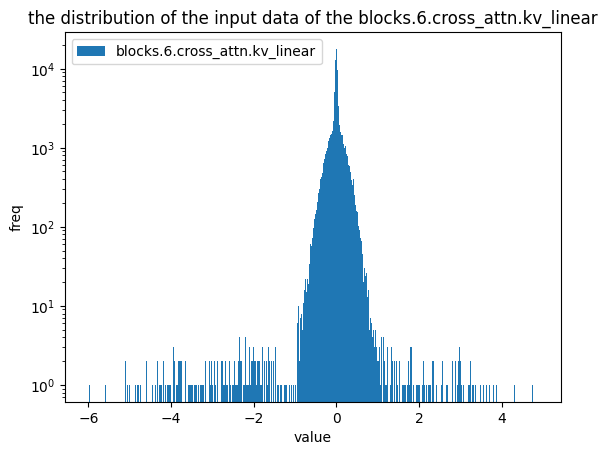

In [11]:
# Global distribution plot
if isinstance(input_data, tuple):
    for i, data in enumerate(input_data):
        plot_activation_pdf(input_data[0], name=name+'_input{i}')
else:
    plot_activation_pdf(input_data, name=name)


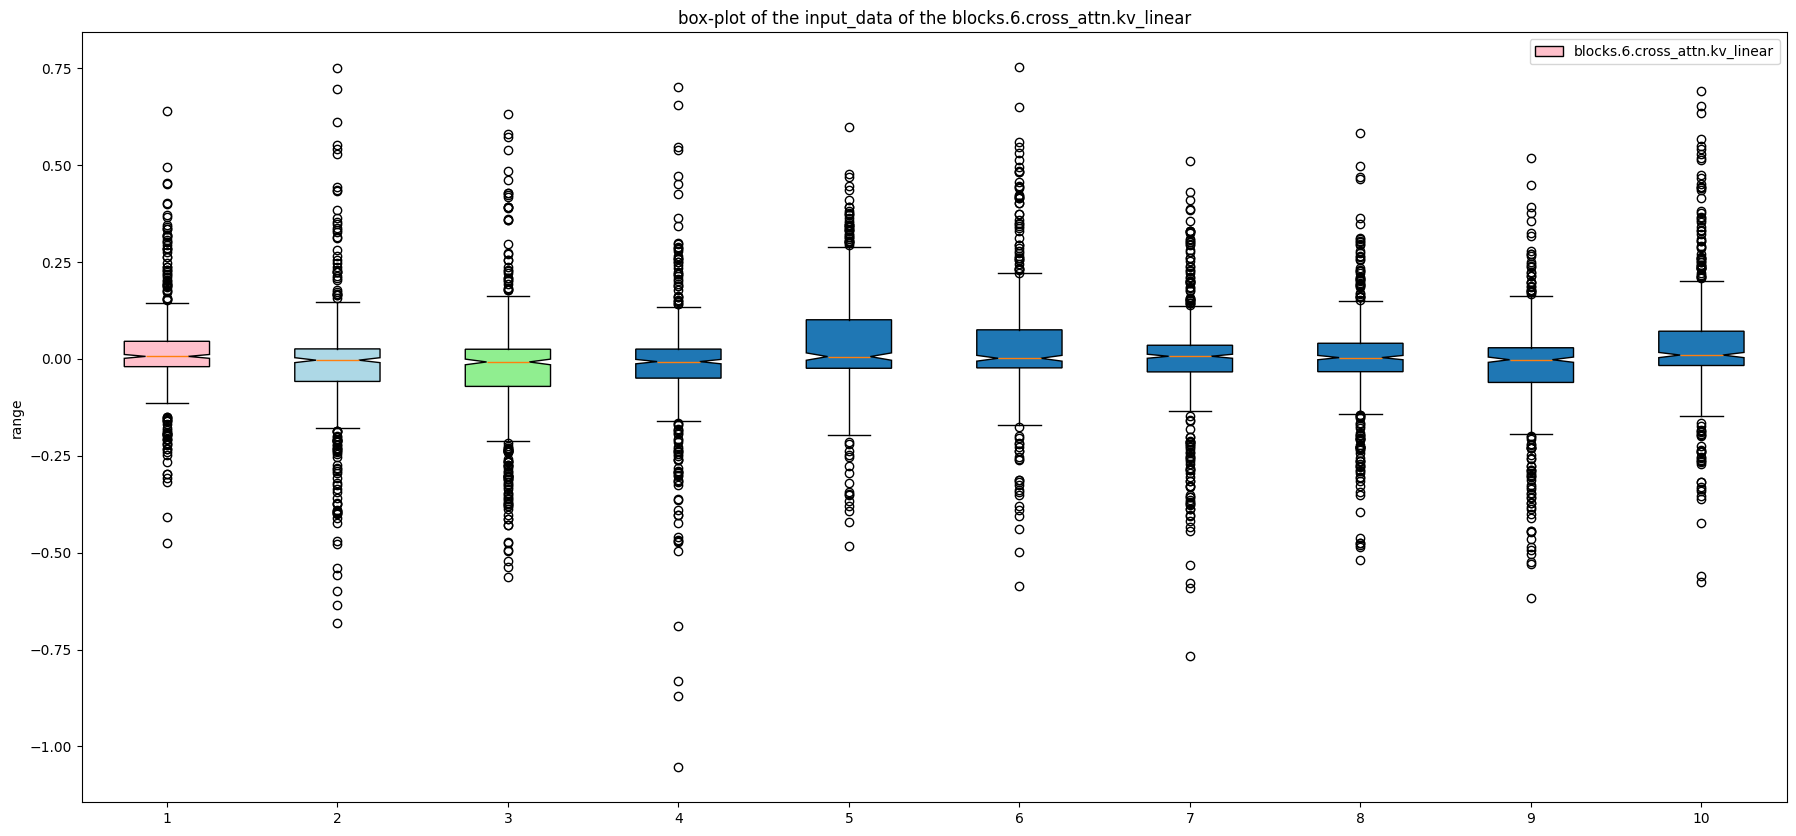

In [85]:
# Box plot
# Distribution plot
if isinstance(input_data, tuple):
    for i, data in enumerate(input_data):
        plot_activation_box(input_data[0], name=name+'_input{i}')
else:
    # the following process should differ with different input data
    part_input_data = select_random_indices(input_data, l=10, select_dim=2)
    plot_activation_box(part_input_data, name=name, split_dim=2)

In [46]:
def plot_activation_channel(input_data, split_dim=0, name=''):
    print(input_data.shape, input_data.shape[split_dim])
    input_data = input_data.cpu().detach()
    # print(input_data.reshape([-1, input_data.shape[split_dim]]).shape)
    max_values = torch.max(input_data.abs().reshape([-1, input_data.shape[split_dim]]),dim=0)[0]
    print(max_values.shape)
    xs = np.arange(len(max_values))

    fig = plt.figure(figsize=(10, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(xs, max_values,width=5)
    ax.set_xlabel("")
    ax.set_ylabel('range')
    # plt.title(f'the mean of input data at dim {split_dim}')
    ax.set_title(f'{name}')
    ax.set_ylim([0,max_values.max()])
    fig.show()
    # fig.savefig(f'./distribution_plot/act/channel_acts_{name}.png')

    
# for name,_ in model.named_modules():
#     if 'mlp.fc' in name:
#         print(name)
        
    
name = 'blocks.1.cross_attn.kv_linear' 
module = get_module_by_name(model, name)
# module  # display the module

data_num = 4
input_data = select_calib_data(calib_data, data_num, select_type="timestep", t=_)
input_data, output_data = get_data(model, module, input_data)
    
print("-"*50)
for i, inp in enumerate(input_data):
    print(f"{i}-th input shape of {name}: {inp.shape}")
print(f"output shape of {name}: {output_data.shape}")

print(input_data[0].max(), input_data[0].min())

# Difference between different channels
if isinstance(input_data, tuple):
    for i, data in enumerate(input_data):
        plot_activation_channel(input_data[0], split_dim=2, name=name+f'_input{i}')
else:
    # the following process should differ with different input data
    part_input_data = select_random_indices(input_data, l=50, select_dim=2)
    plot_activation_channel(part_input_data, split_dim=2, name=name)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


dict_keys(['xs', 'ts', 'cond_emb', 'mask'])
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
Getting the in

dict_keys(['xs', 'ts', 'cond_emb', 'mask'])
torch.Size([2, 4, 16, 64, 64]) cuda:0
torch.Size([2]) cuda:0
torch.Size([2, 1, 120, 4096]) cuda:0
torch.Size([2, 120]) cuda:0
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
torch.Size([2, 4, 16, 64, 64]) cuda:0
torch.Size([2]) cuda:0
torch.Size([2, 1, 120, 4096]) cuda:0
torch.Size([2, 120]) cuda:0
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
torch.Size([2, 4, 16, 64, 64]) cuda:0
torch.Size([2]) cuda:0
torch.Size([2, 1, 120, 4096]) cuda:0
torch.Size([2, 120]) cuda:0
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
torch.Size([2, 4, 16, 64, 64]) cuda:0
torch.Size([2]) cuda:0
torch.Size([2, 1, 120, 4096]) cuda:0
torch.Siz

/tmp/ipykernel_842245/1589251491.py:20: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



1
torch.Size([2, 16384, 1152]) 1152
torch.Size([1152])
2
torch.Size([2, 16384, 1152]) 1152
torch.Size([1152])
3
torch.Size([2, 16384, 1152]) 1152
torch.Size([1152])
4
torch.Size([2, 16384, 1152]) 1152
torch.Size([1152])
5
torch.Size([2, 16384, 1152]) 1152
torch.Size([1152])
6
torch.Size([2, 16384, 1152]) 1152
torch.Size([1152])
7
torch.Size([2, 16384, 1152]) 1152
torch.Size([1152])
8
torch.Size([2, 16384, 1152]) 1152
torch.Size([1152])
9
torch.Size([2, 16384, 1152]) 1152
torch.Size([1152])
dict_keys(['xs', 'ts', 'cond_emb', 'mask'])
torch.Size([2, 4, 16, 64, 64]) cuda:0
torch.Size([2]) cuda:0
torch.Size([2, 1, 120, 4096]) cuda:0
torch.Size([2, 120]) cuda:0
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
torch.Size([2, 4, 16, 64, 64]) cuda:0
torch.Size([2]) cuda:0
torch.Size([2, 1, 120, 4096]) cuda:0
torch.Size([2, 120]) cuda:0
Getting the intermediate output at one inference...I

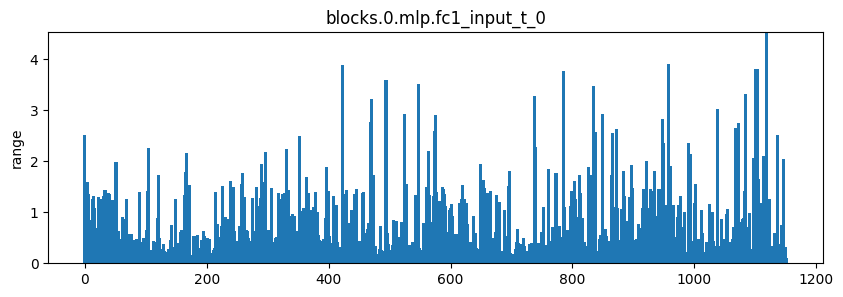

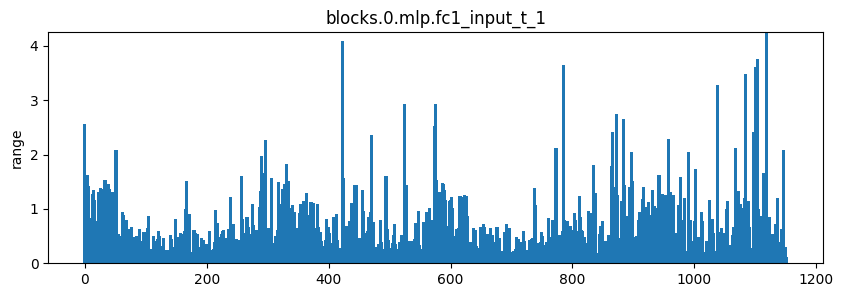

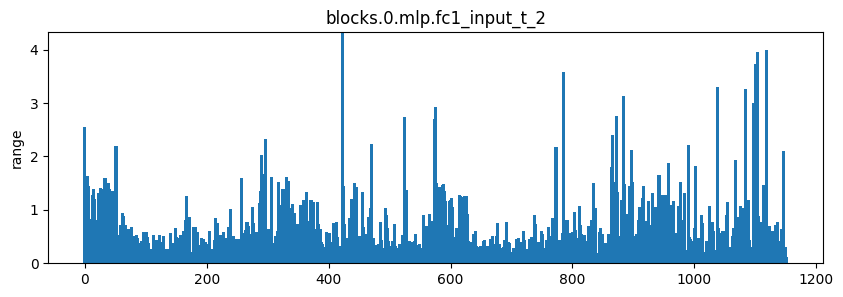

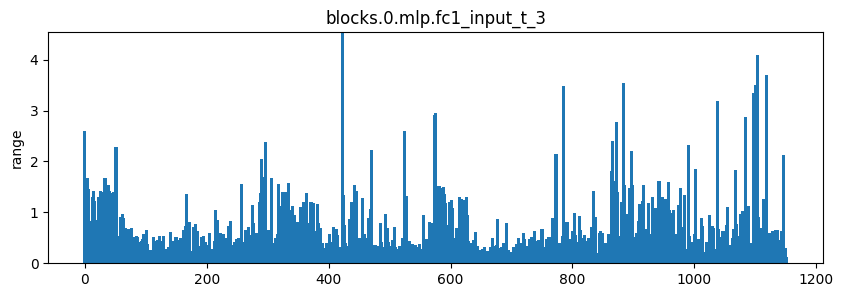

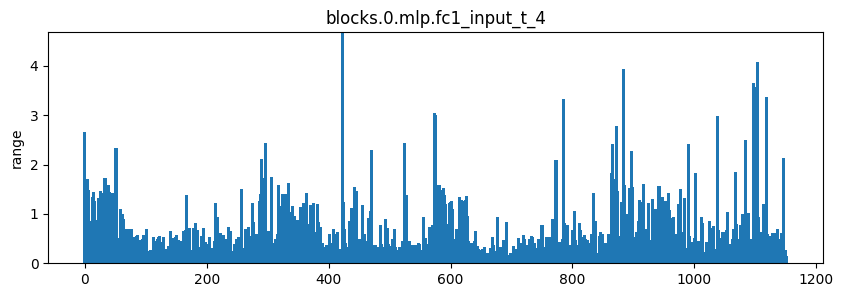

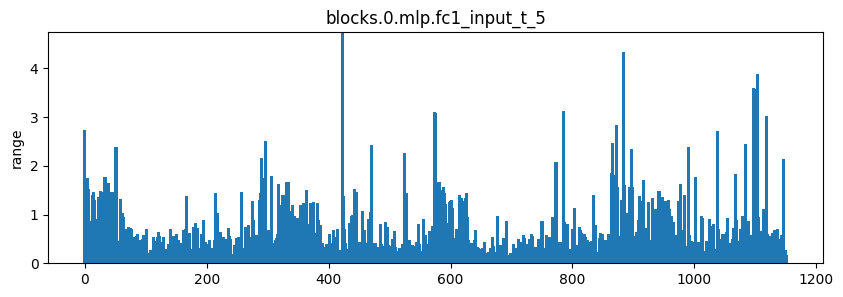

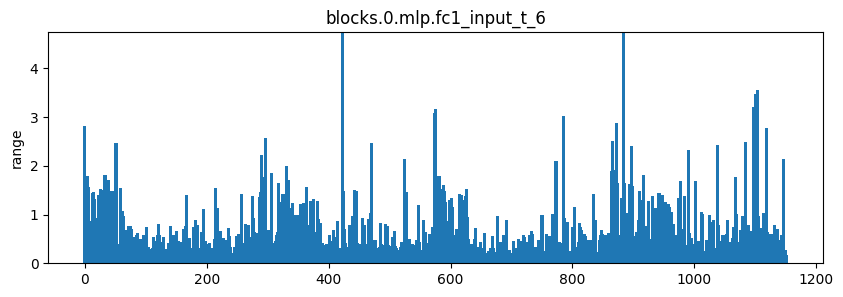

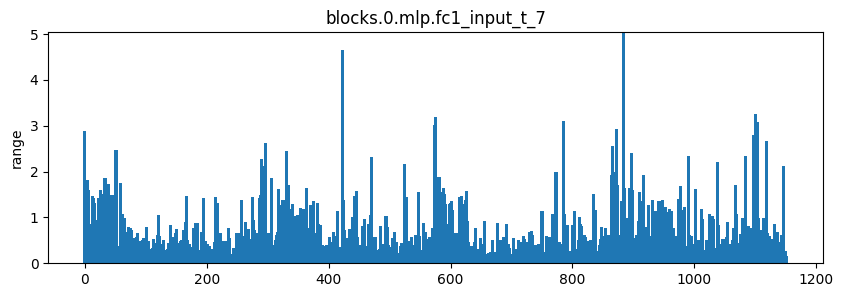

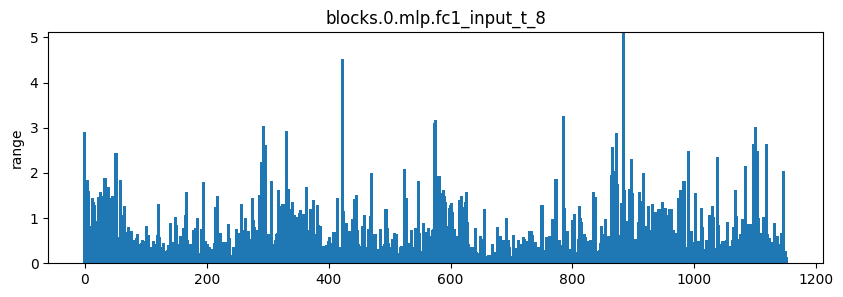

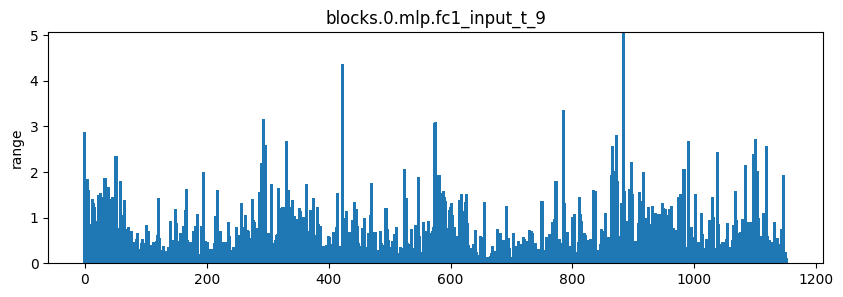

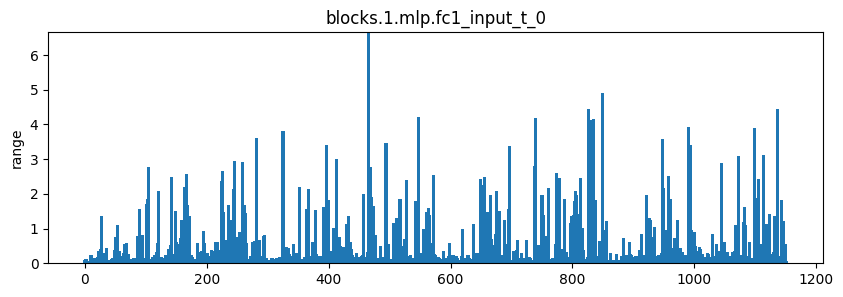

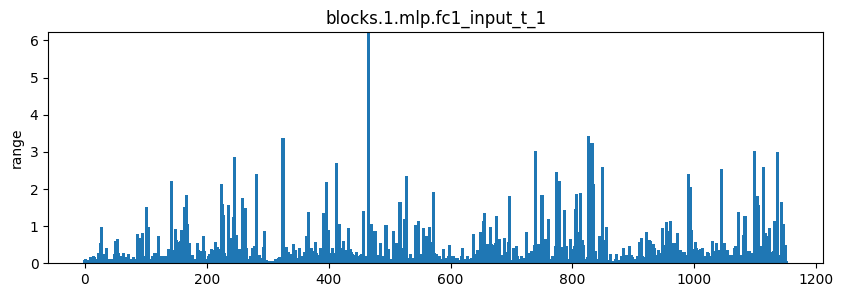

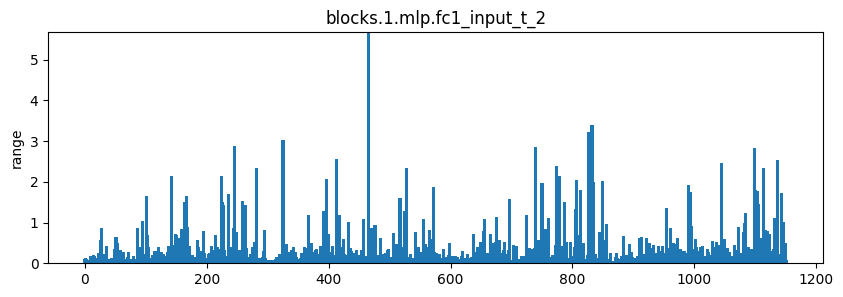

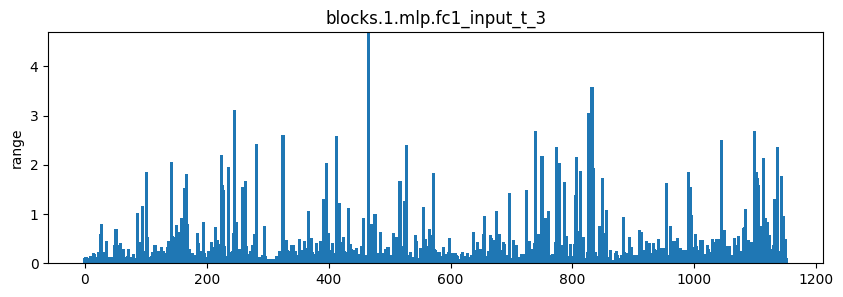

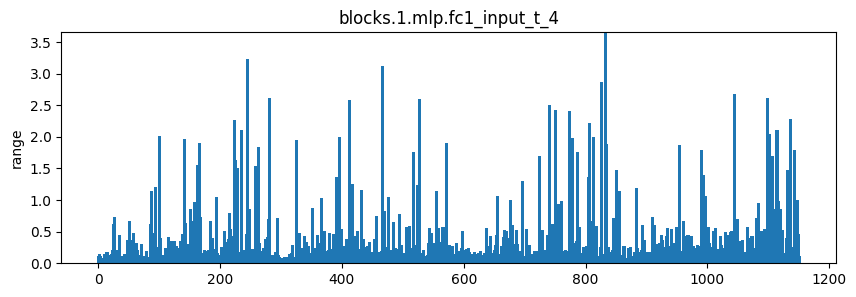

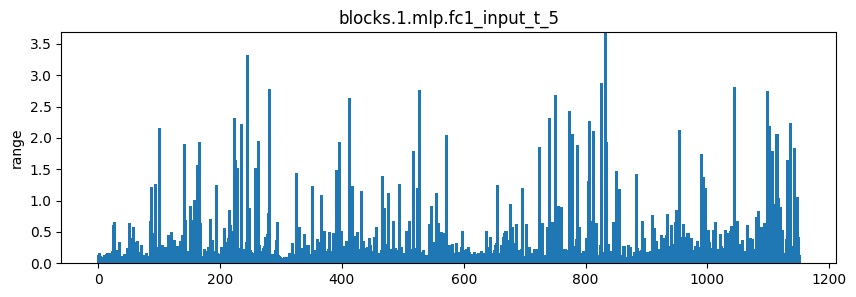

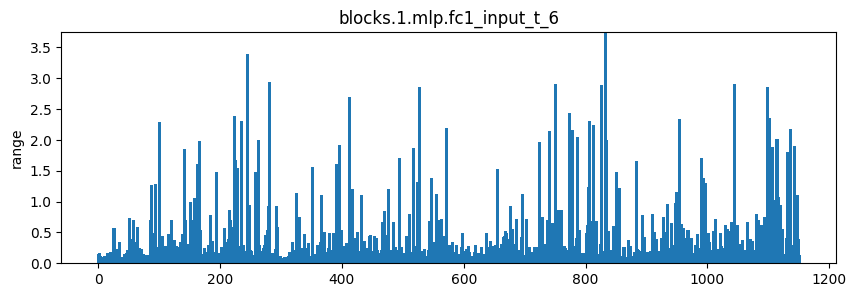

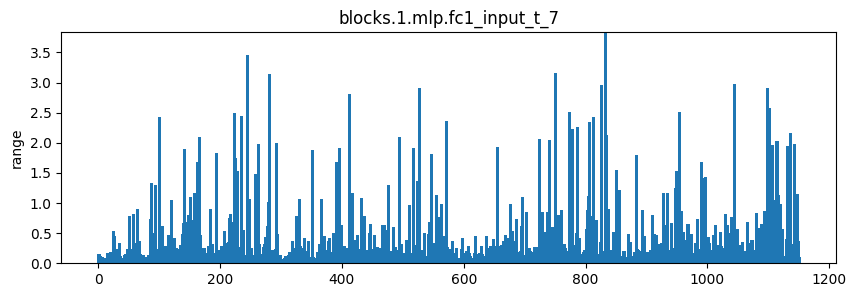

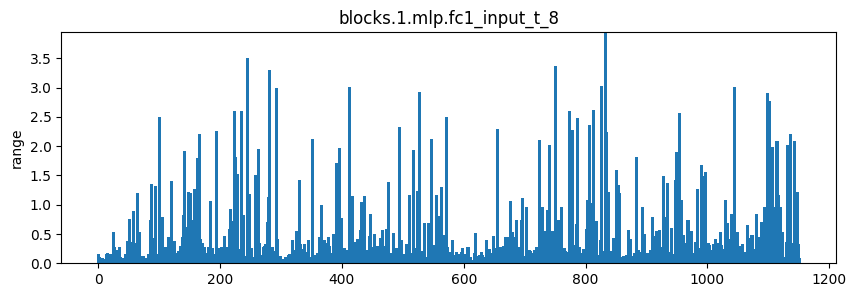

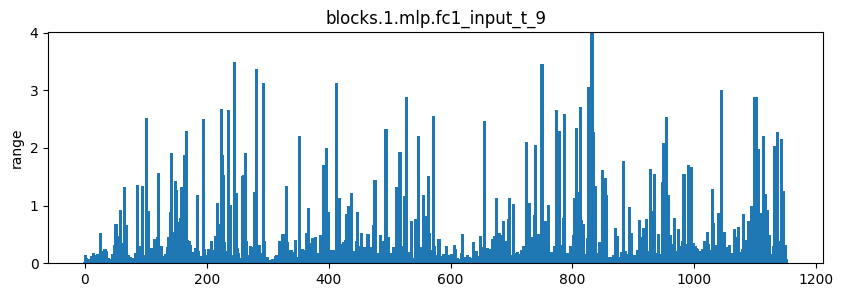

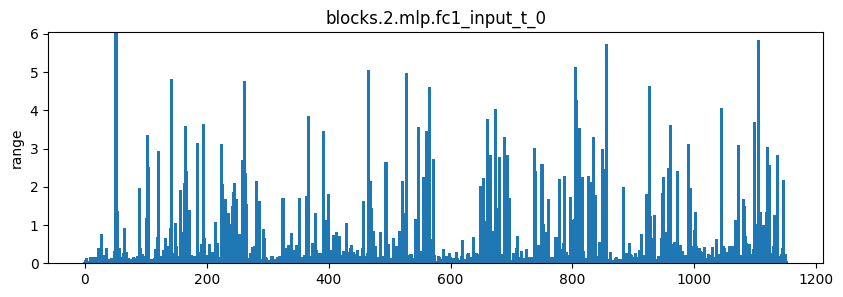

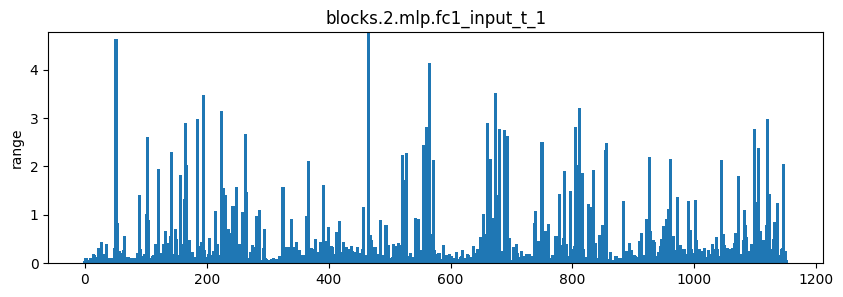

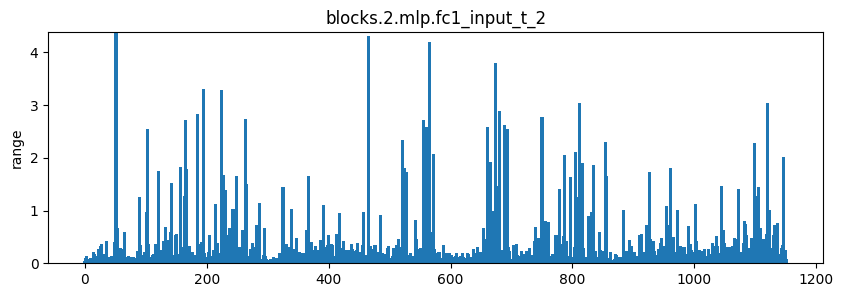

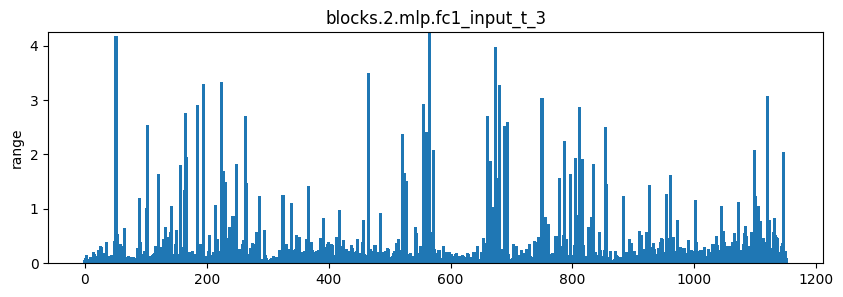

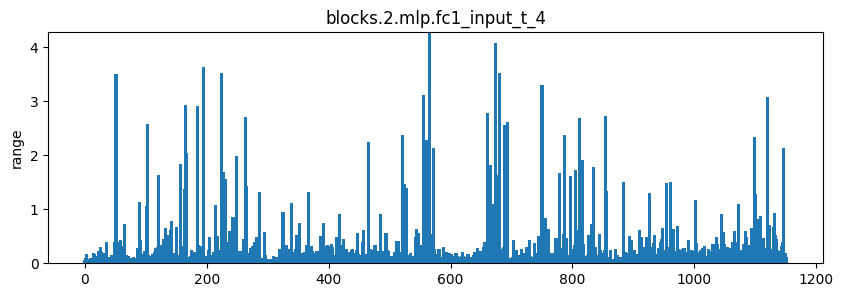

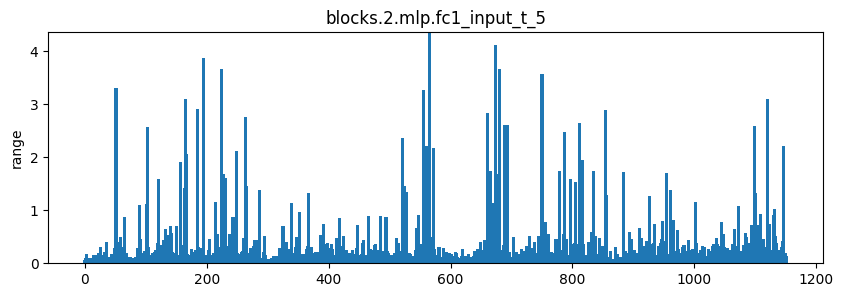

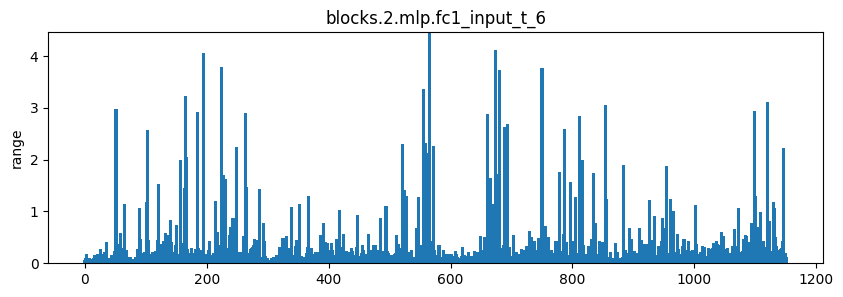

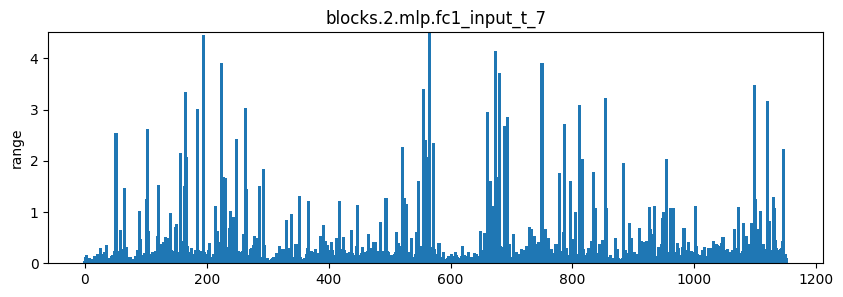

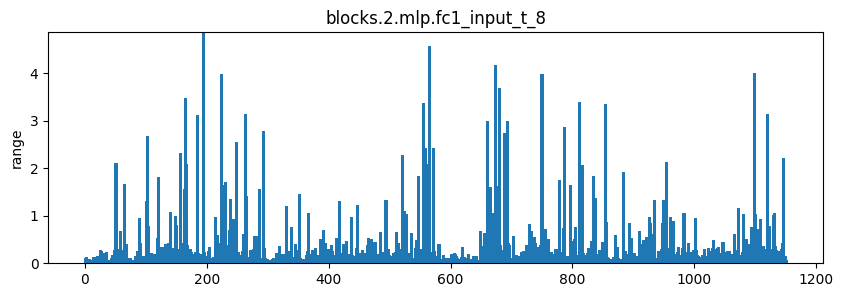

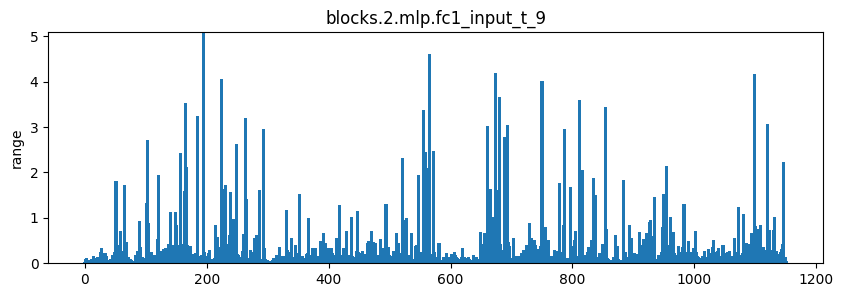

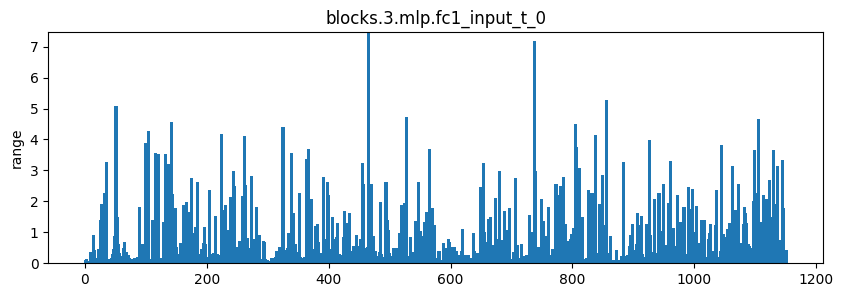

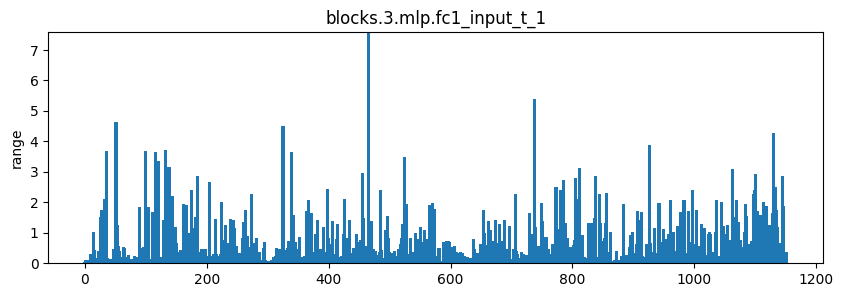

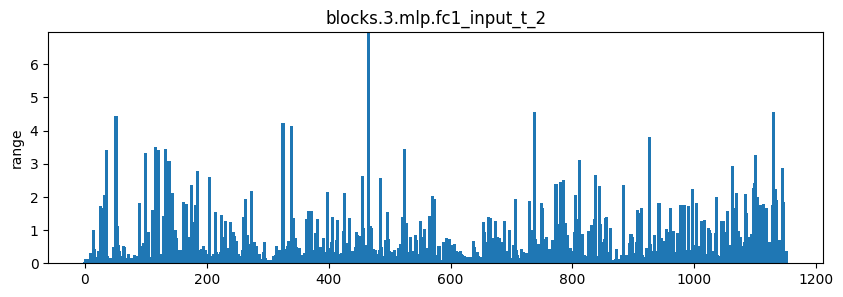

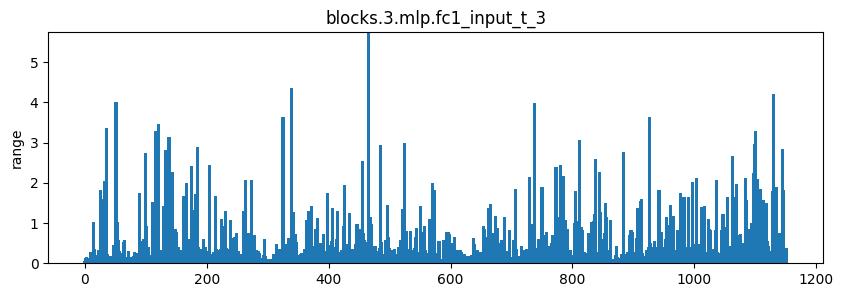

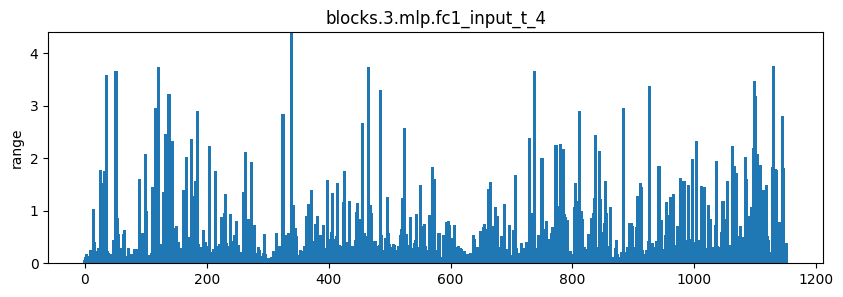

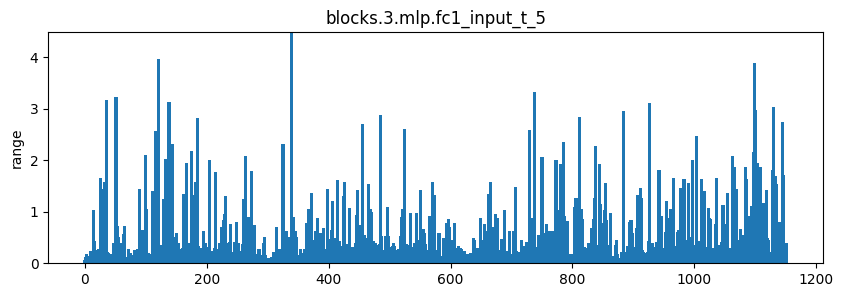

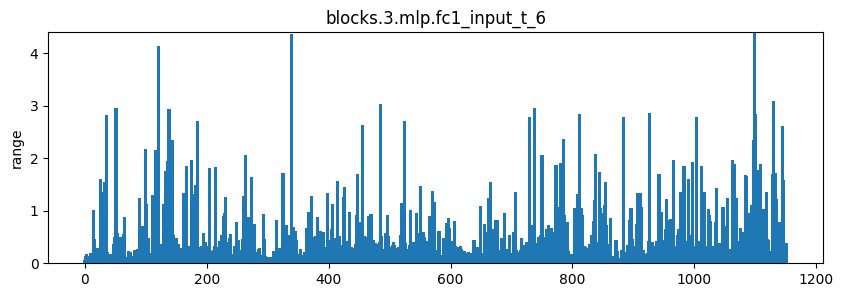

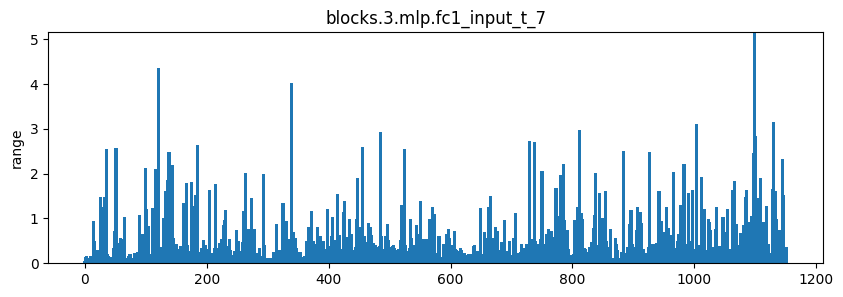

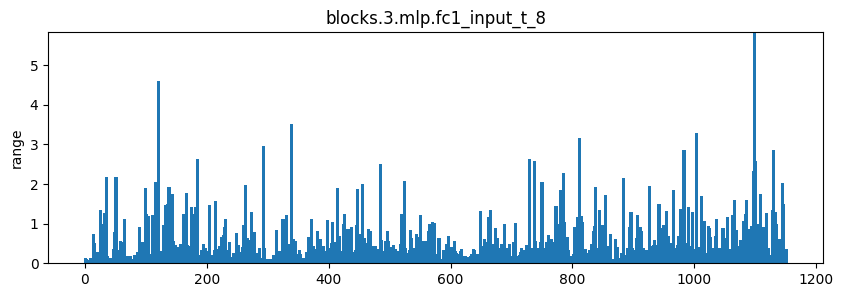

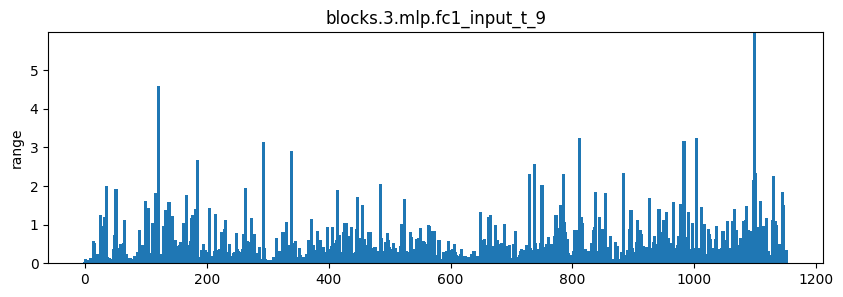

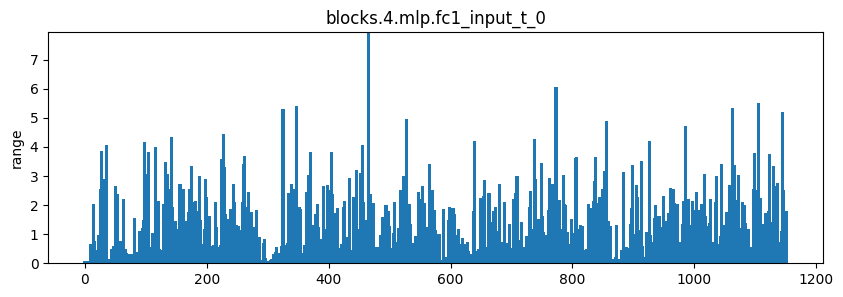

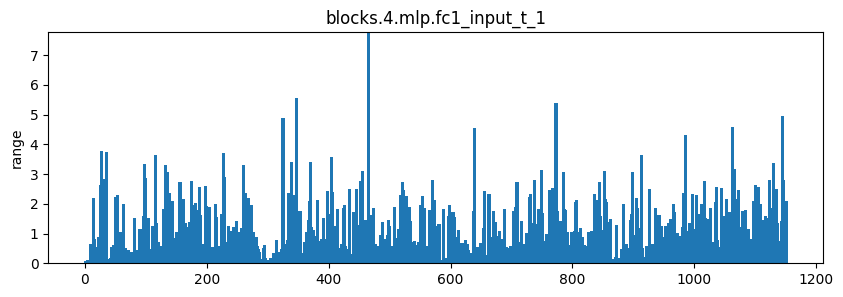

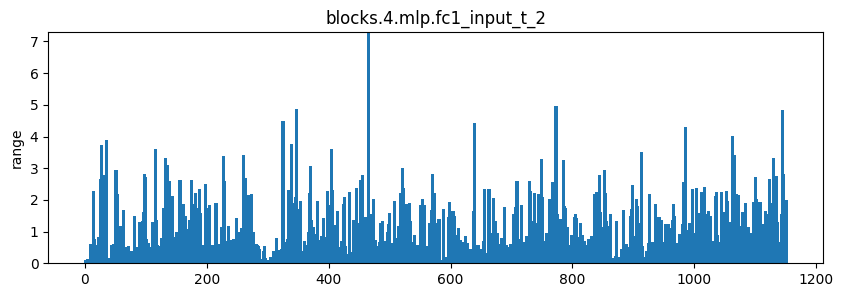

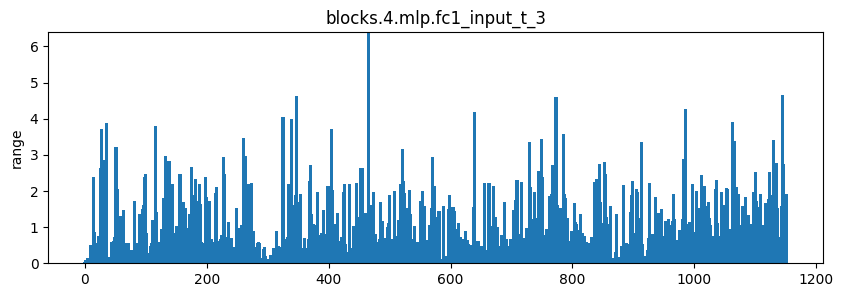

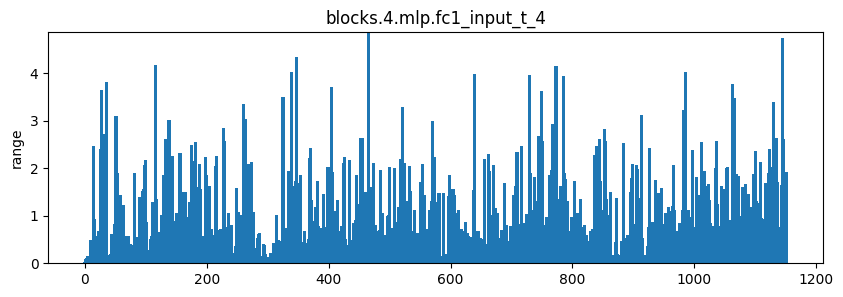

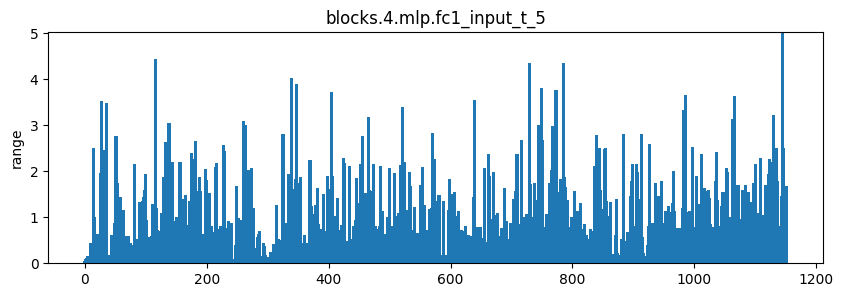

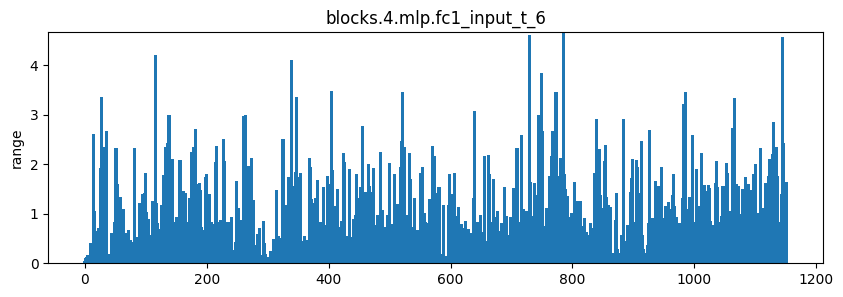

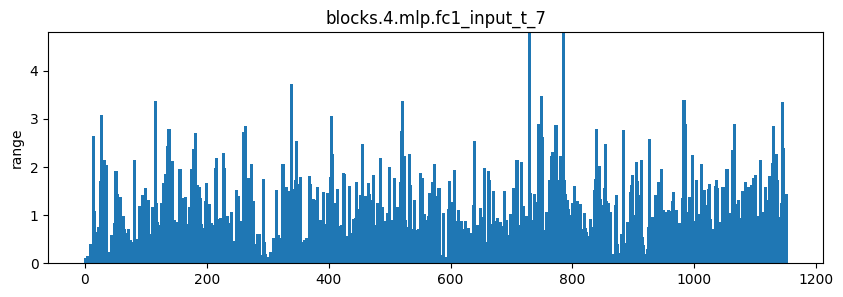

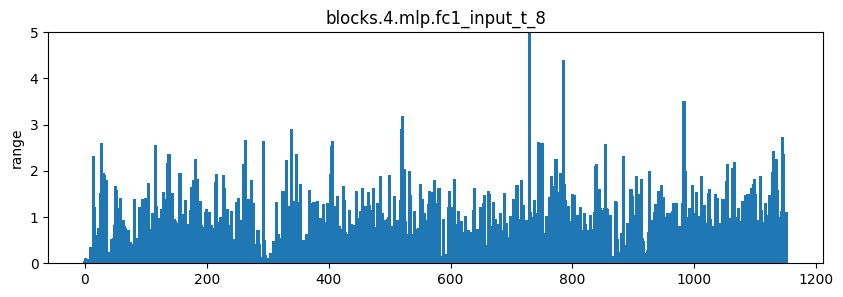

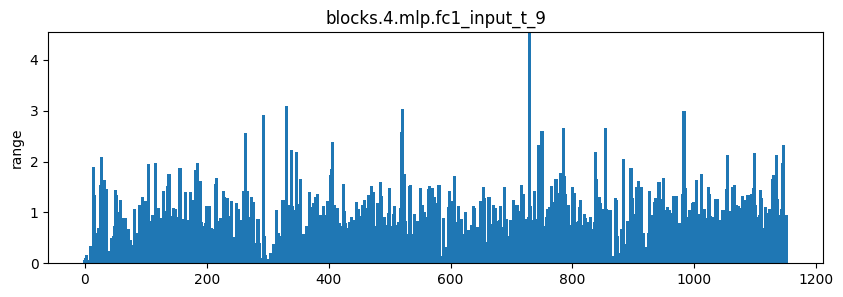

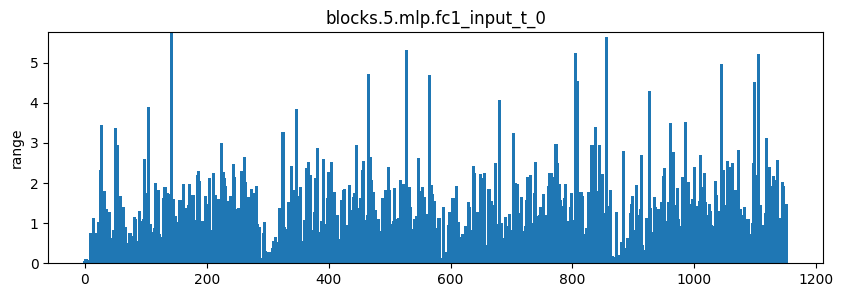

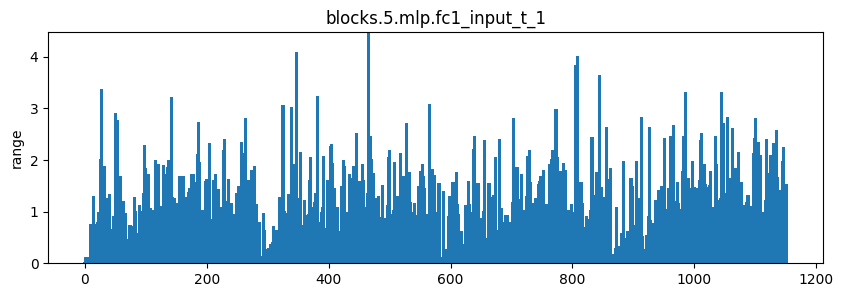

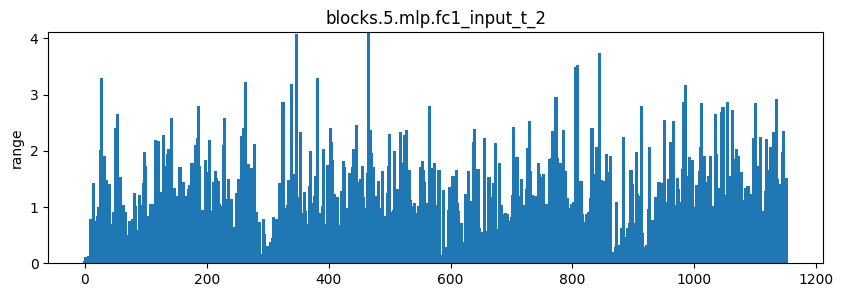

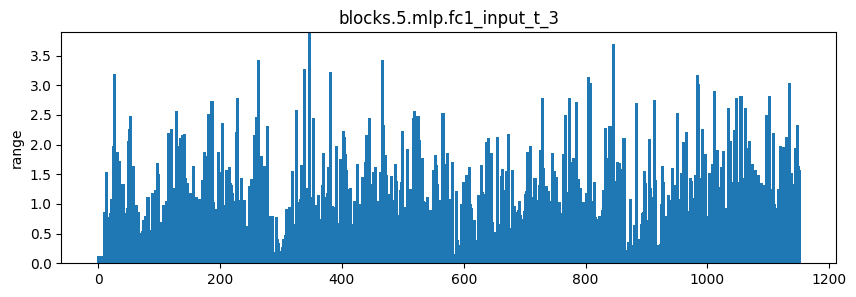

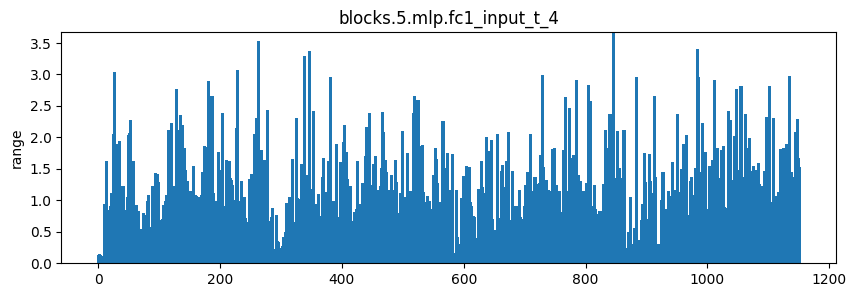

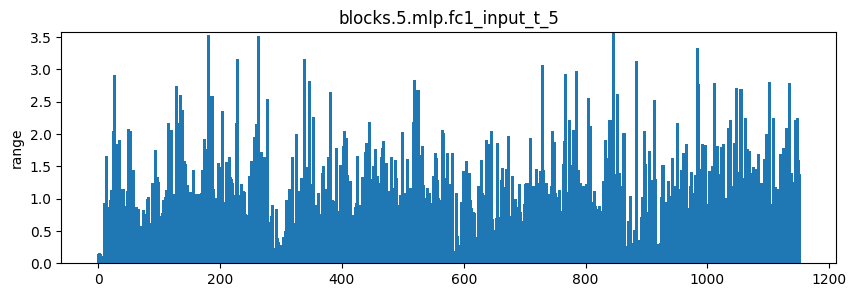

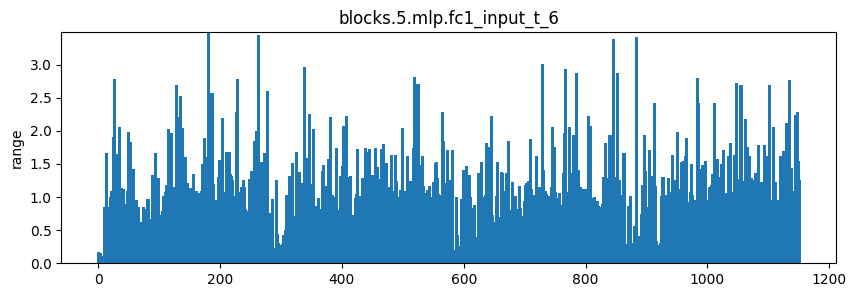

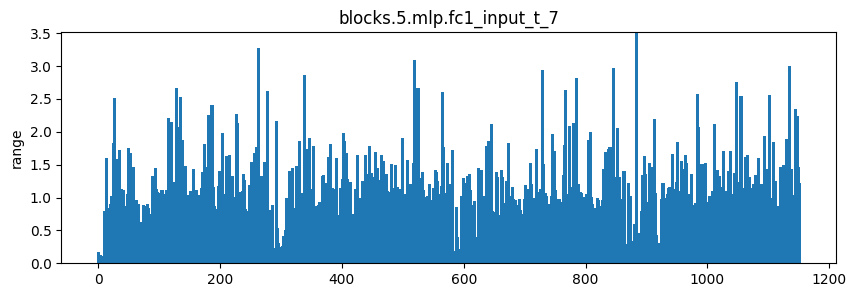

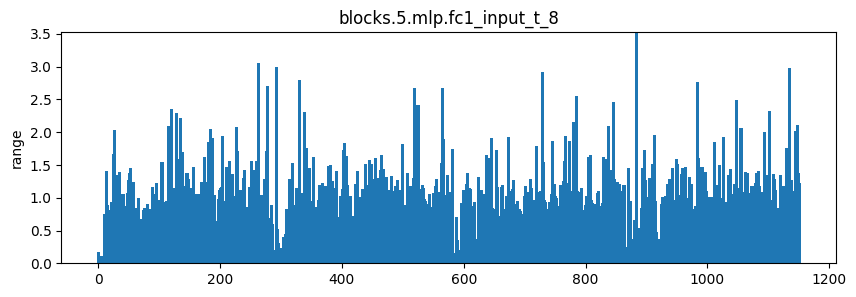

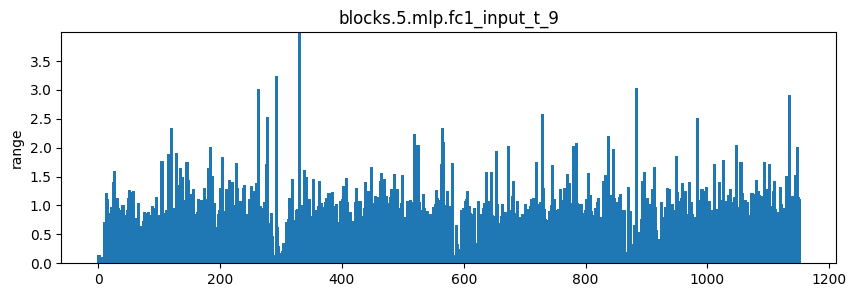

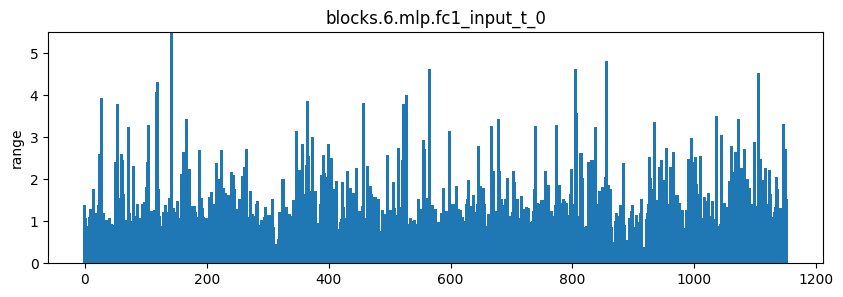

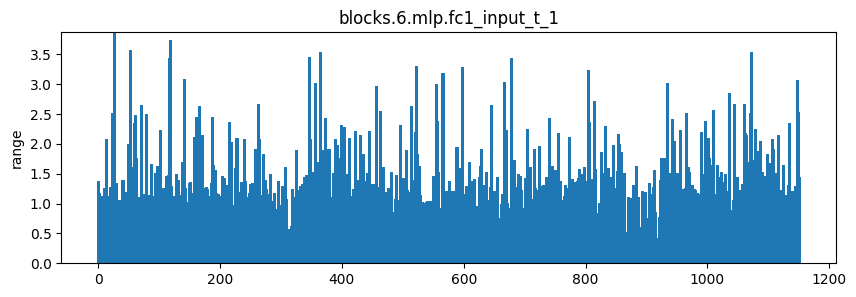

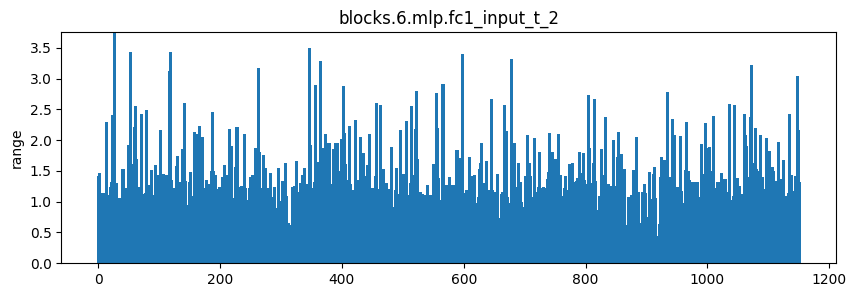

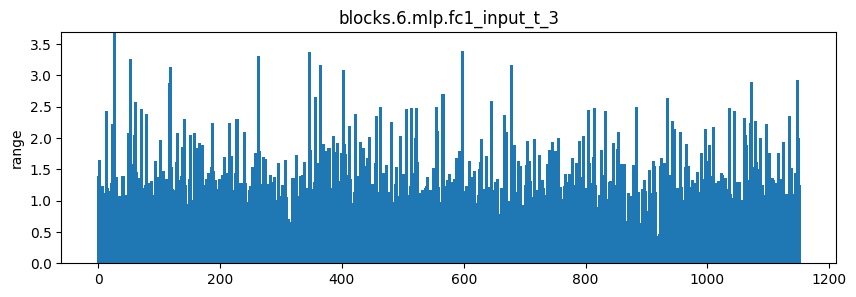

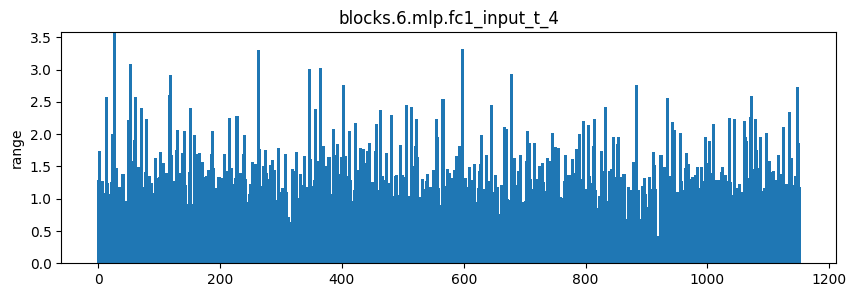

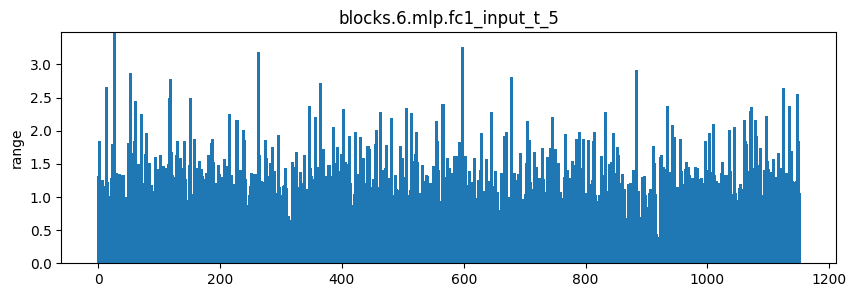

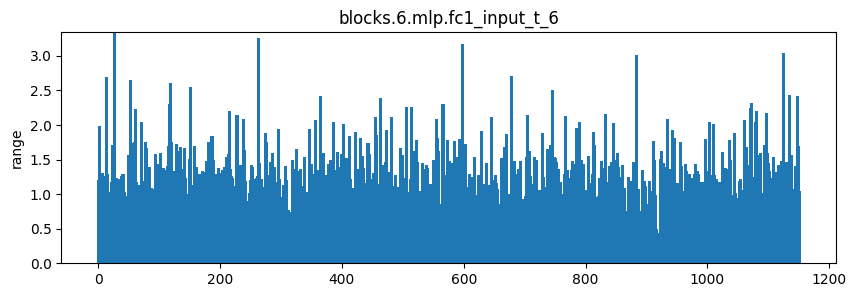

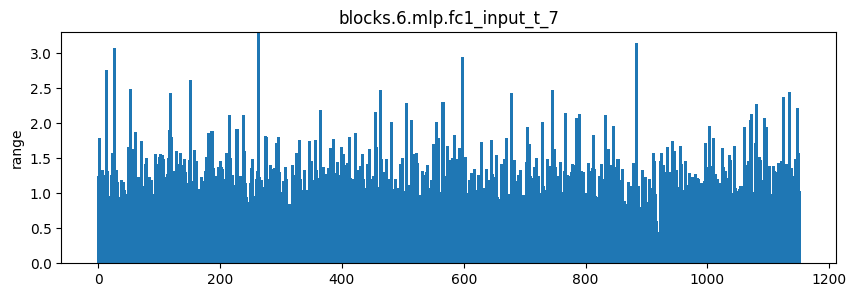

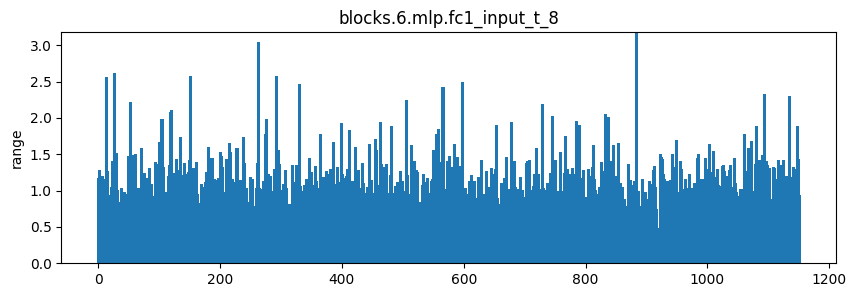

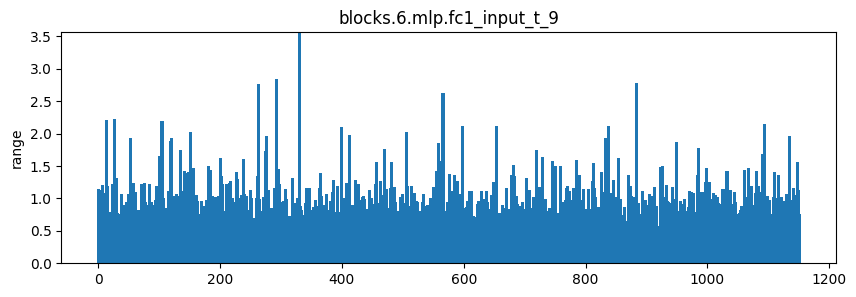

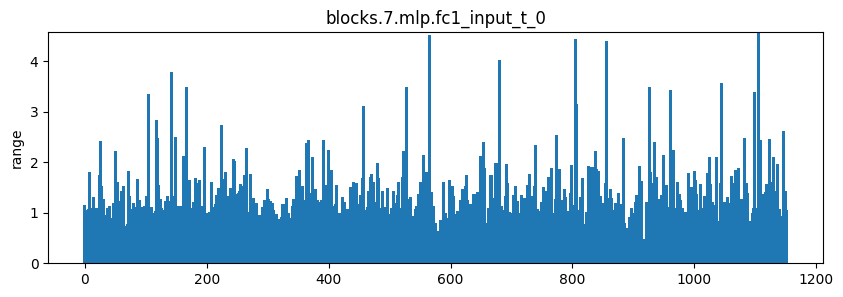

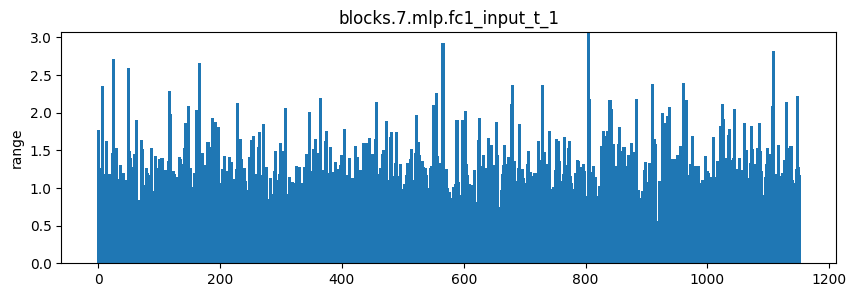

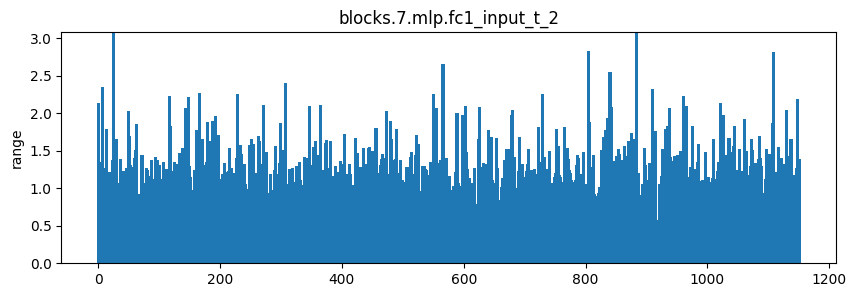

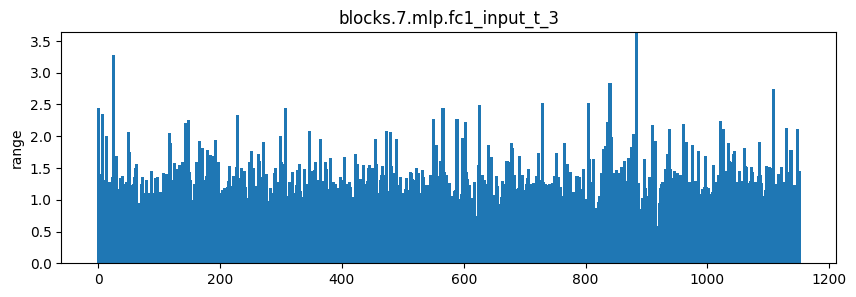

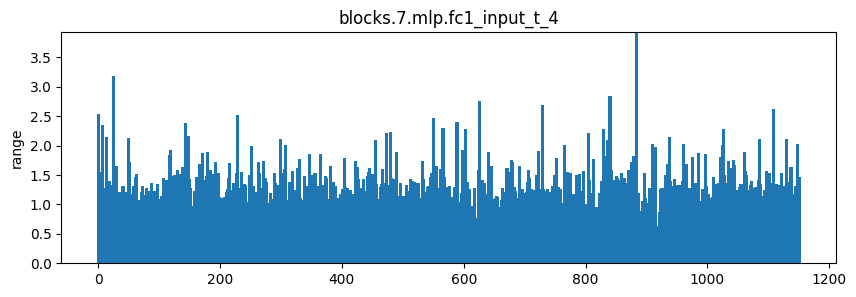

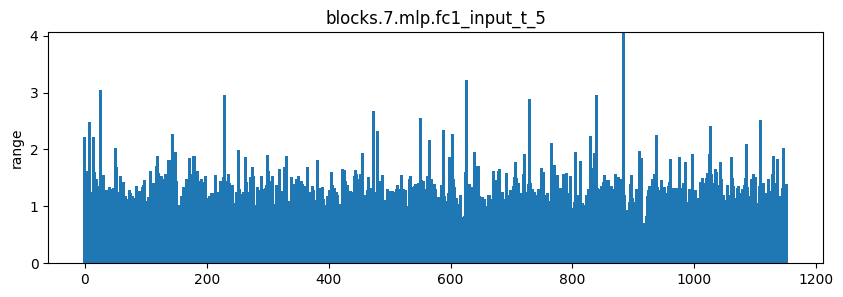

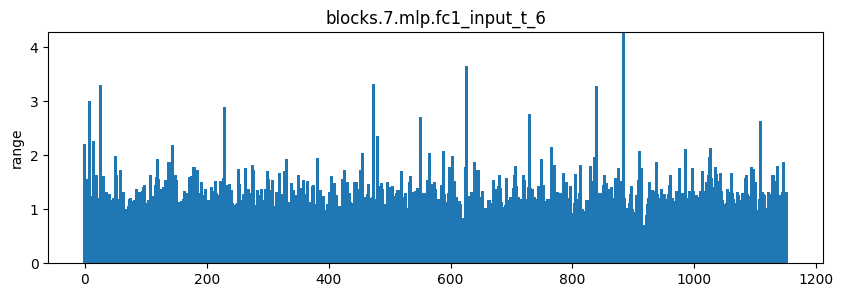

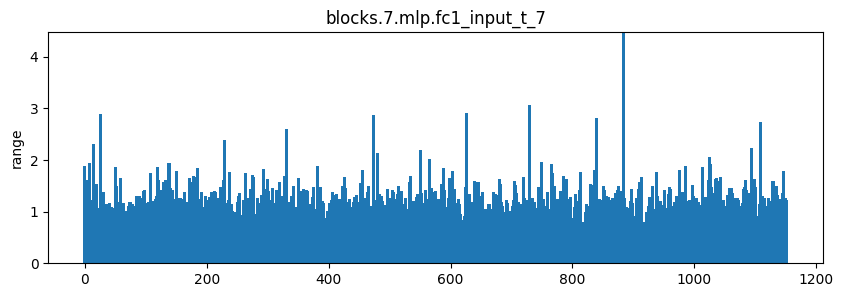

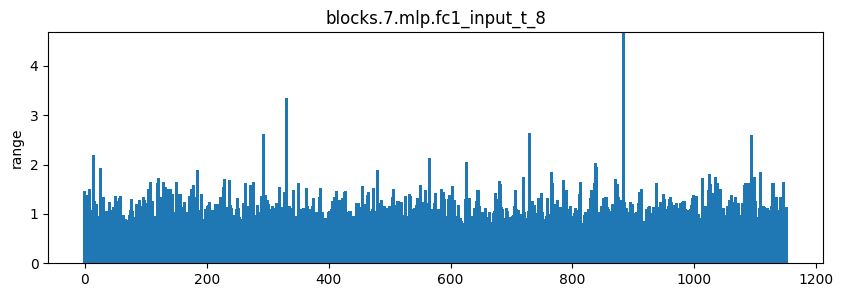

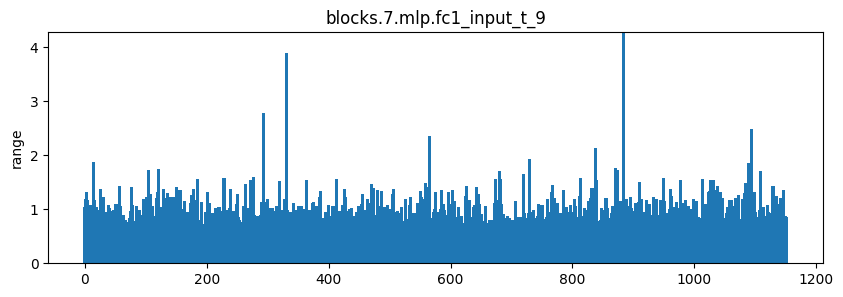

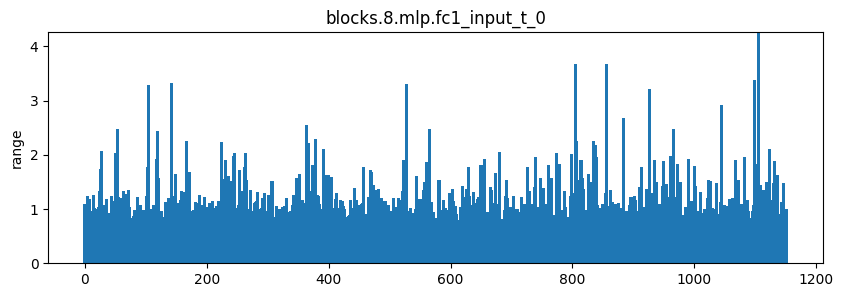

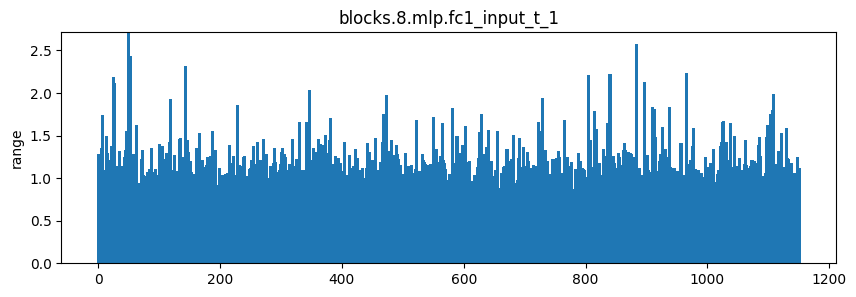

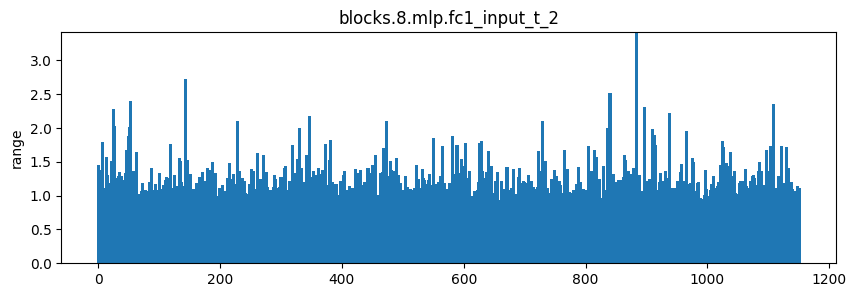

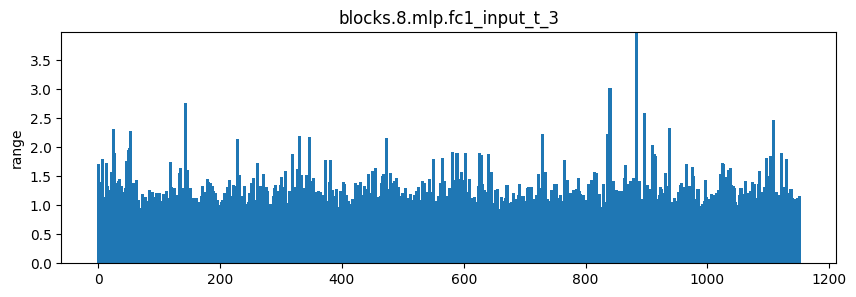

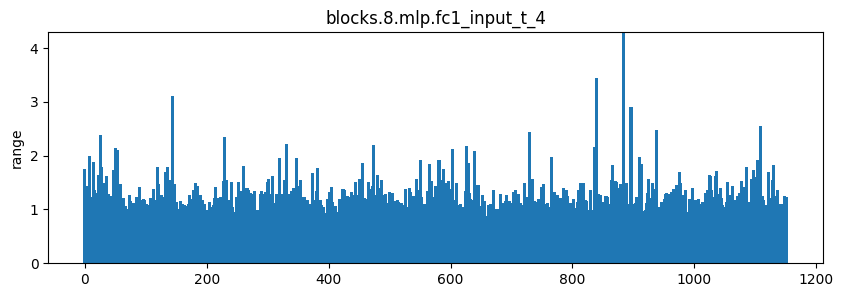

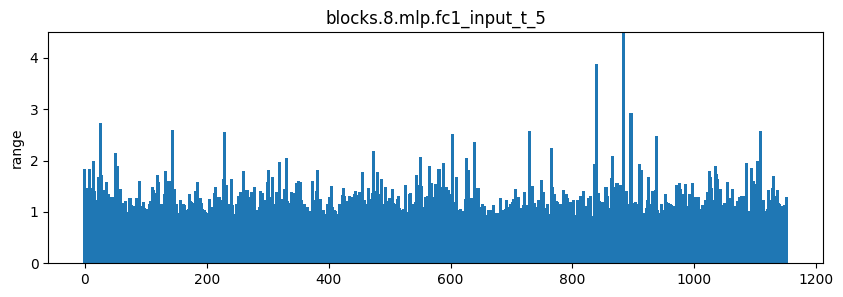

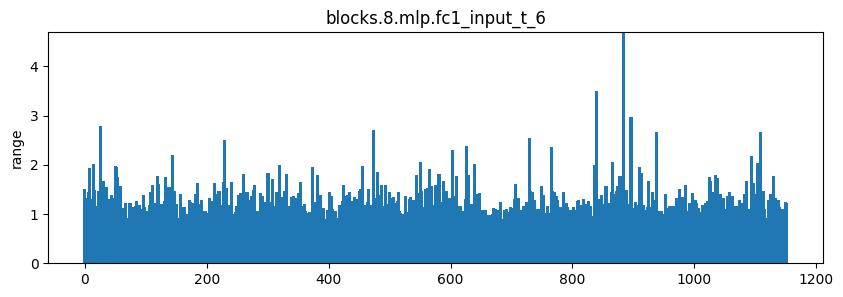

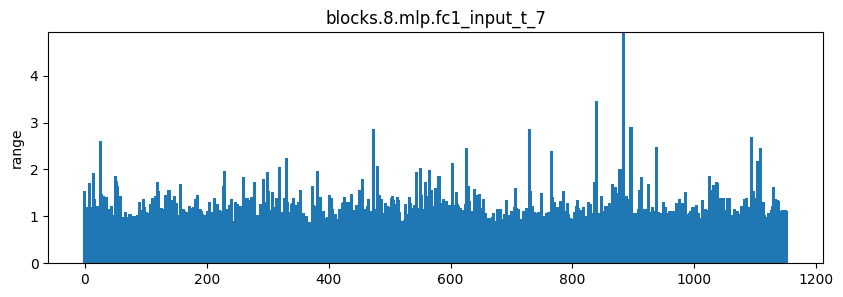

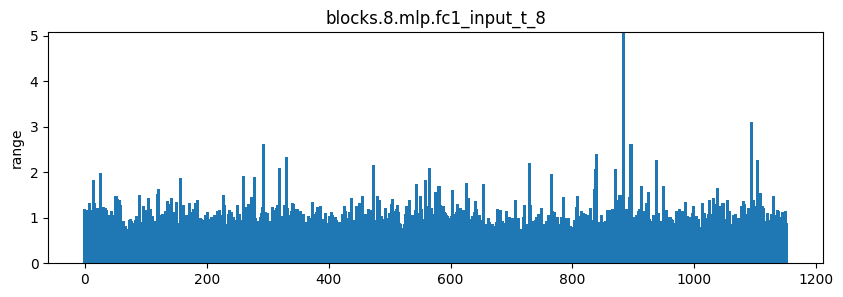

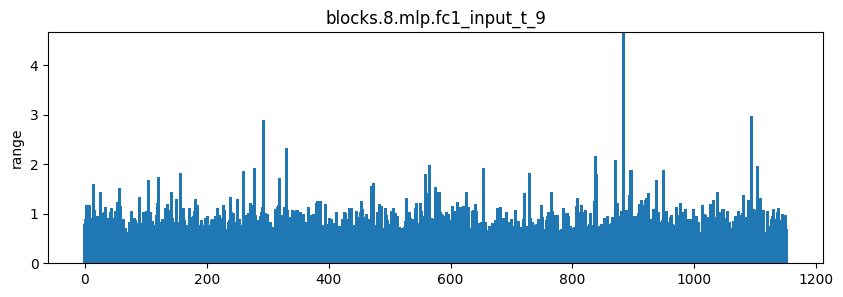

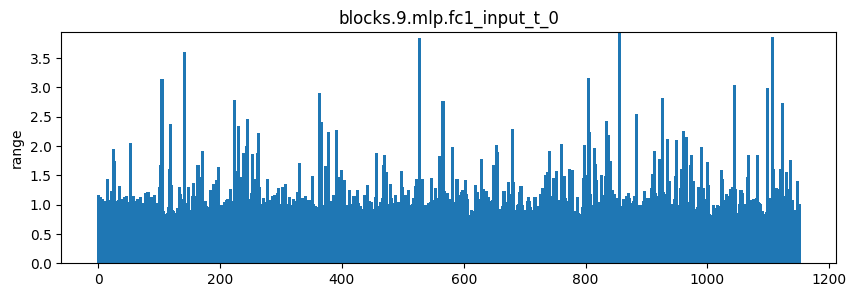

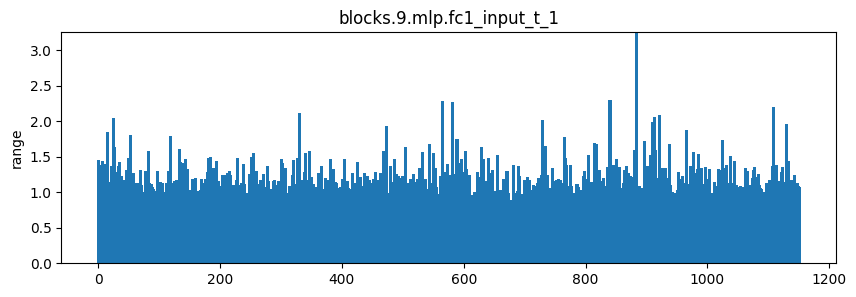

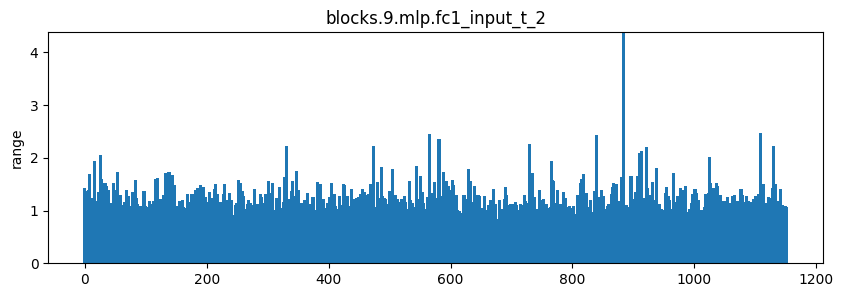

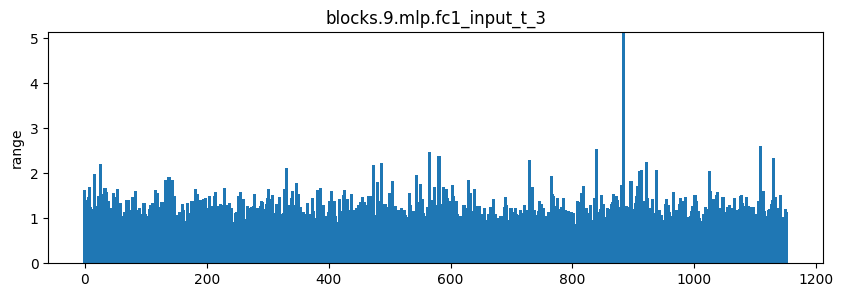

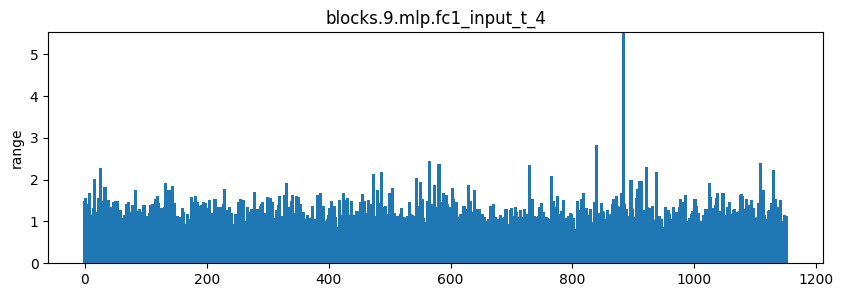

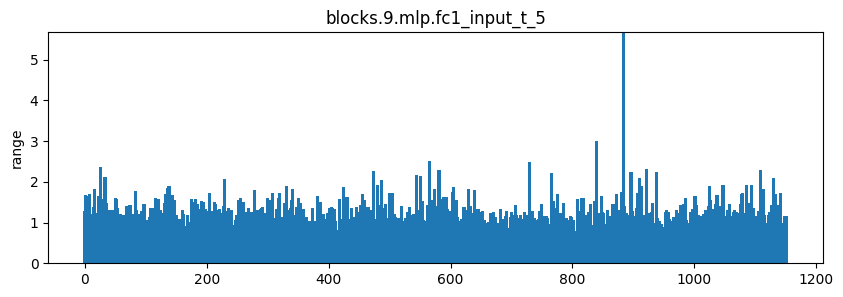

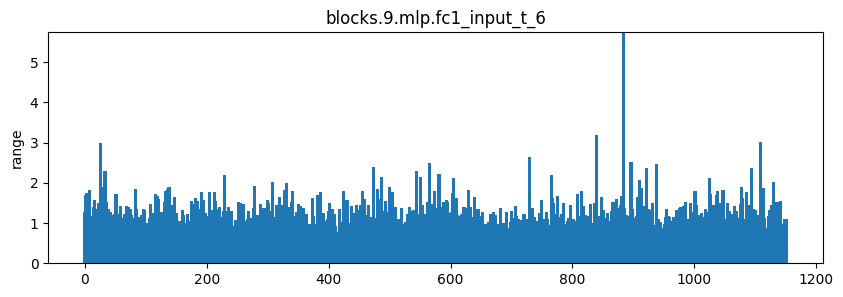

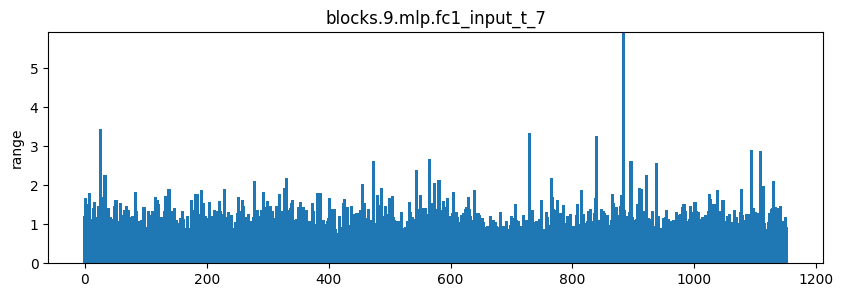

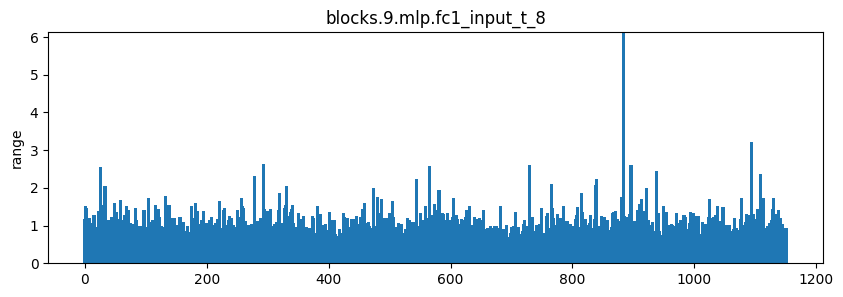

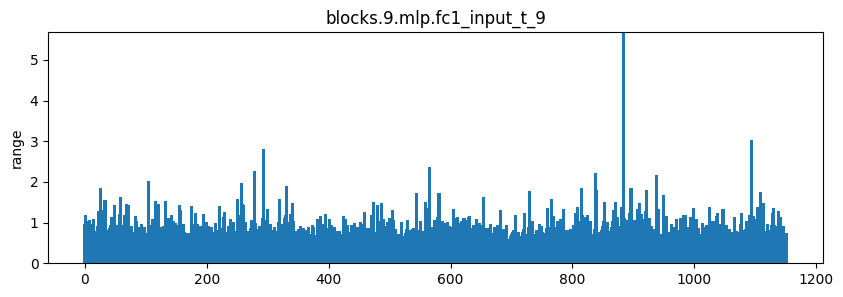

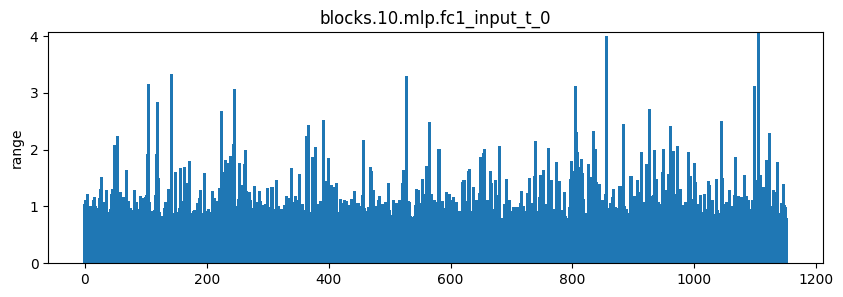

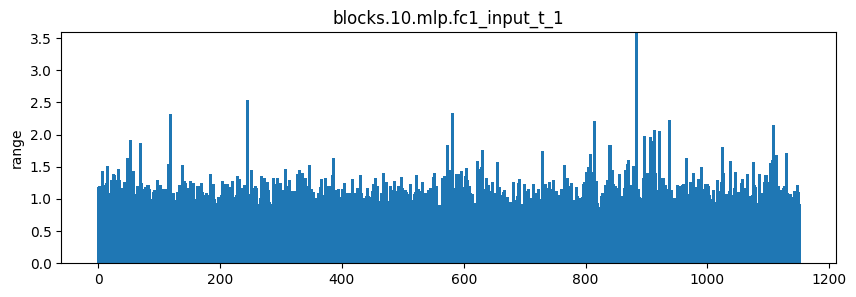

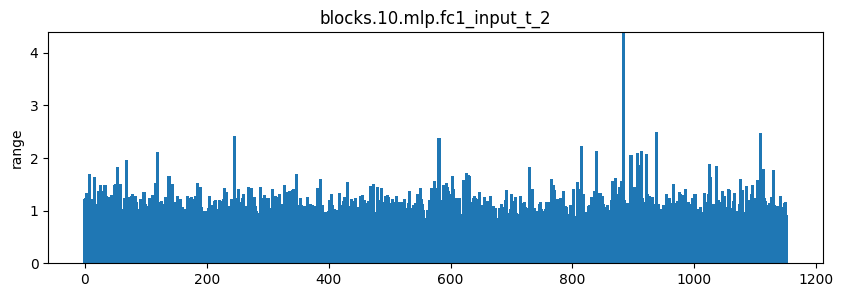

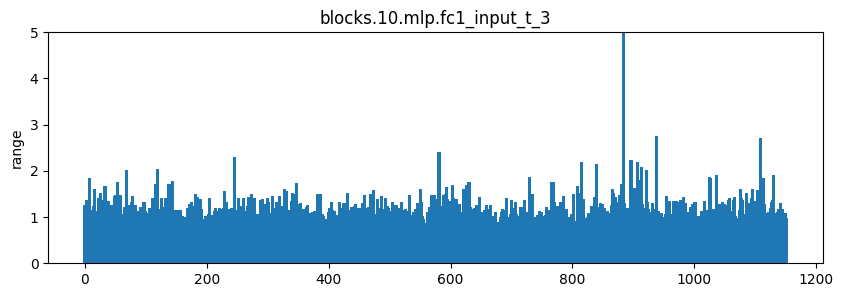

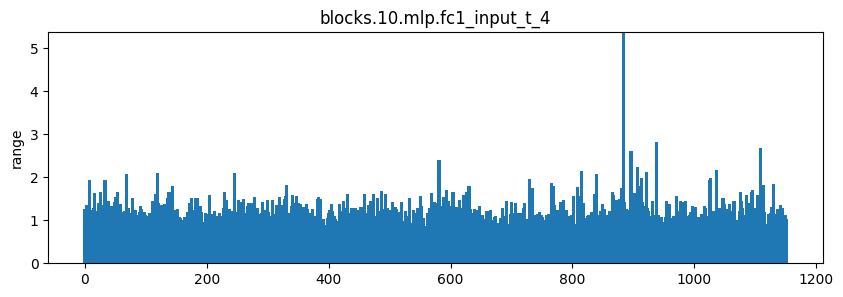

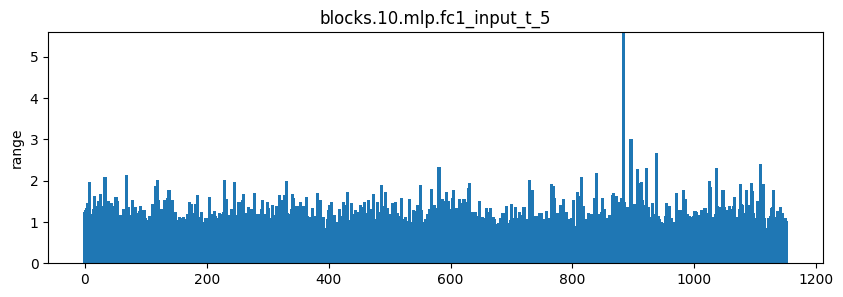

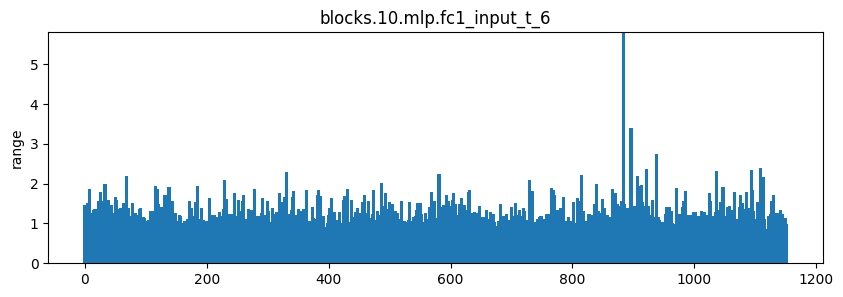

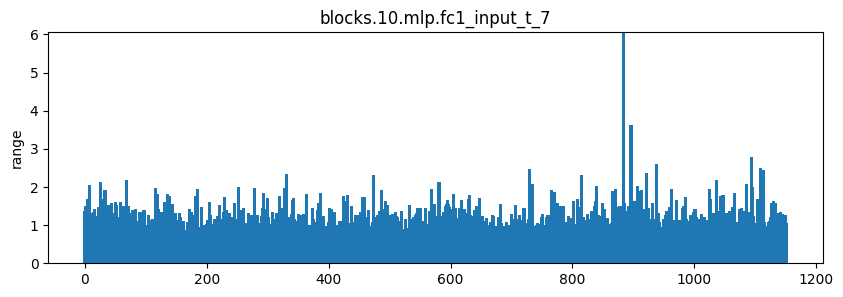

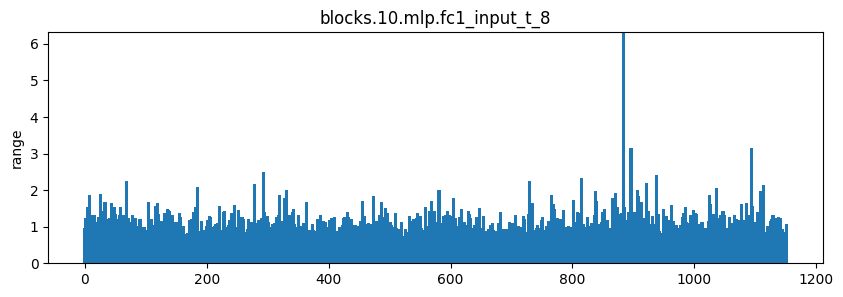

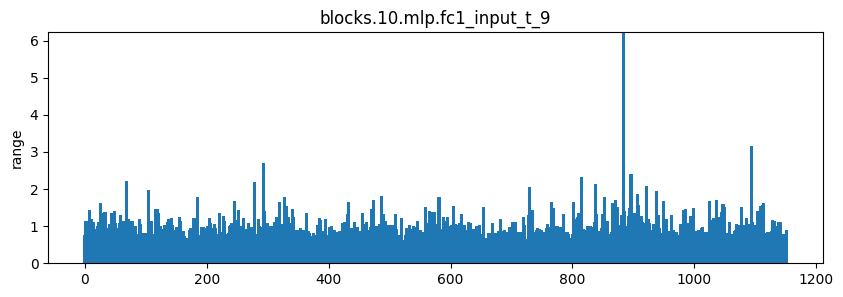

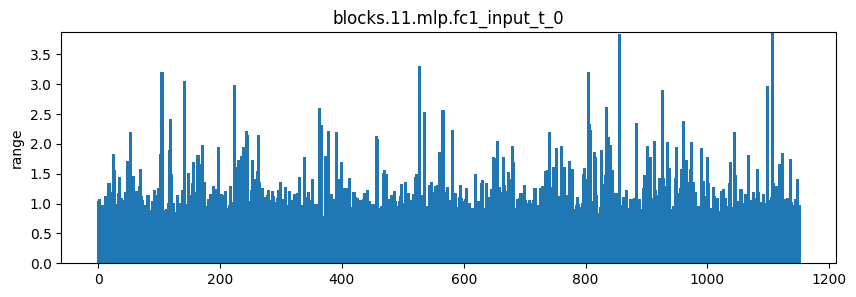

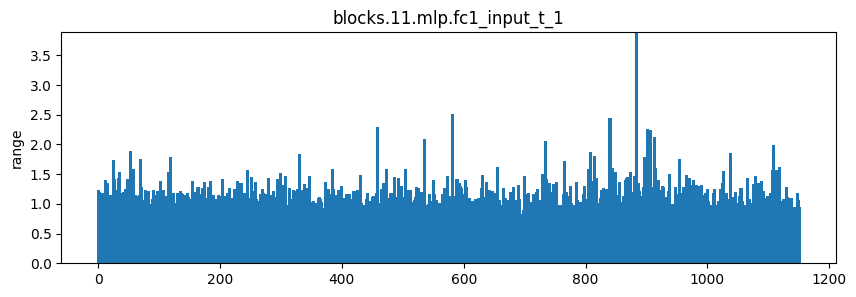

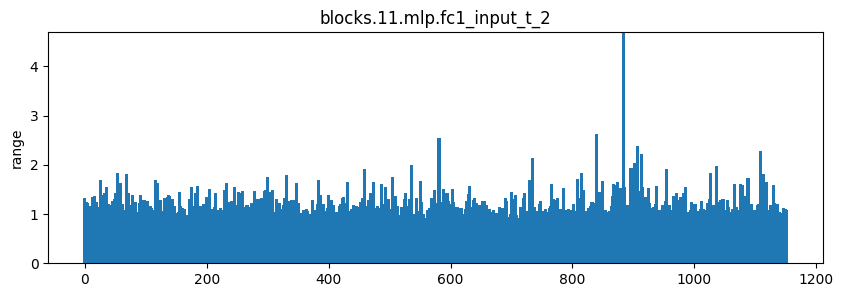

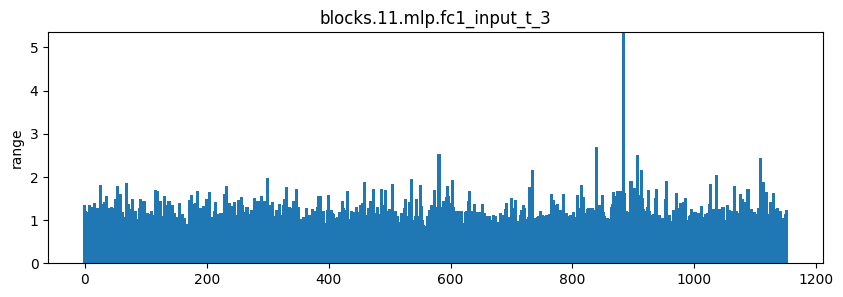

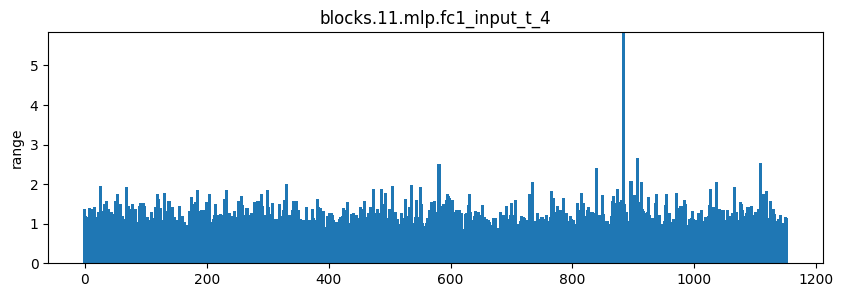

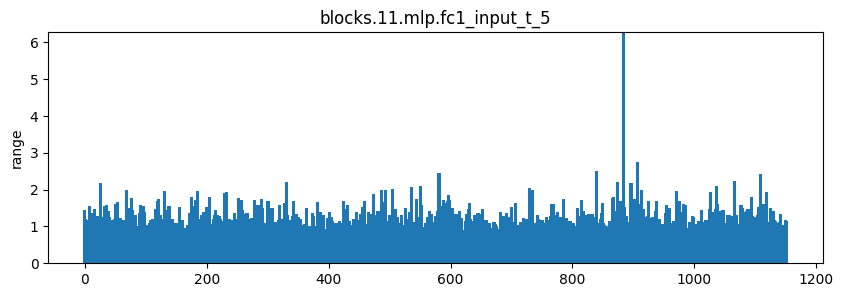

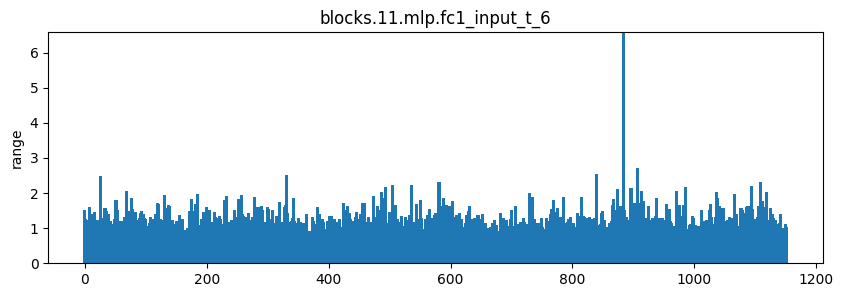

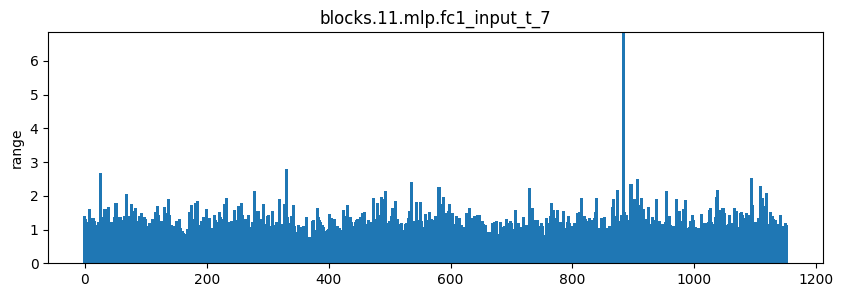

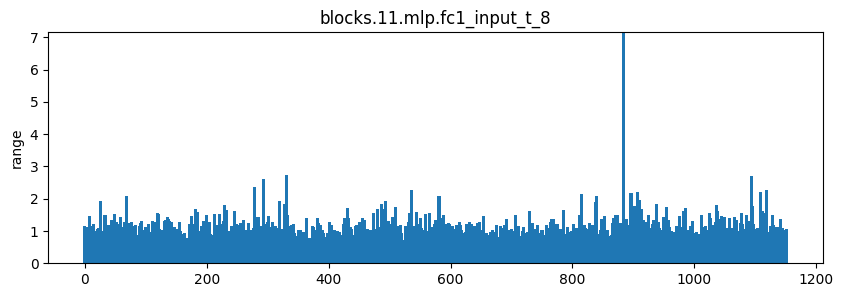

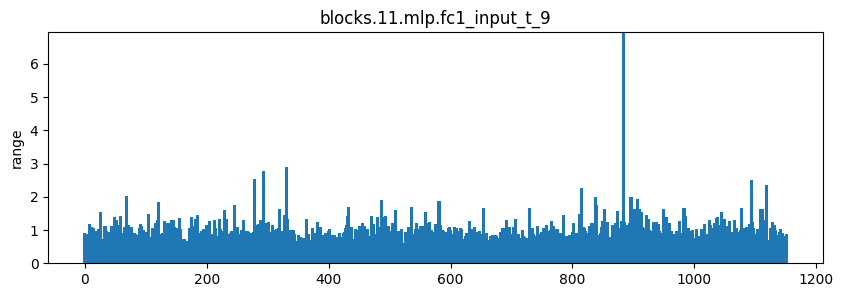

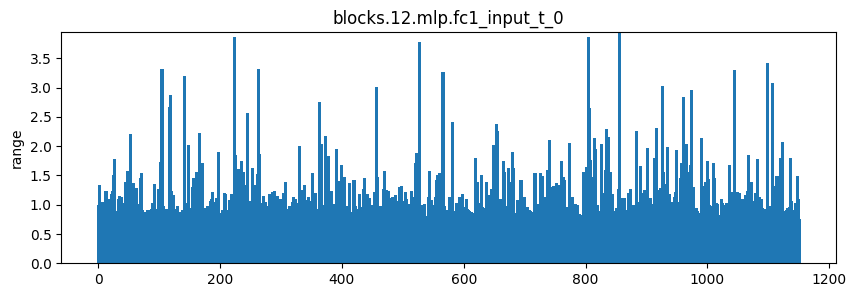

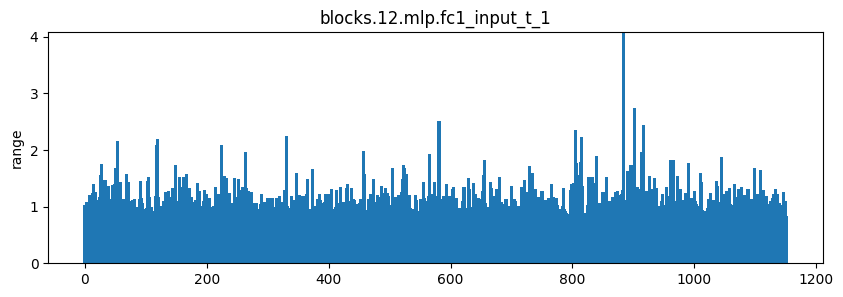

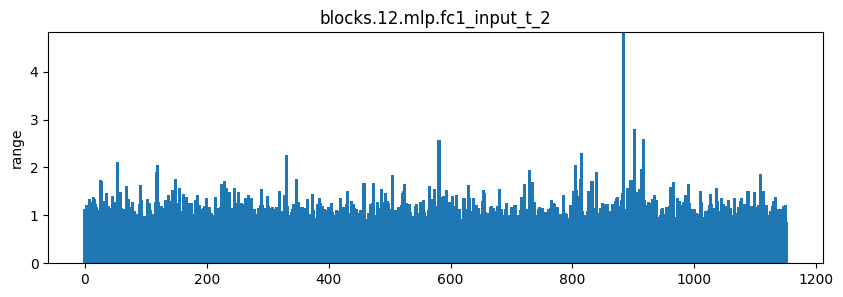

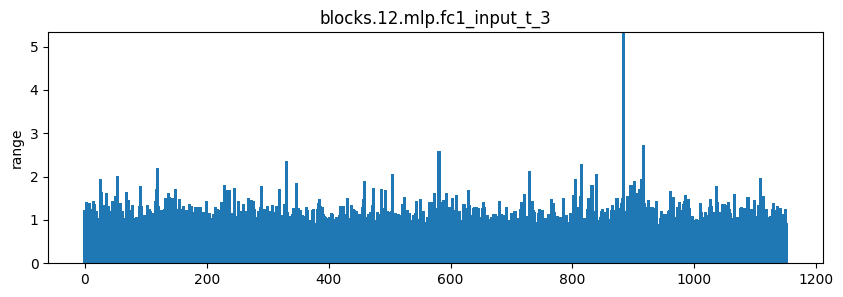

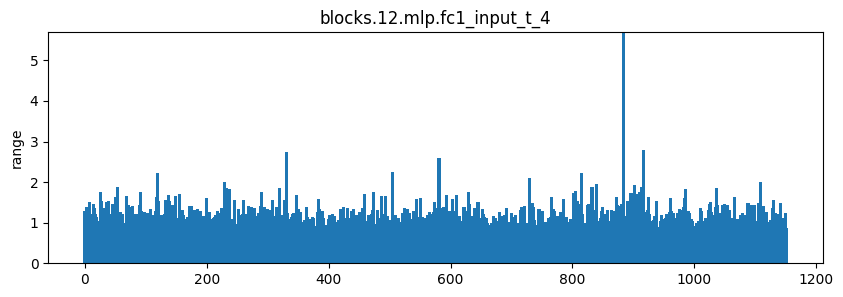

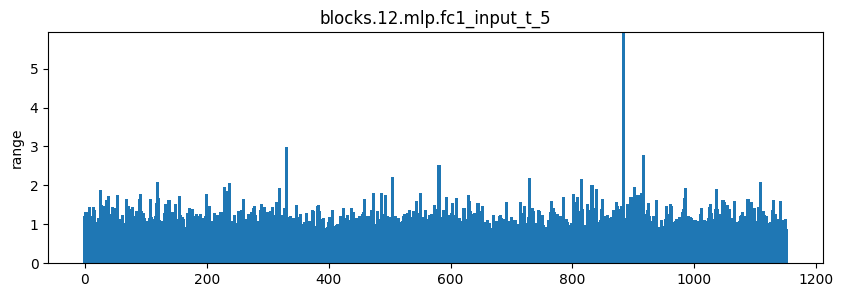

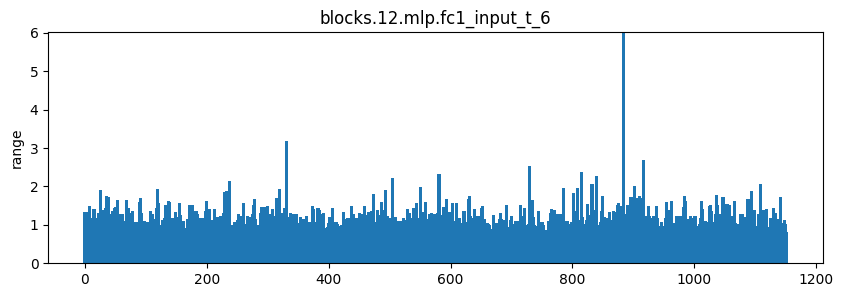

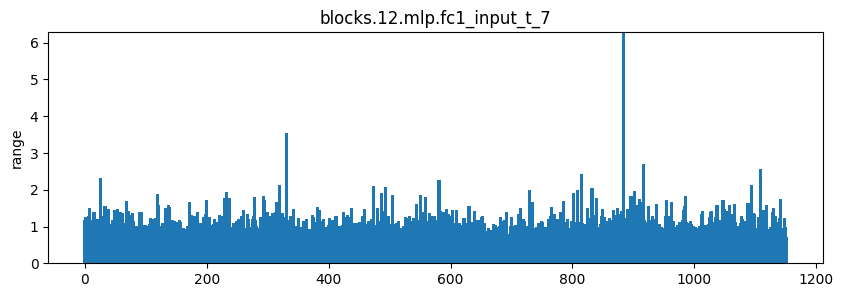

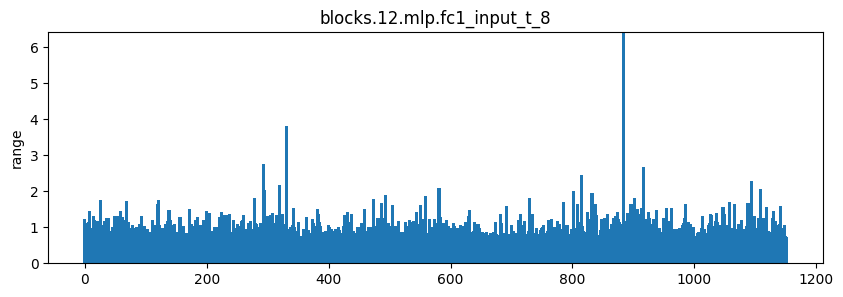

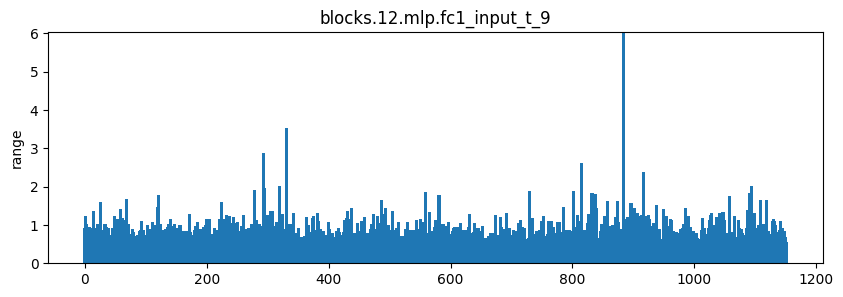

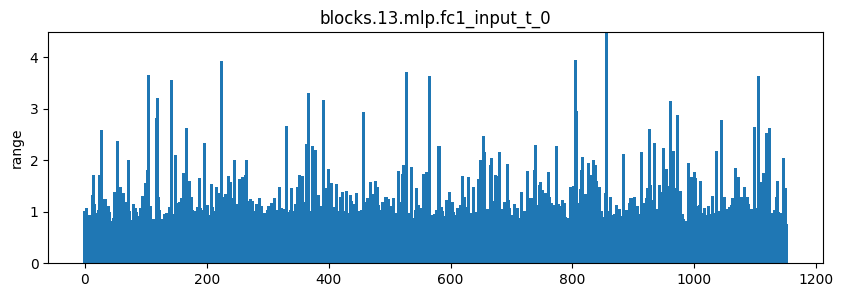

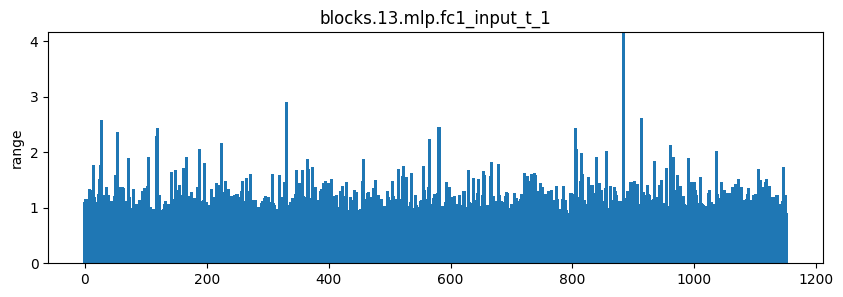

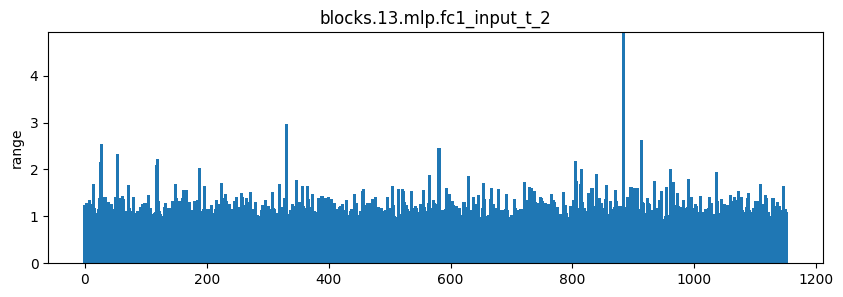

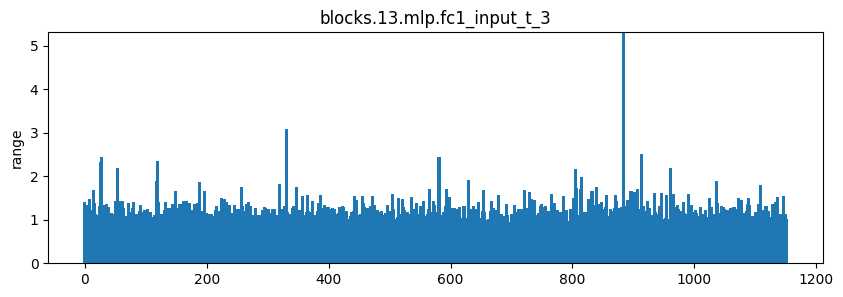

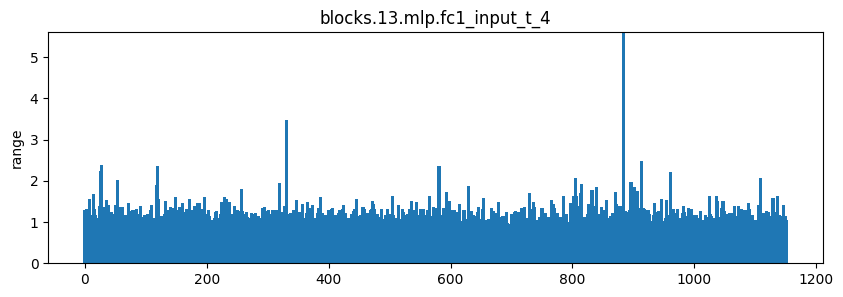

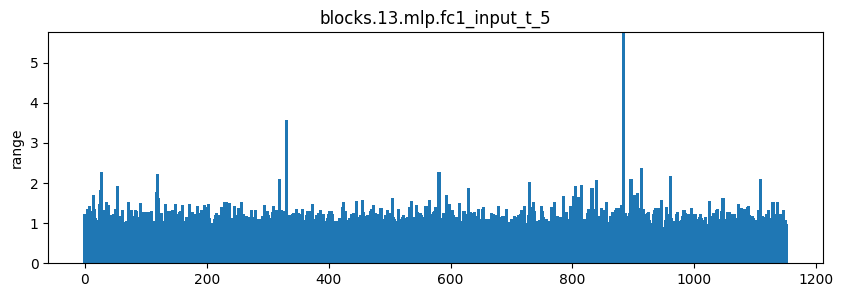

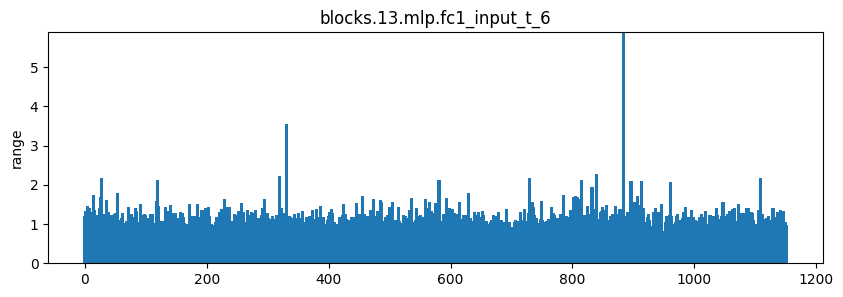

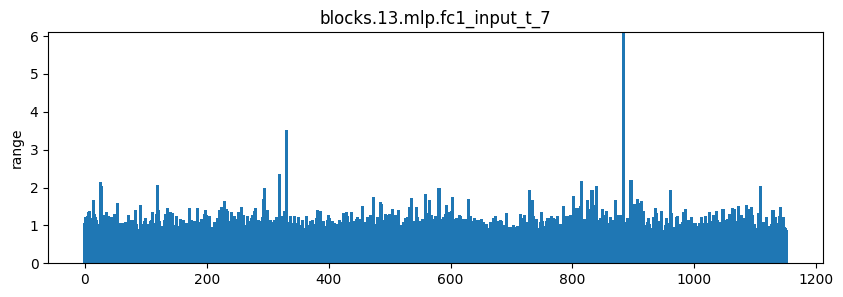

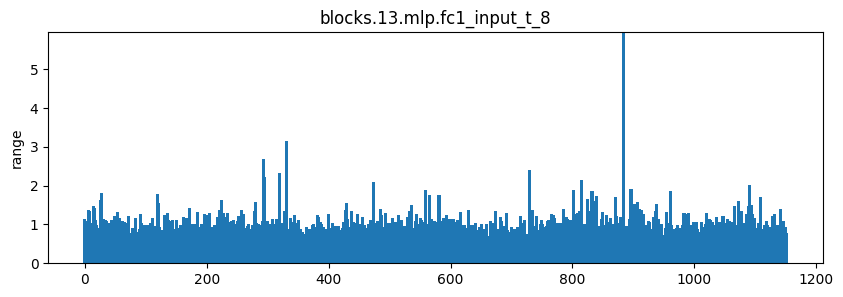

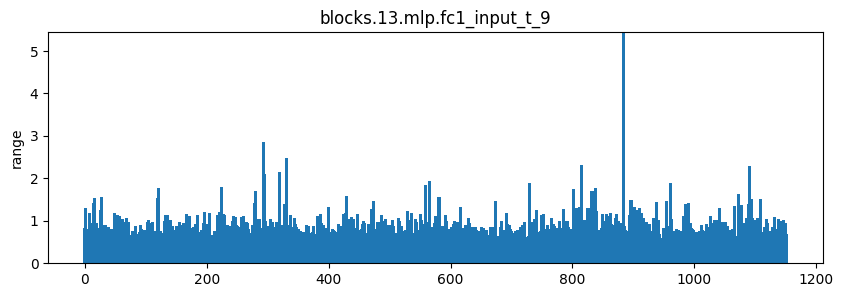

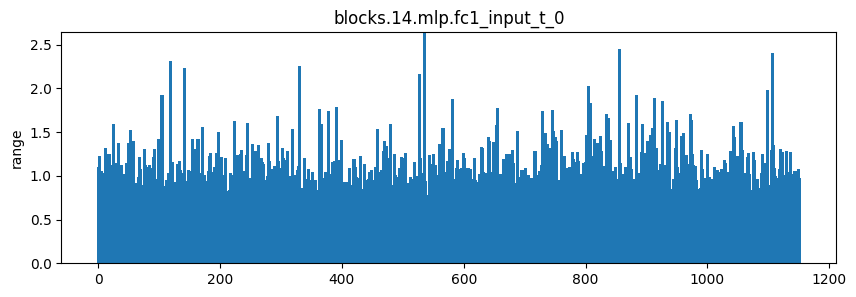

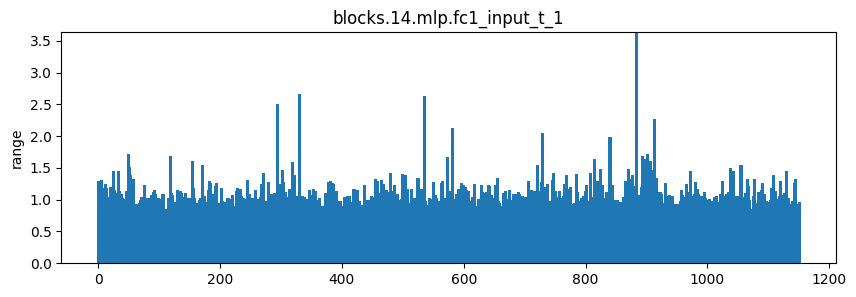

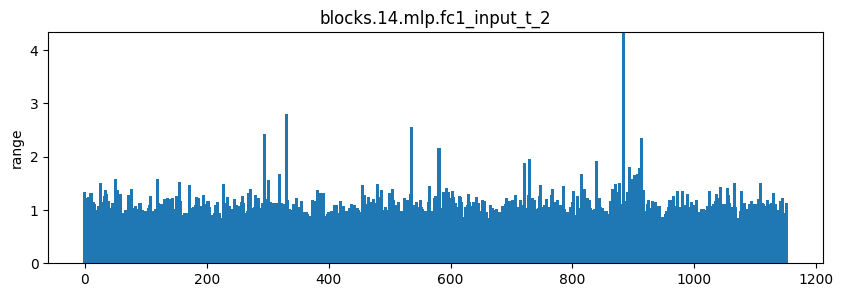

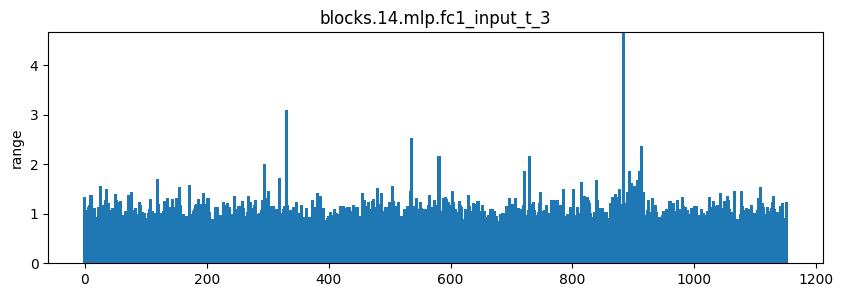

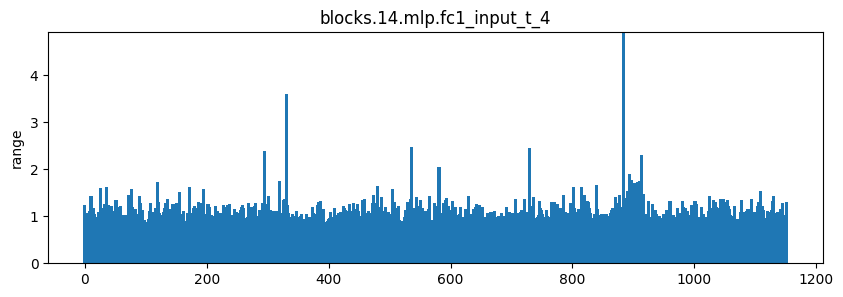

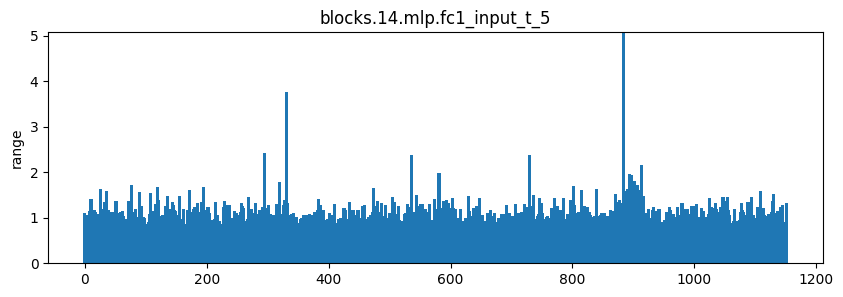

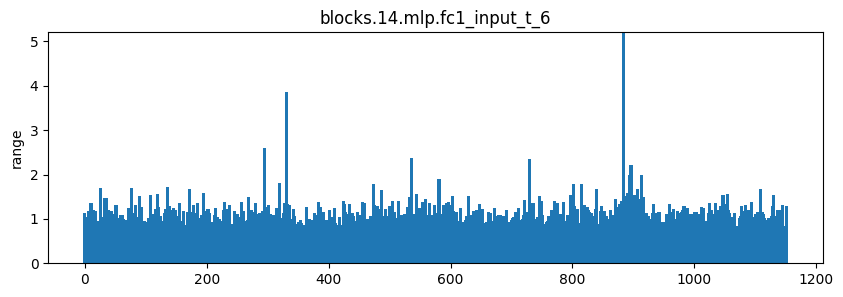

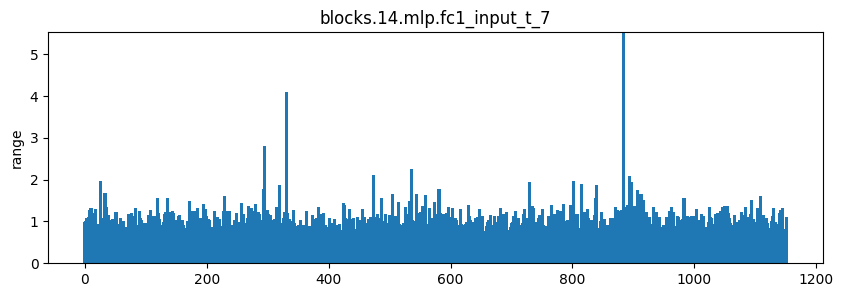

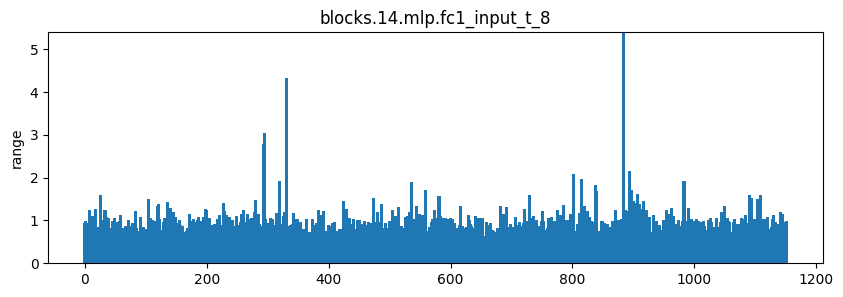

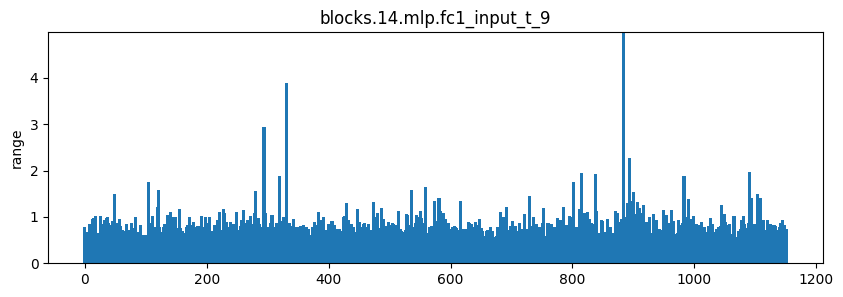

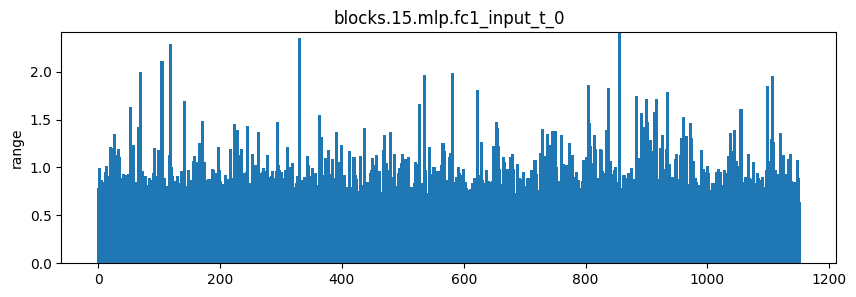

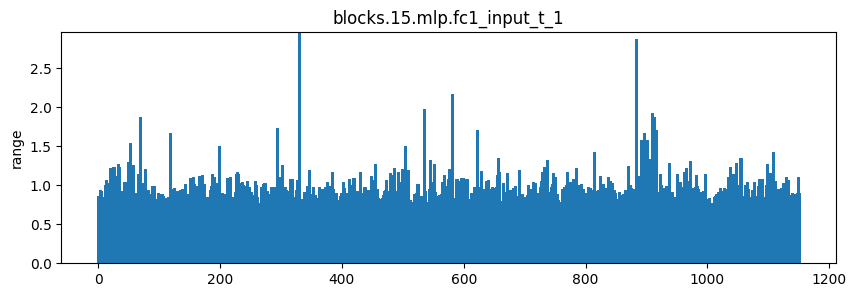

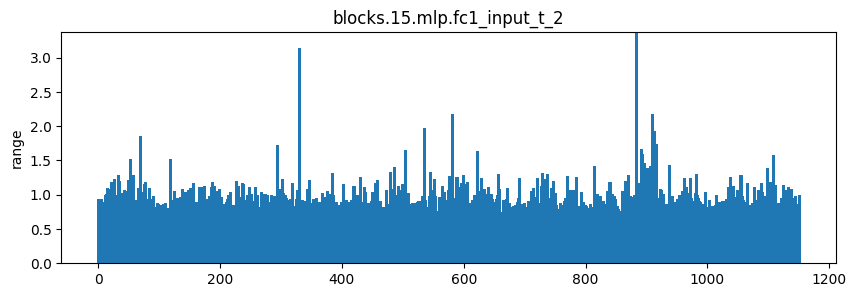

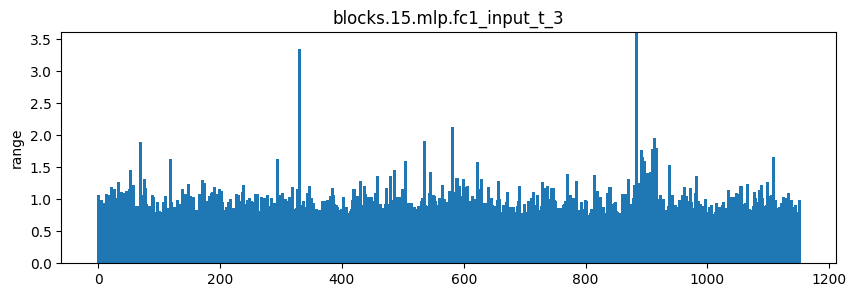

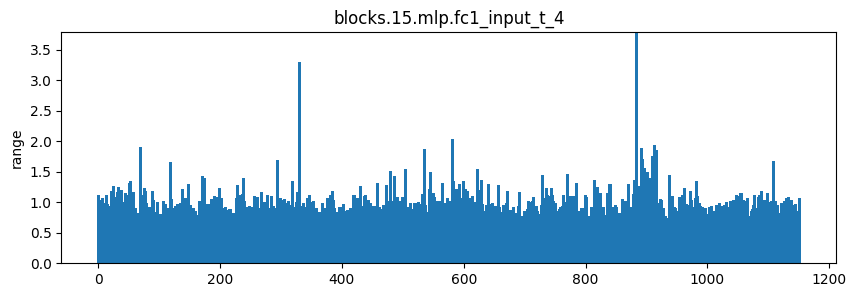

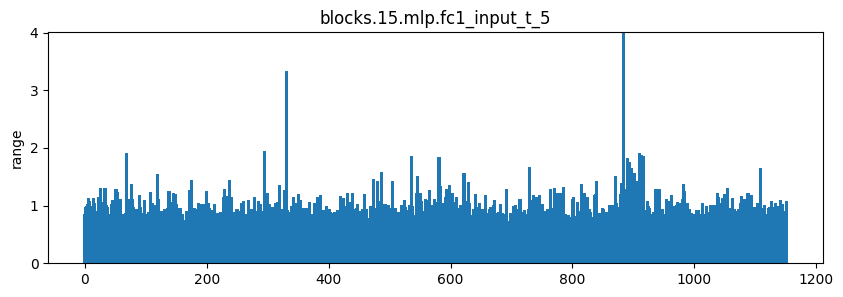

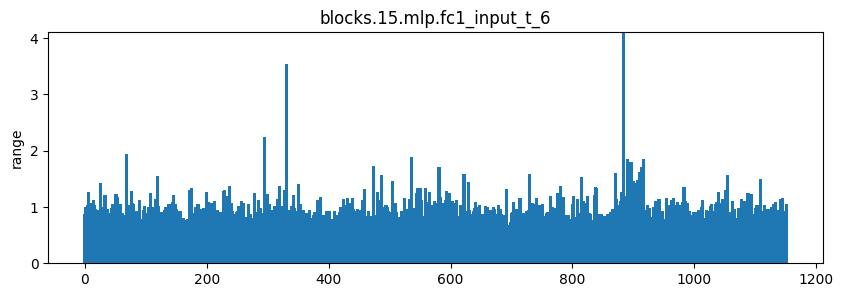

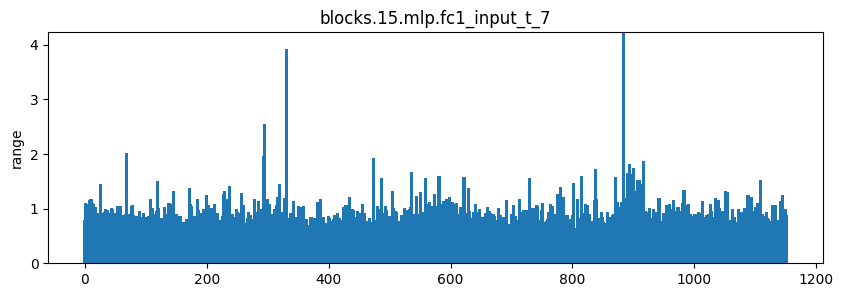

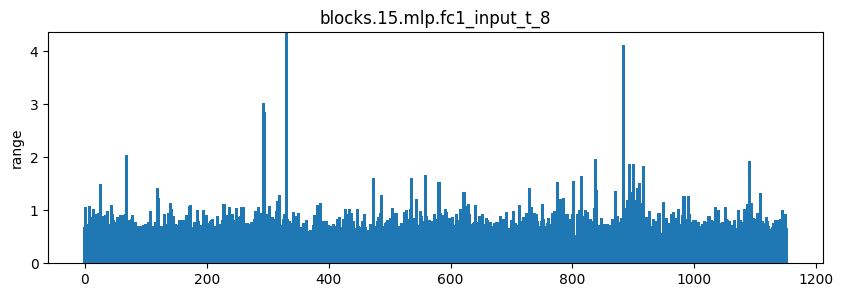

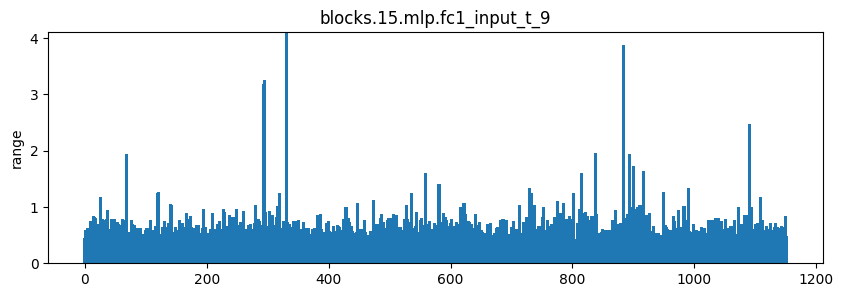

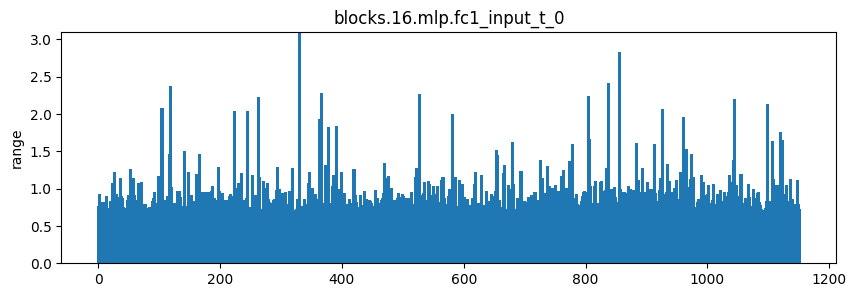

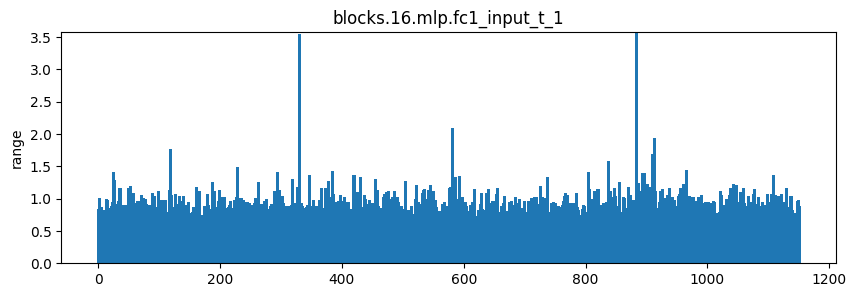

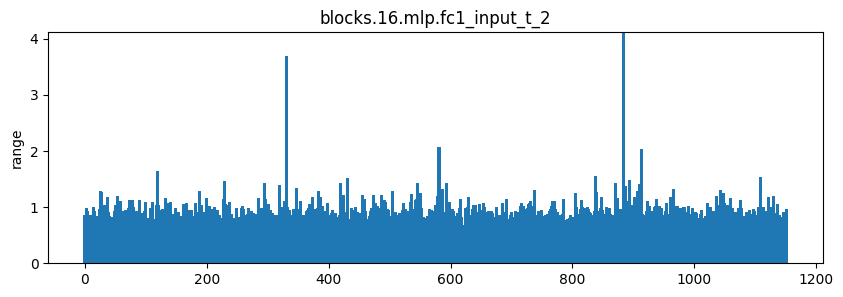

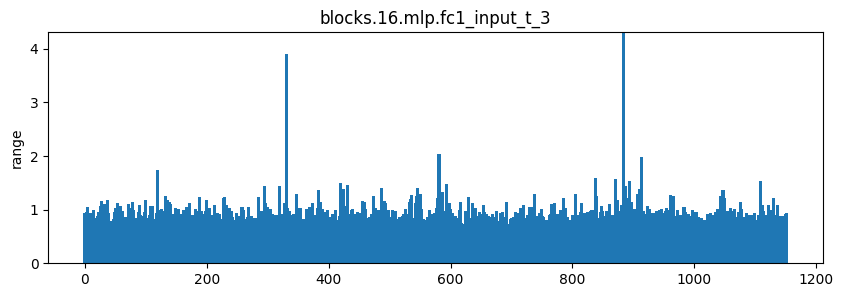

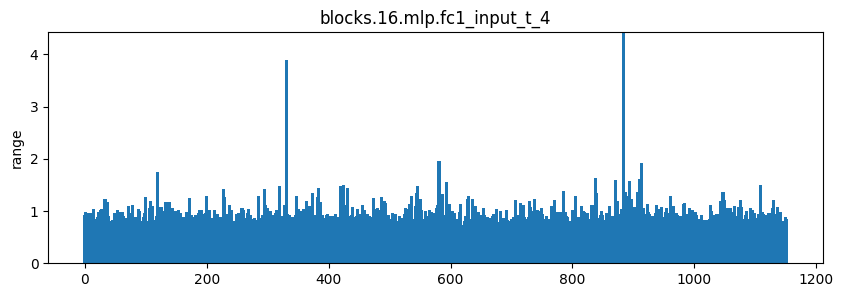

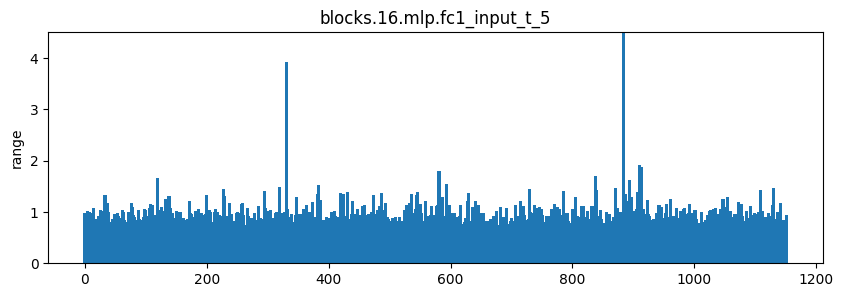

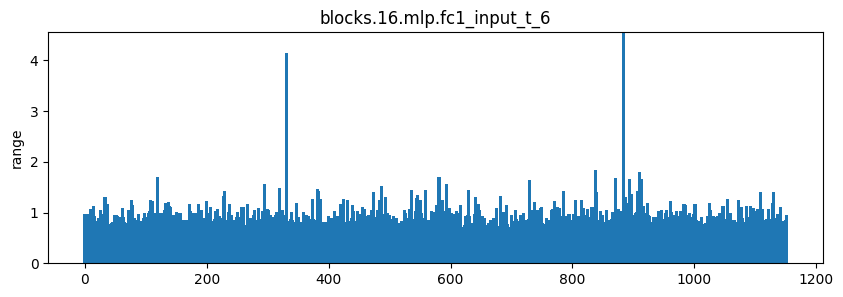

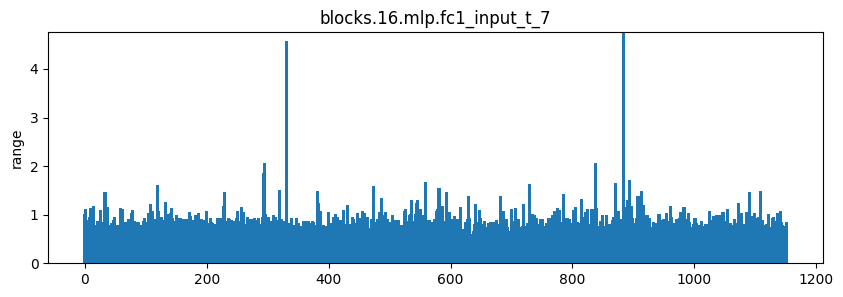

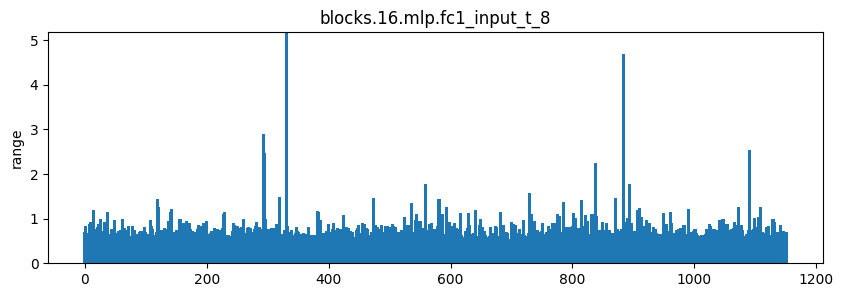

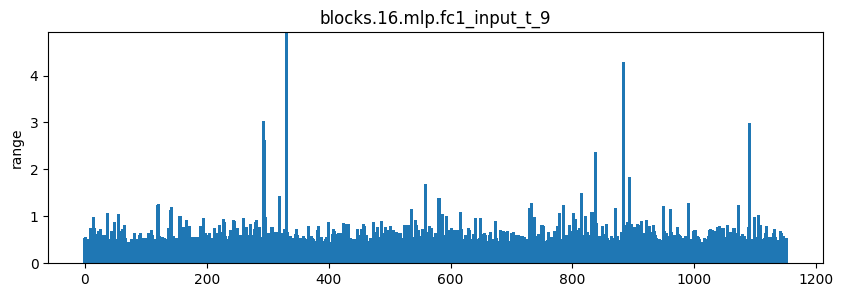

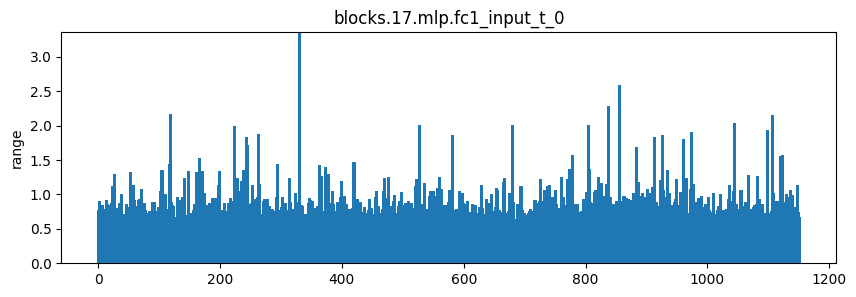

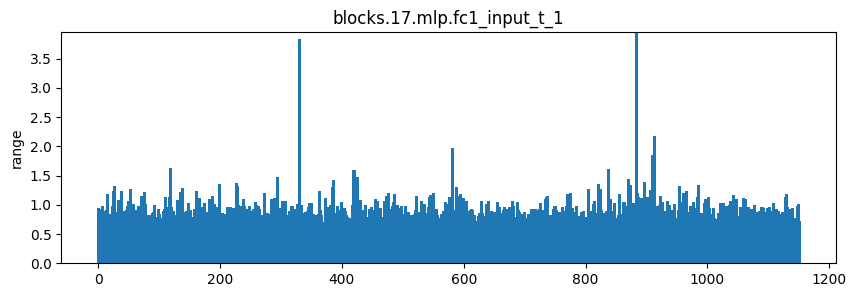

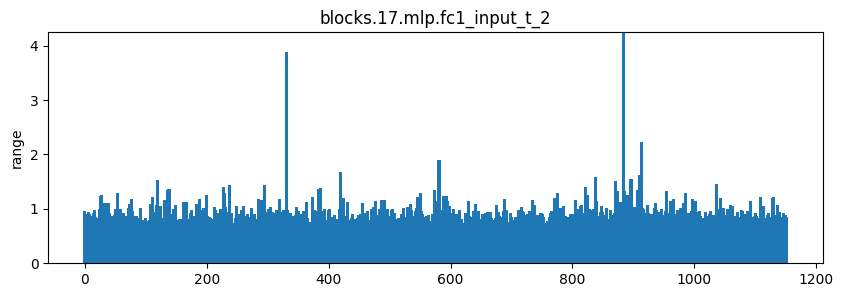

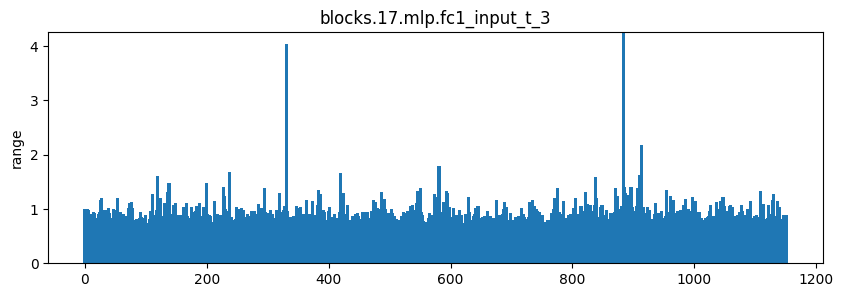

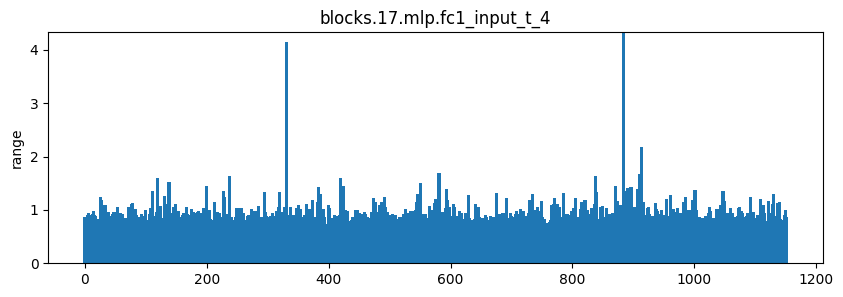

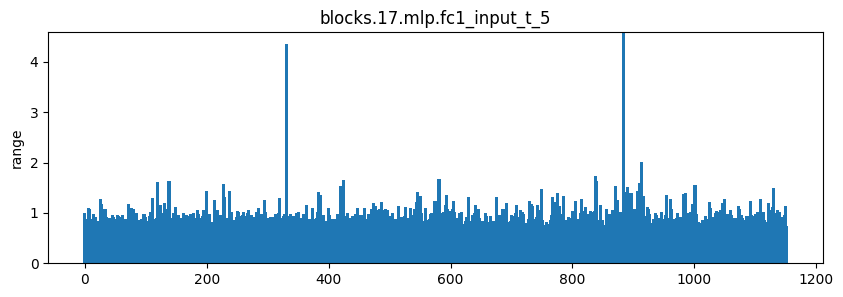

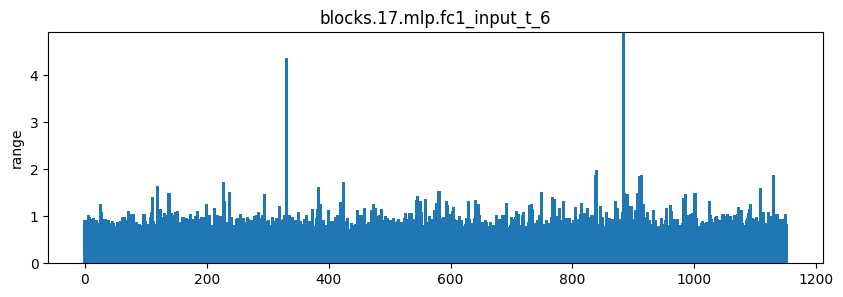

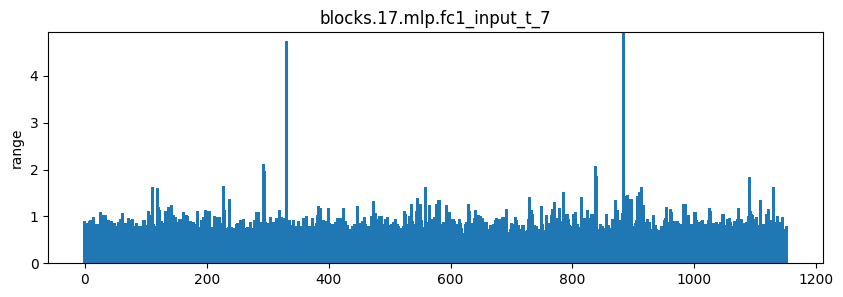

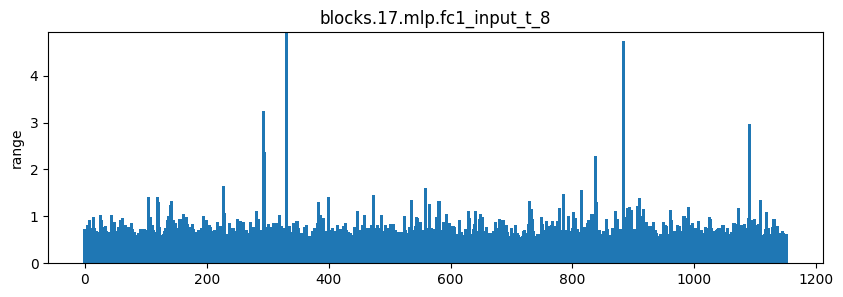

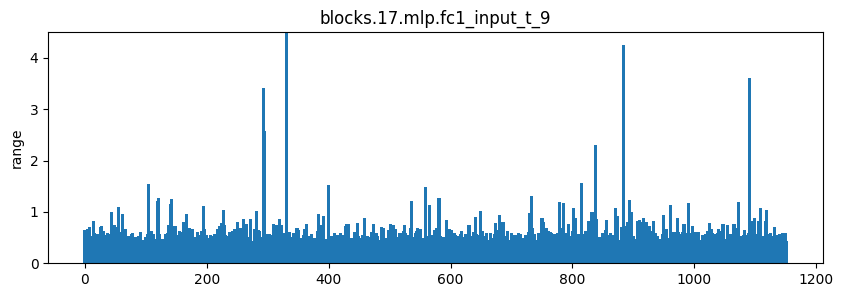

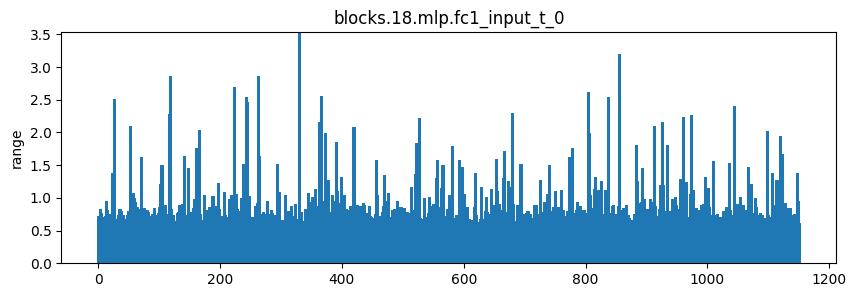

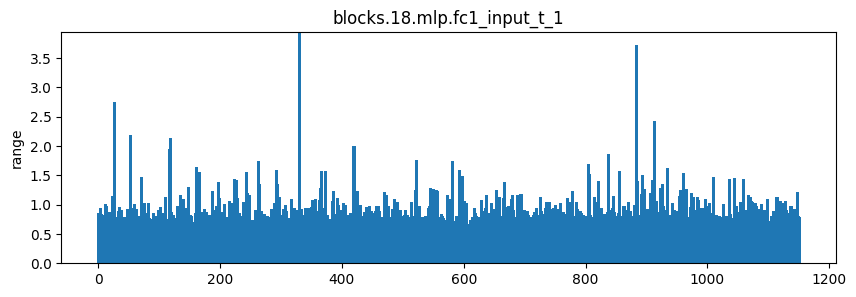

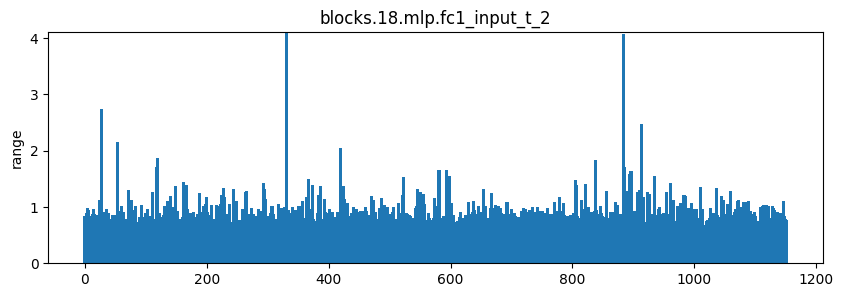

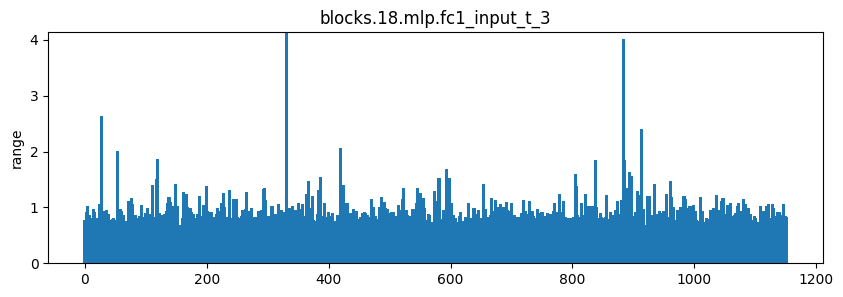

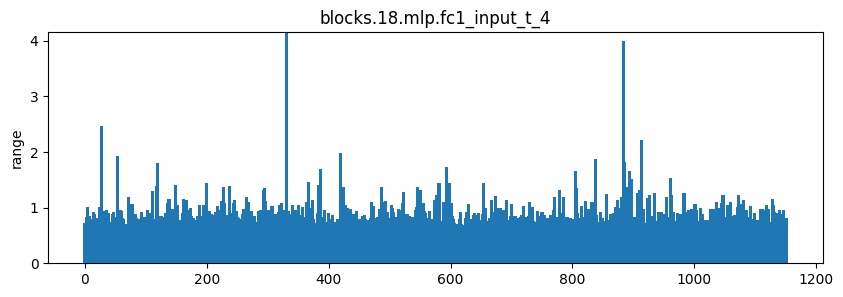

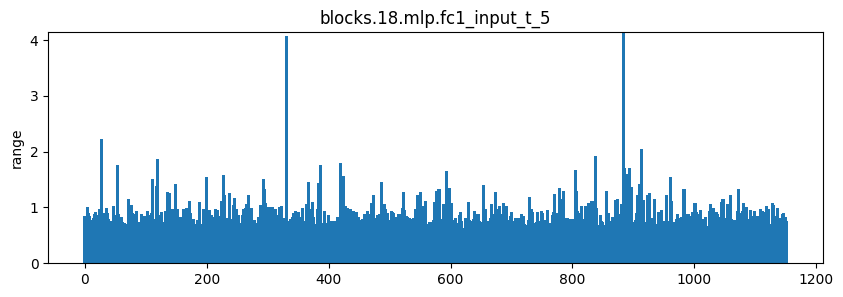

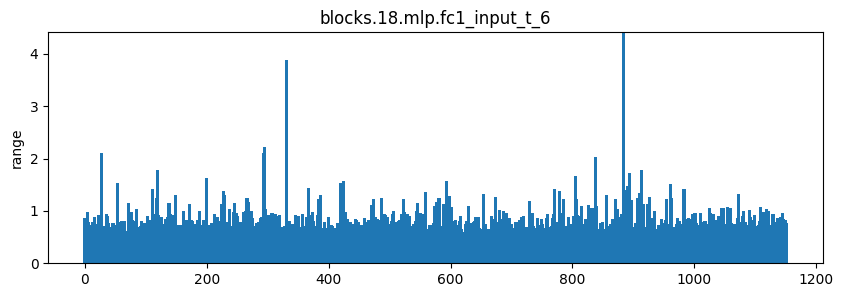

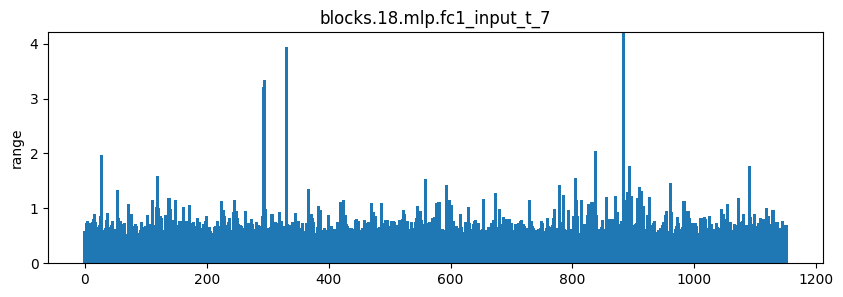

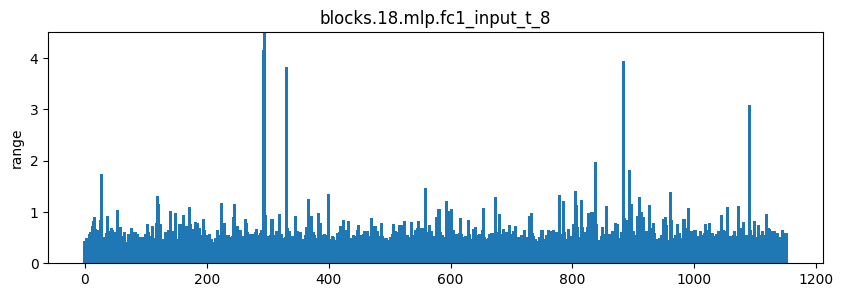

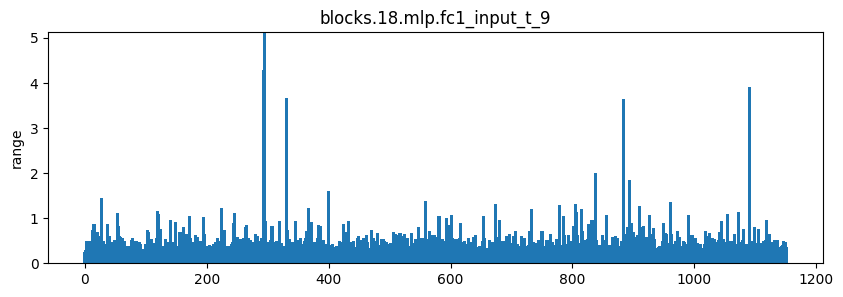

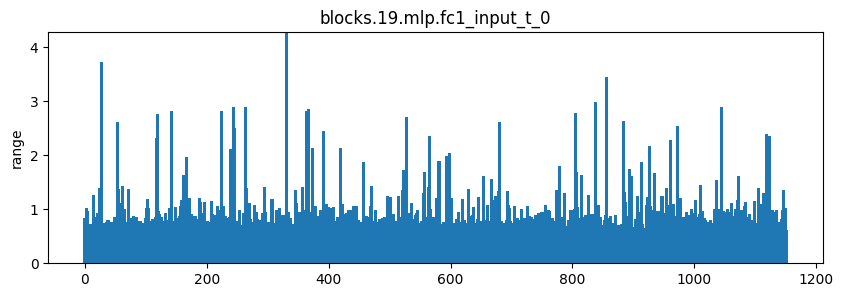

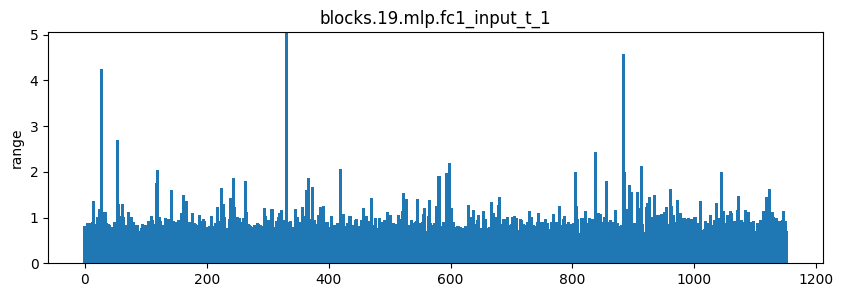

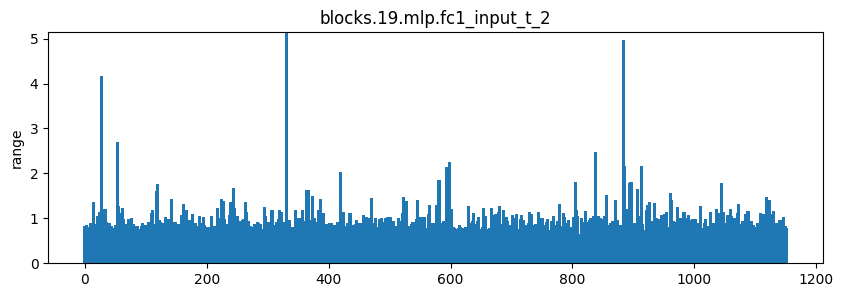

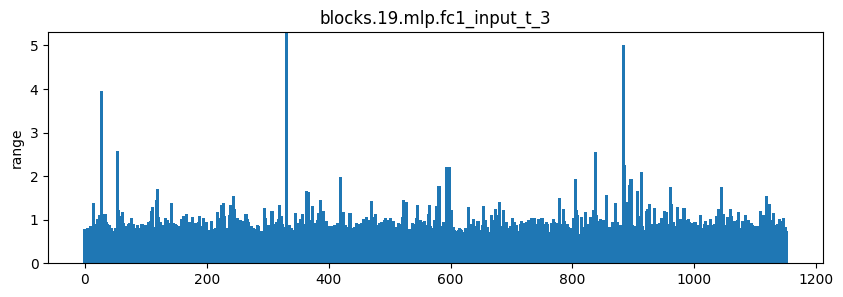

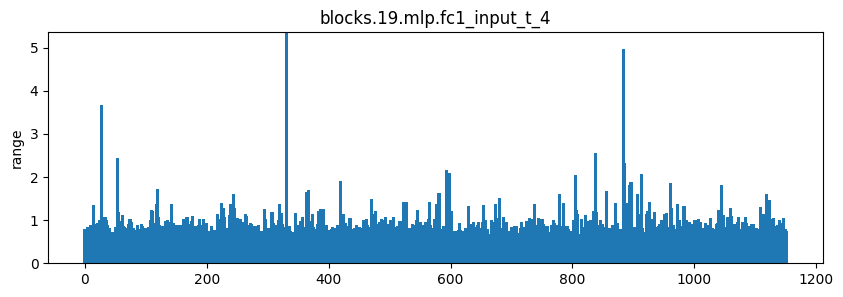

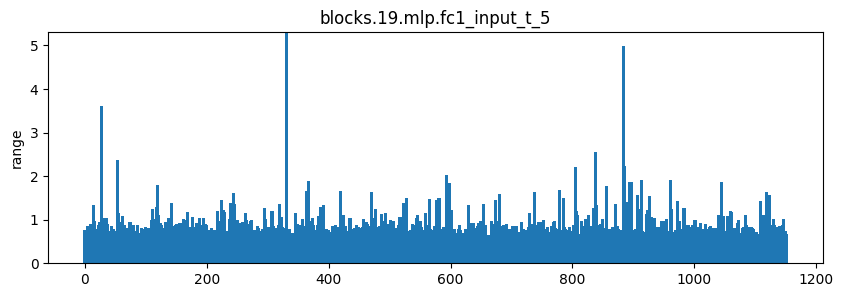

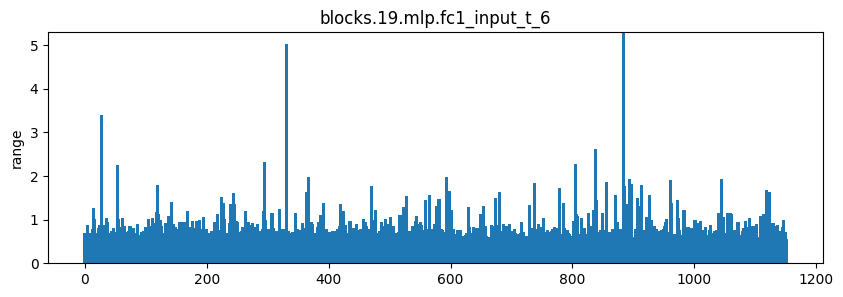

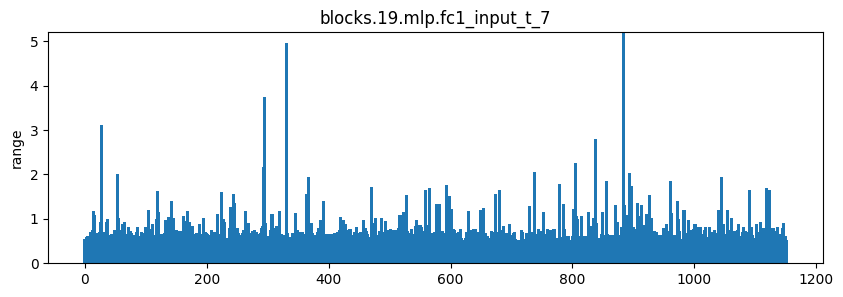

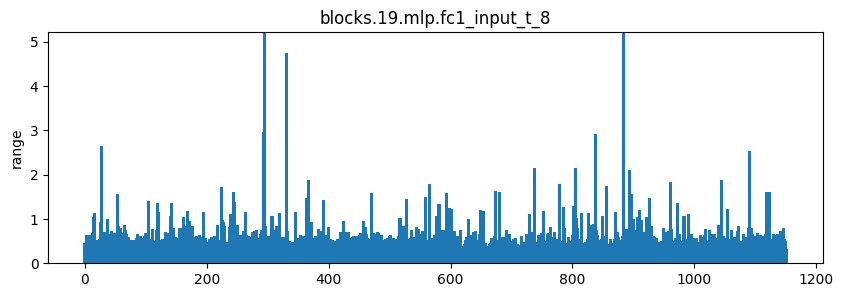

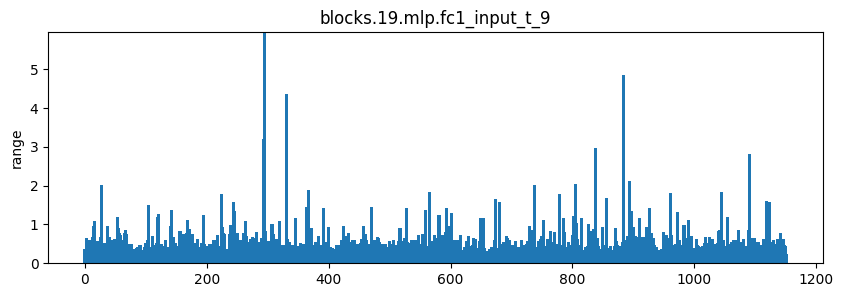

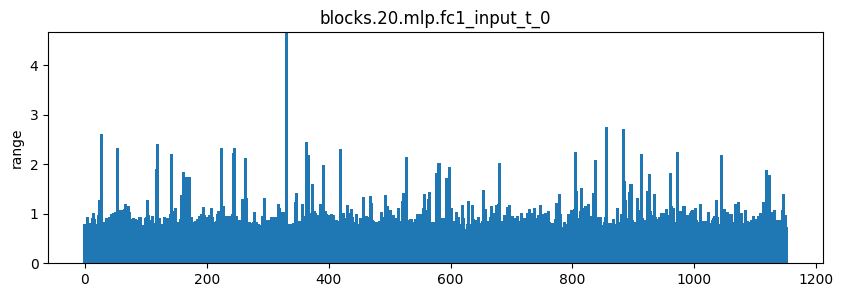

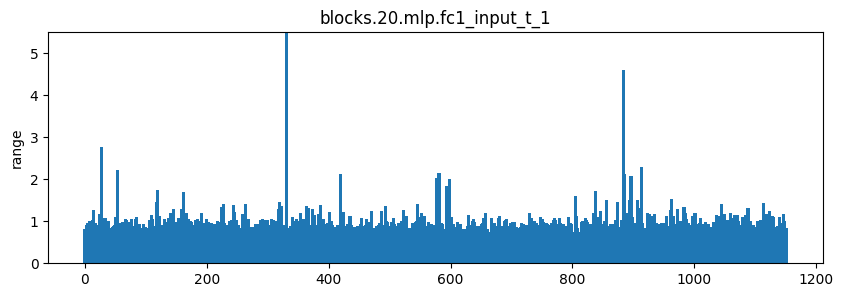

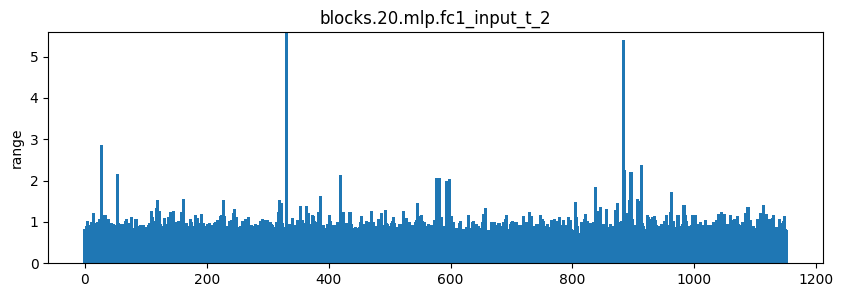

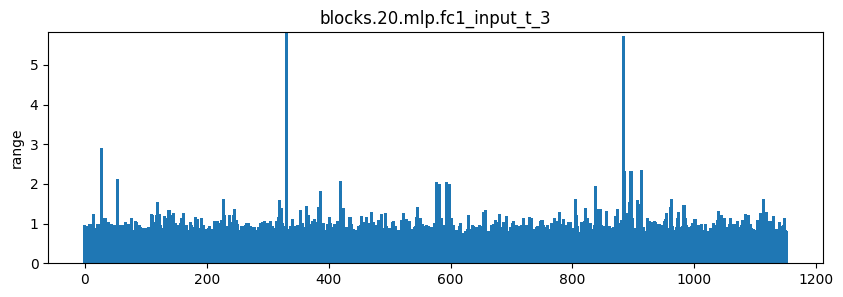

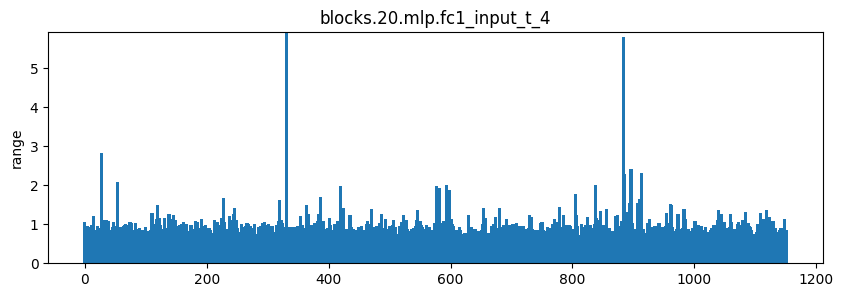

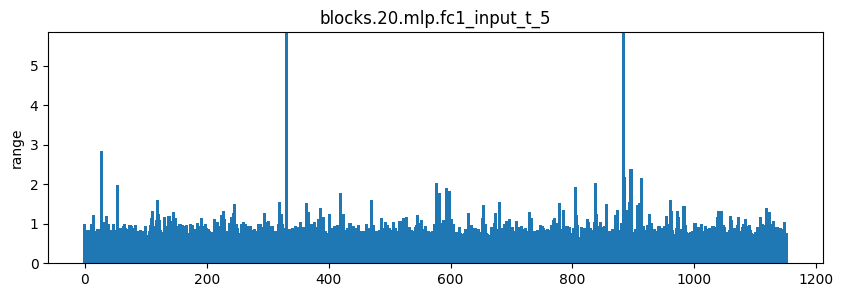

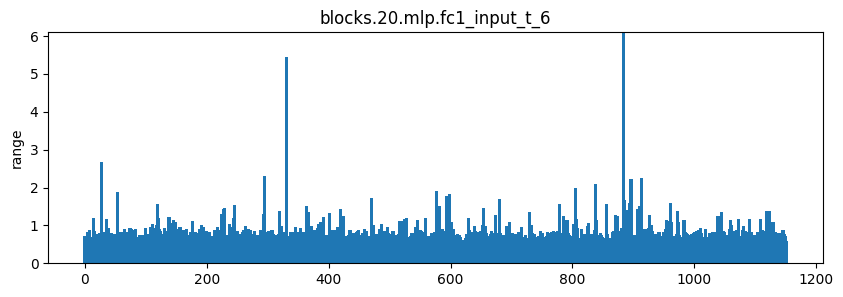

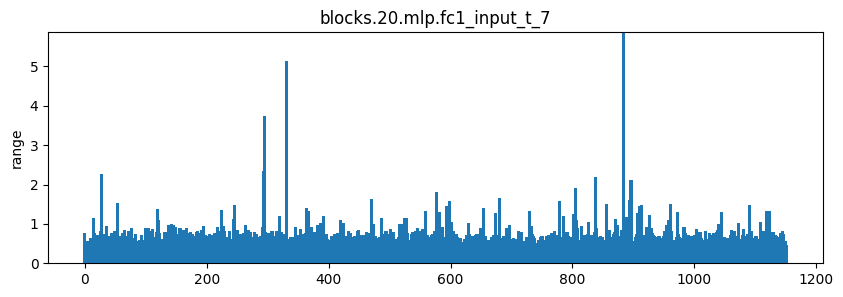

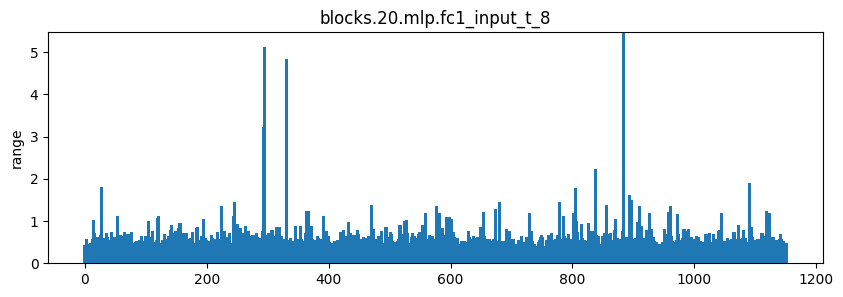

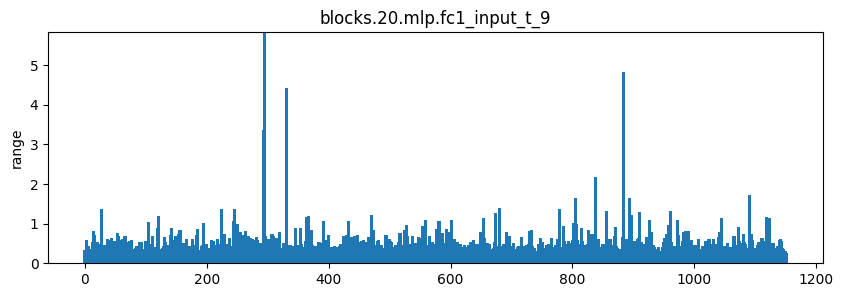

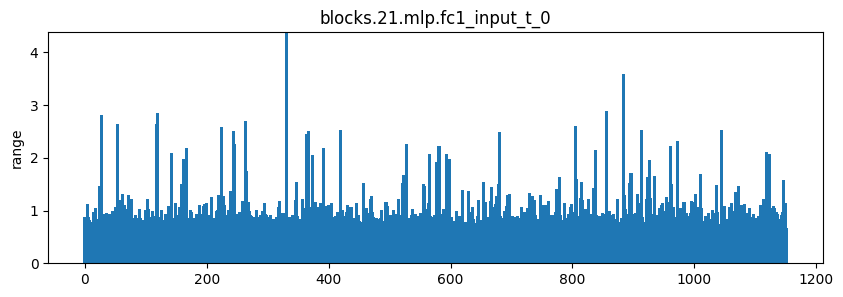

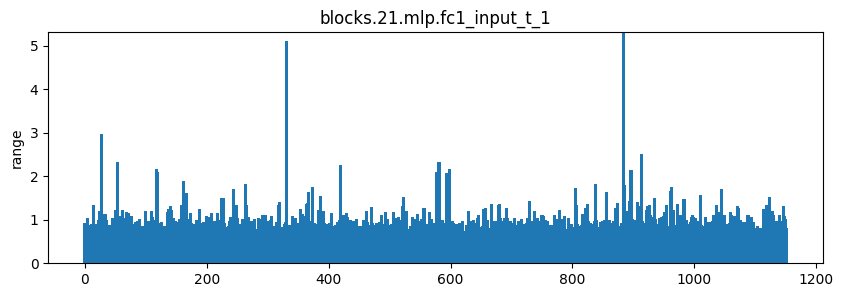

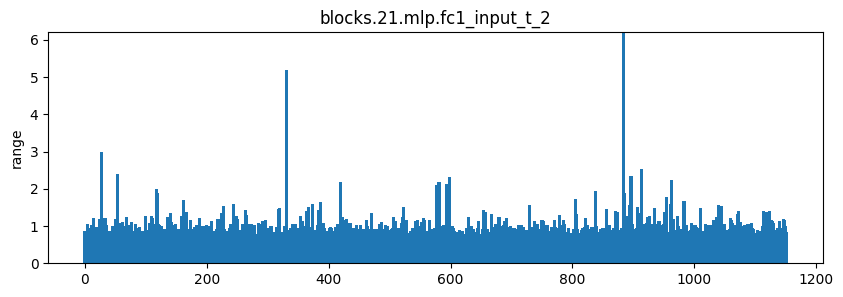

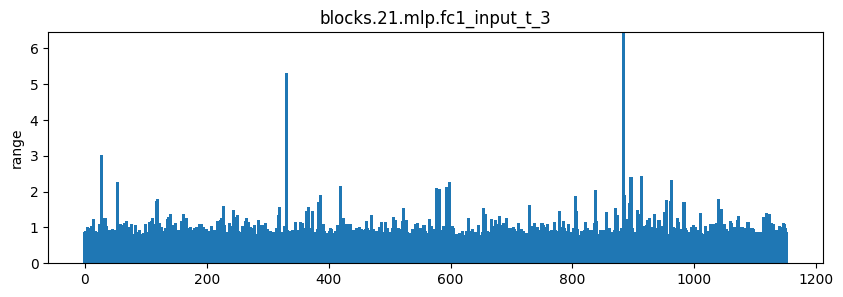

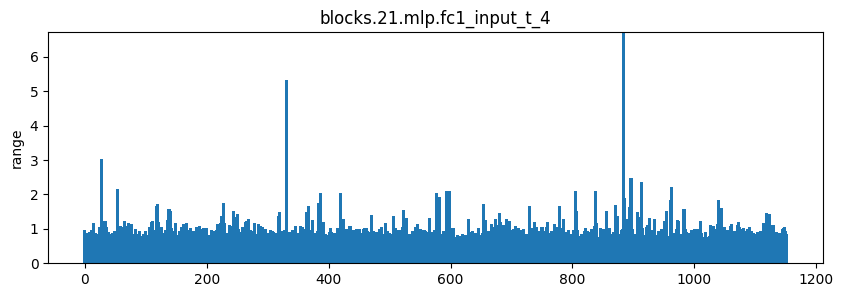

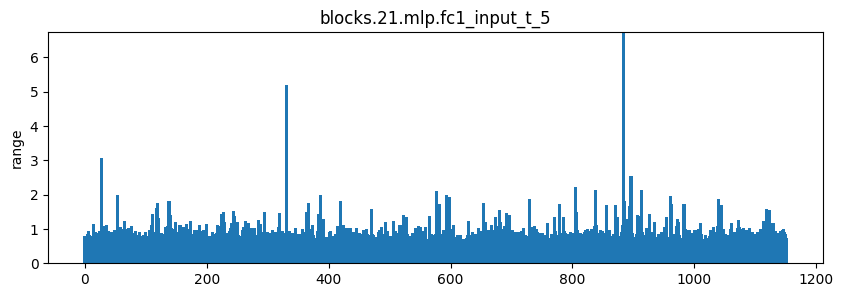

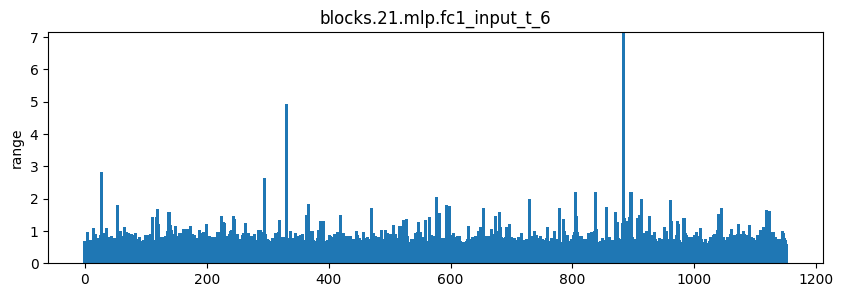

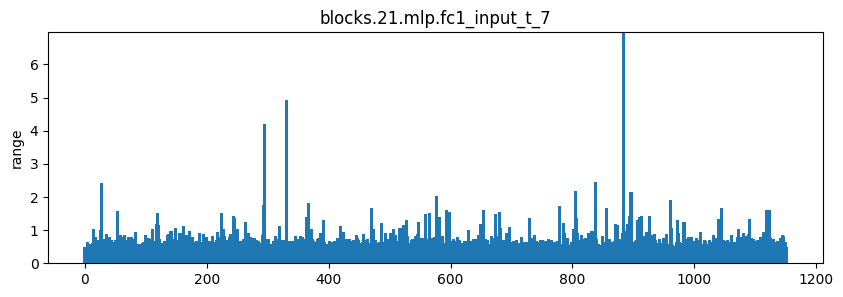

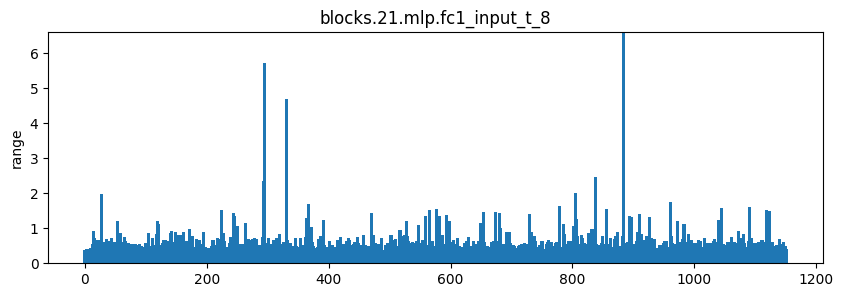

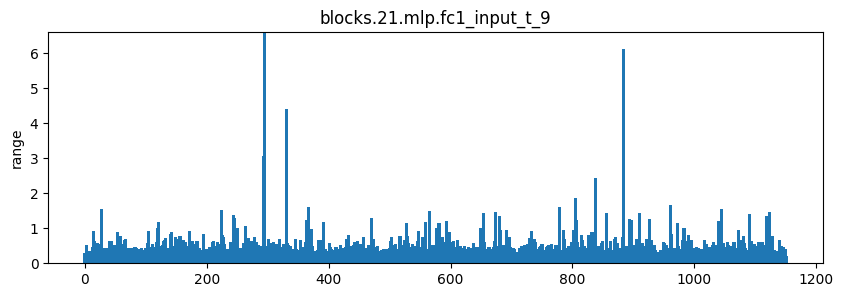

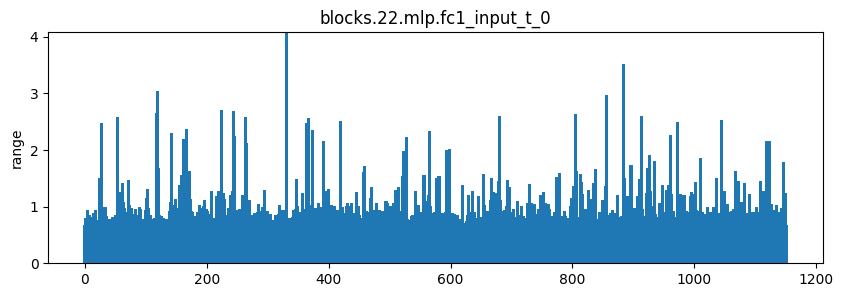

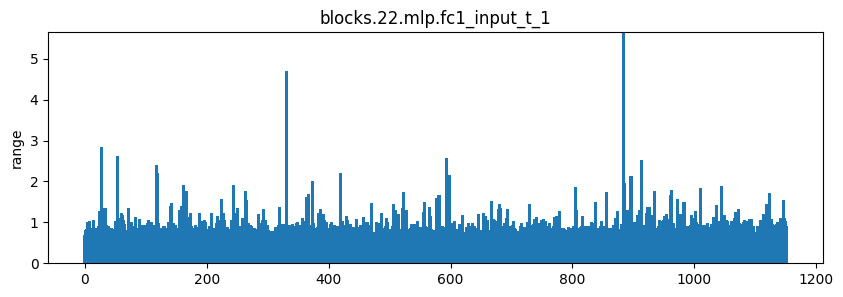

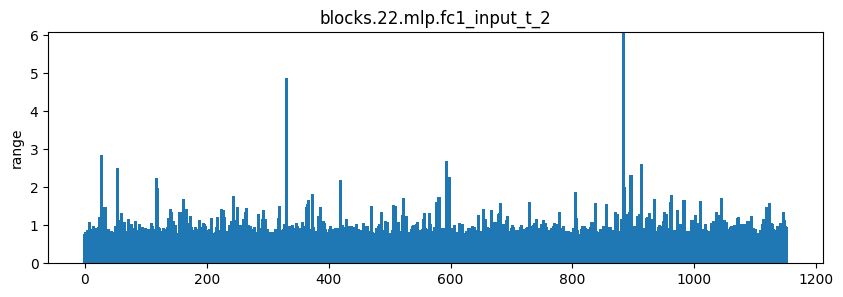

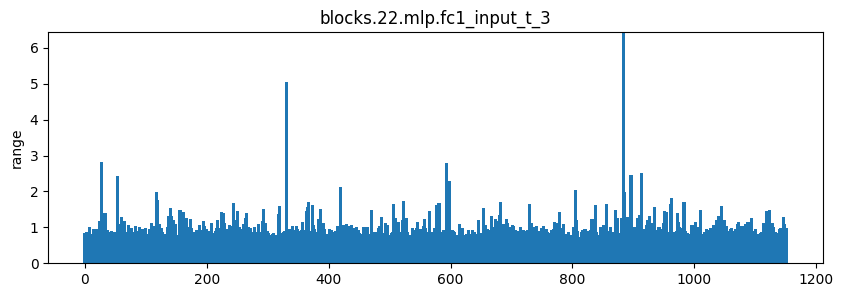

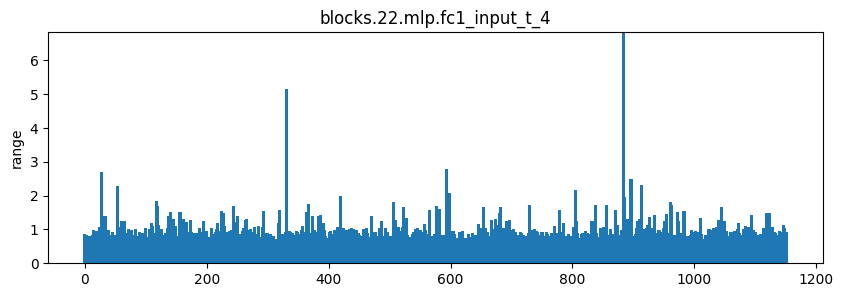

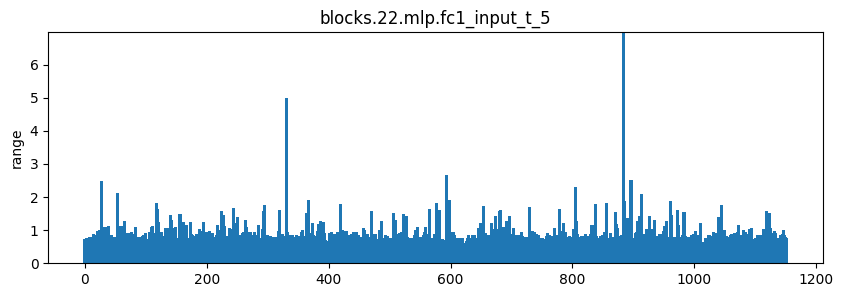

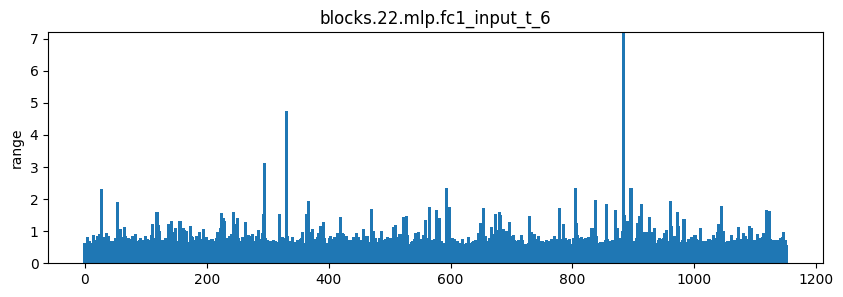

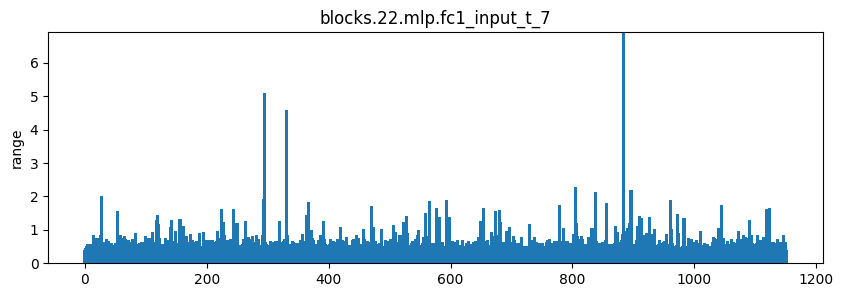

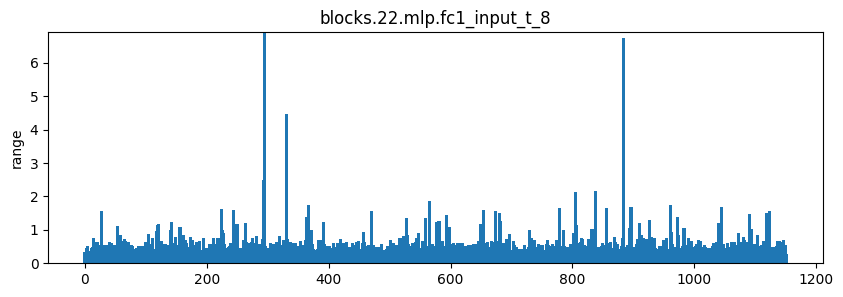

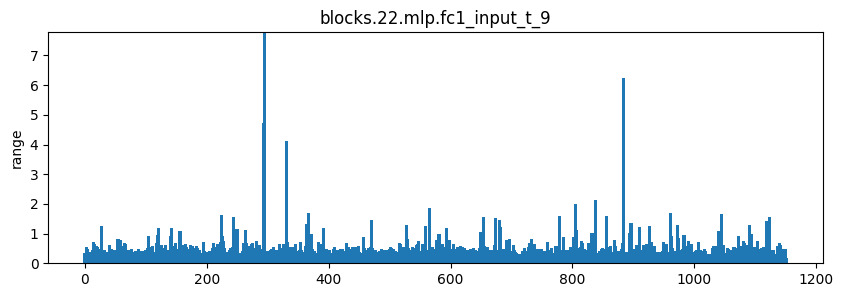

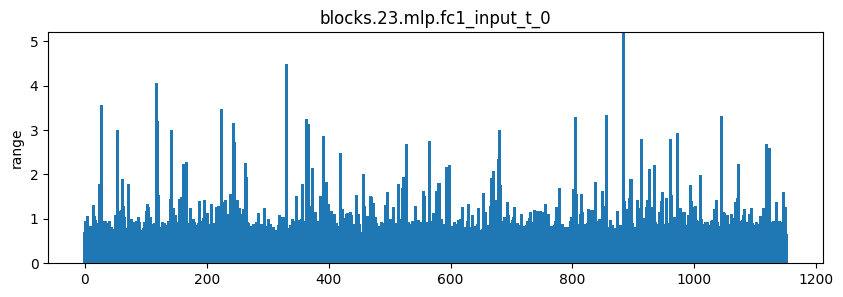

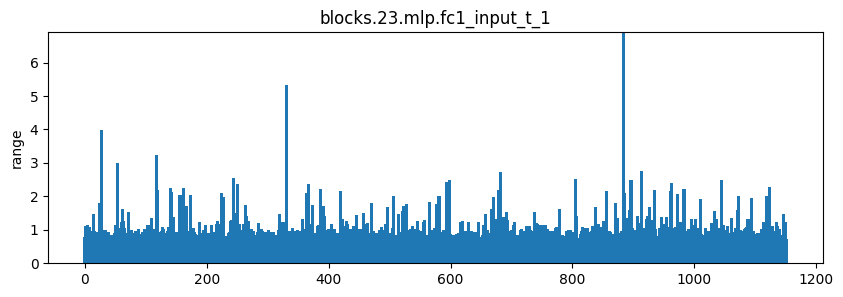

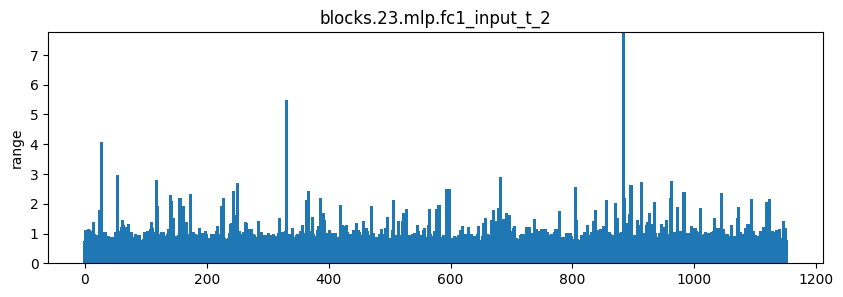

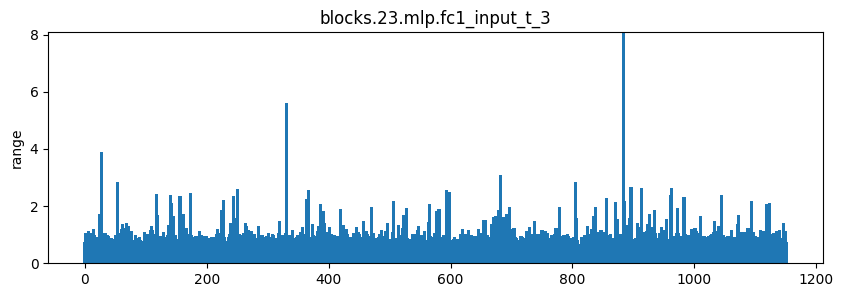

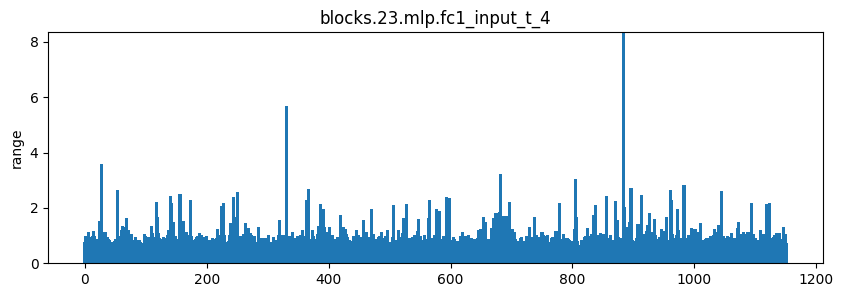

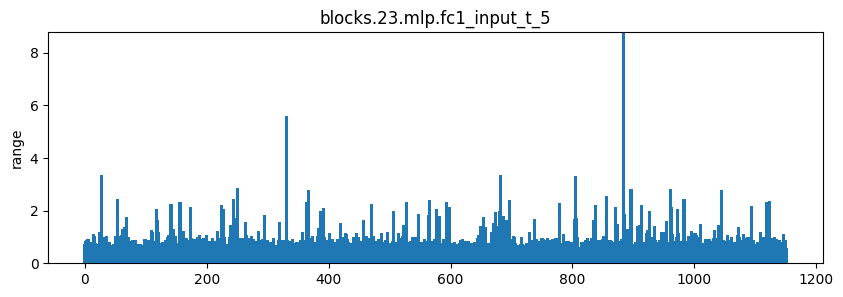

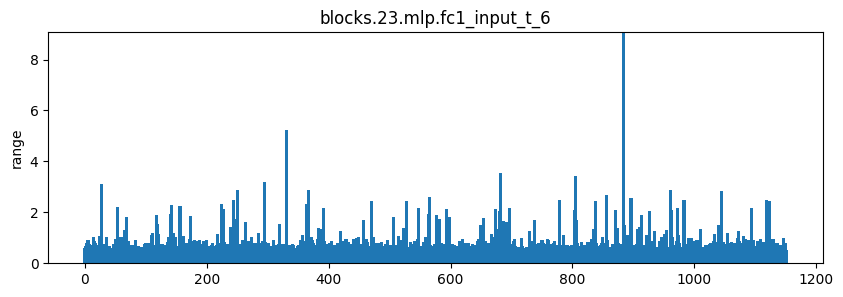

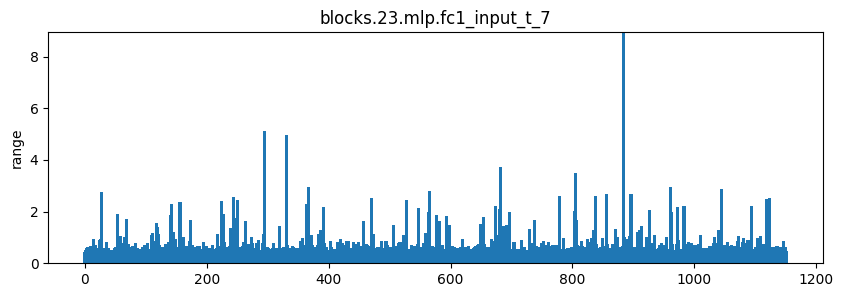

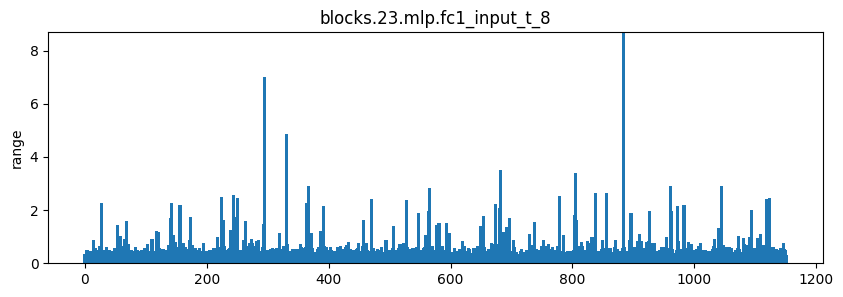

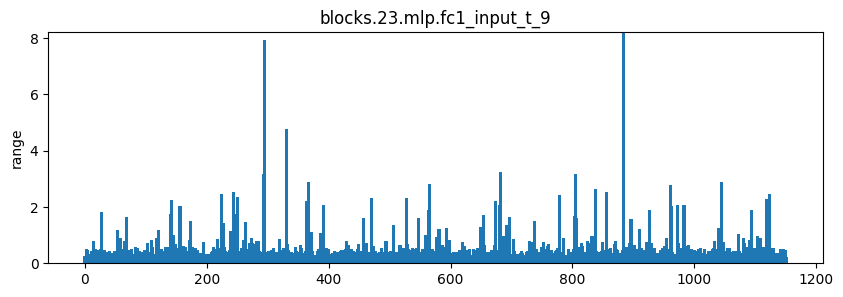

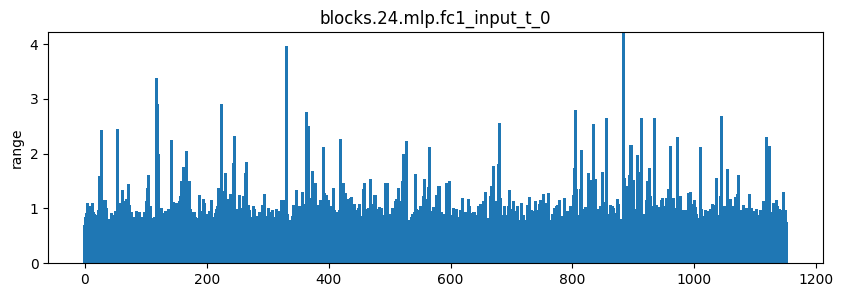

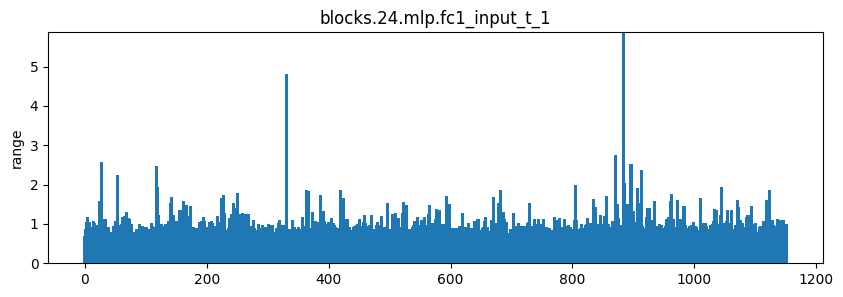

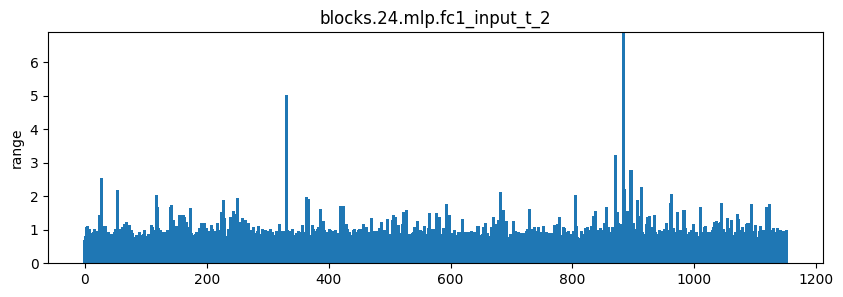

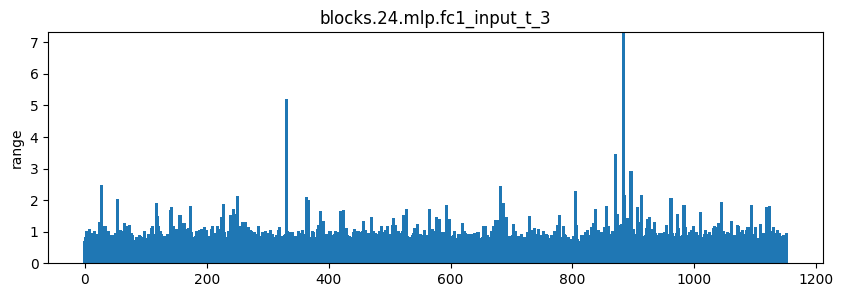

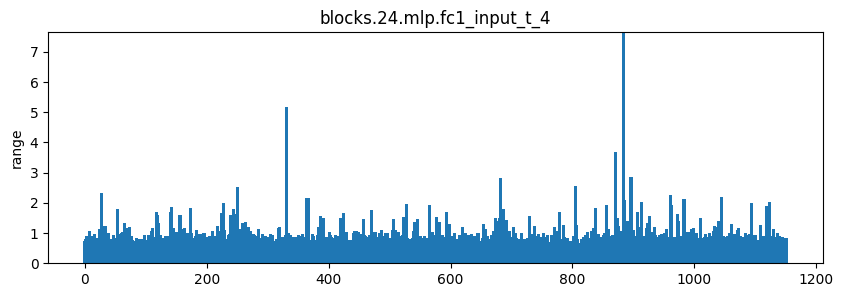

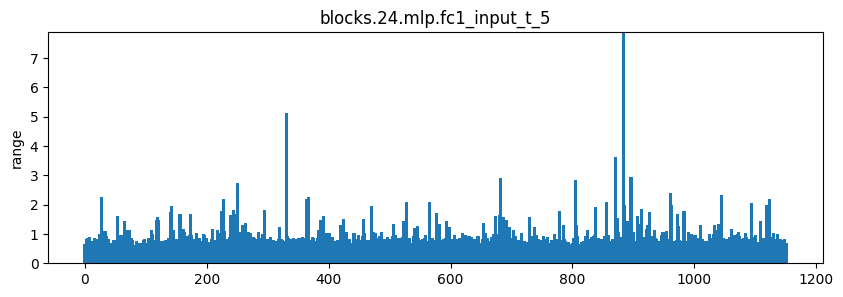

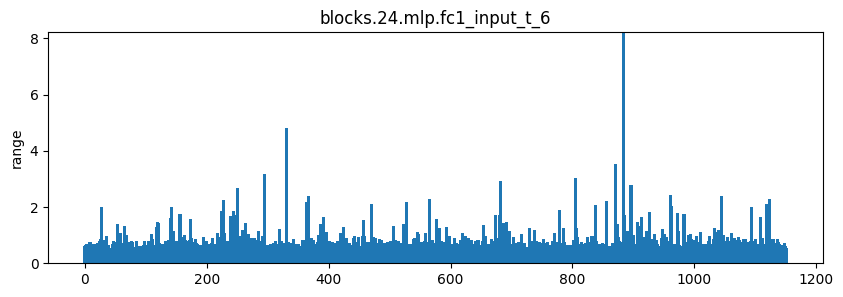

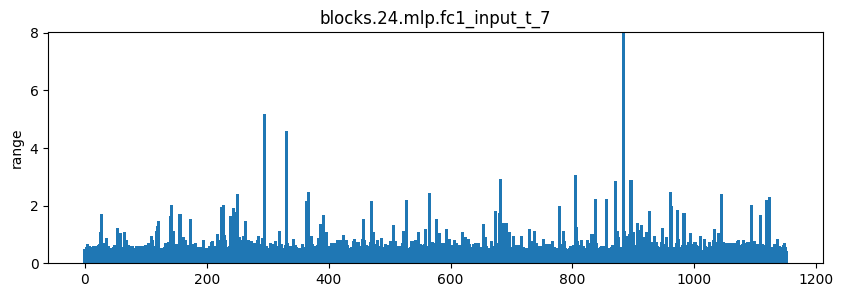

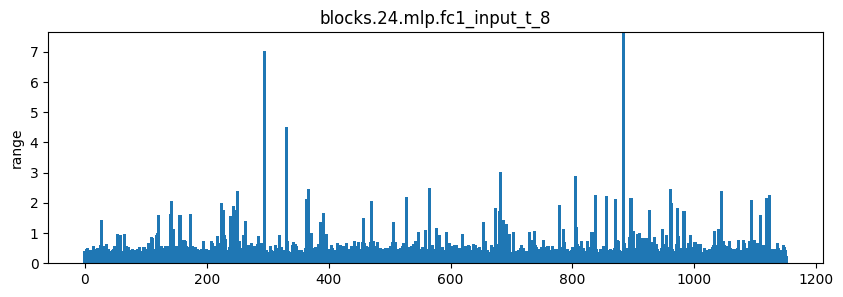

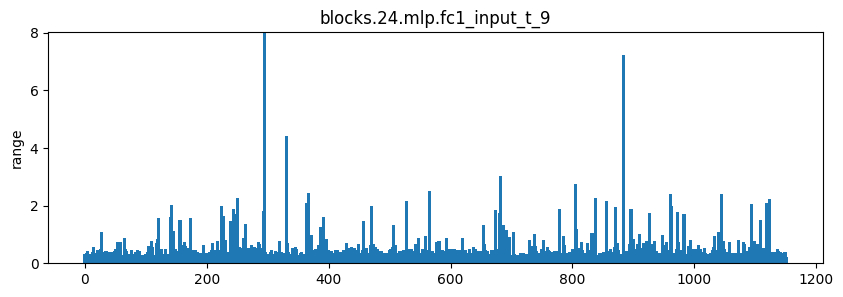

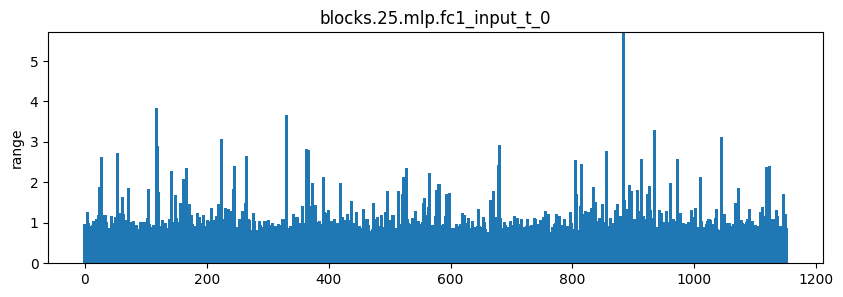

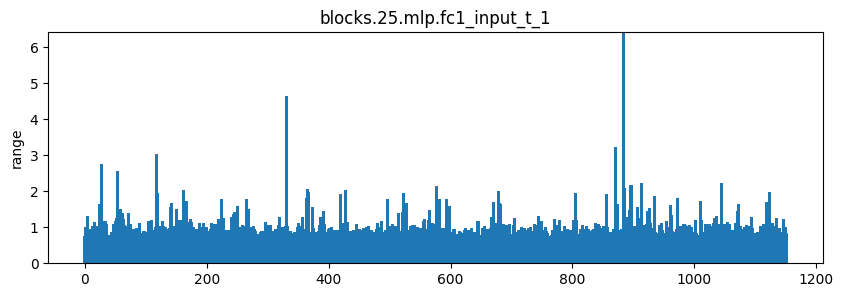

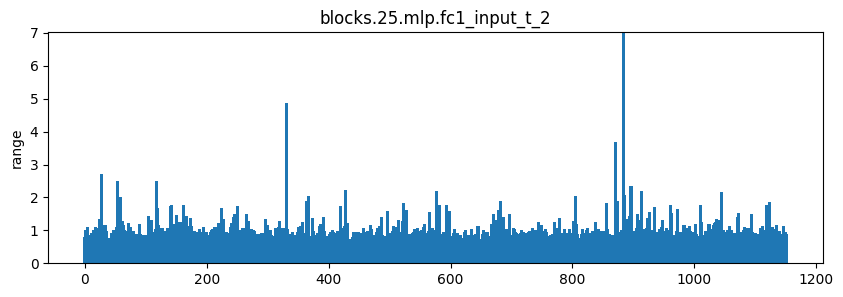

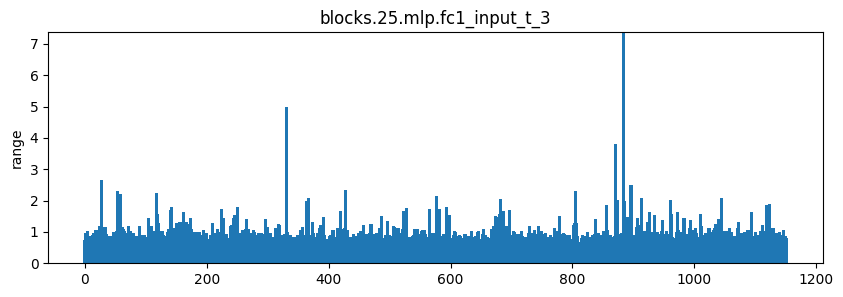

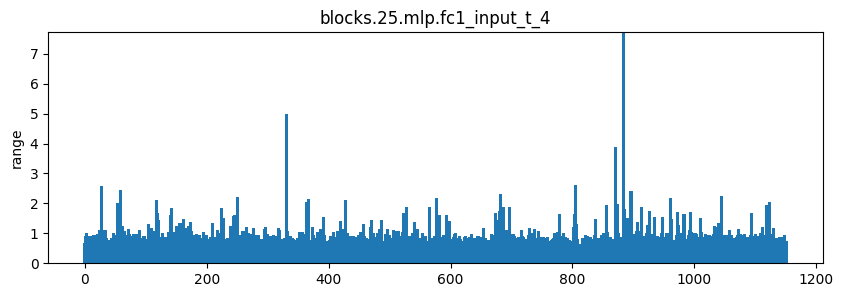

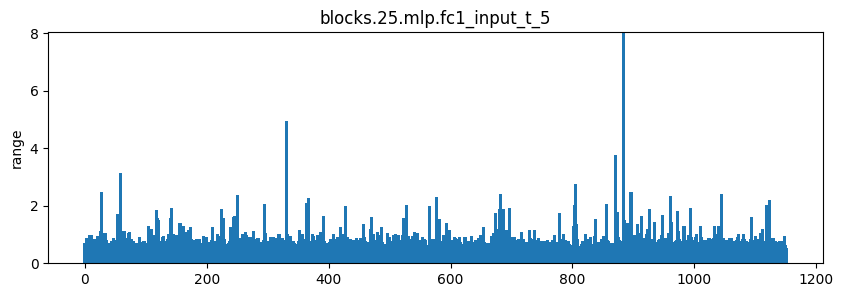

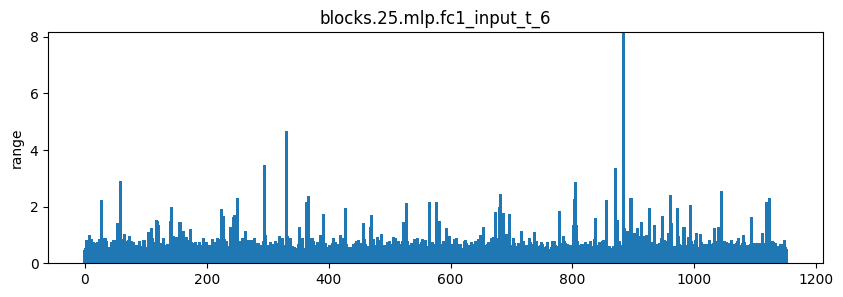

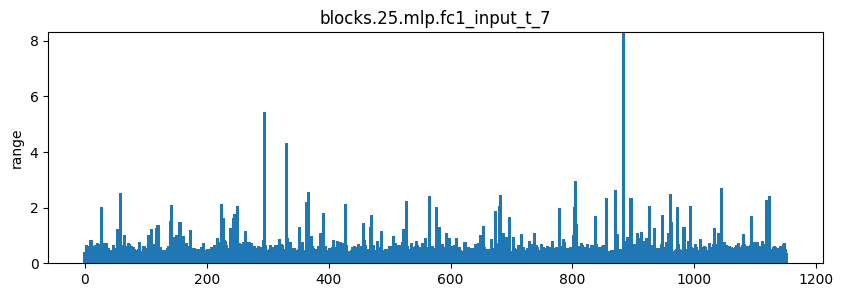

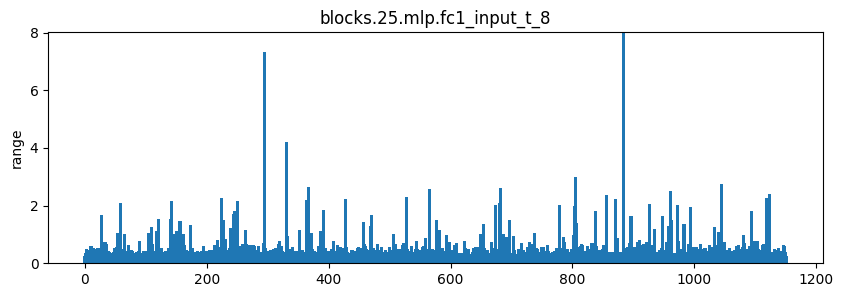

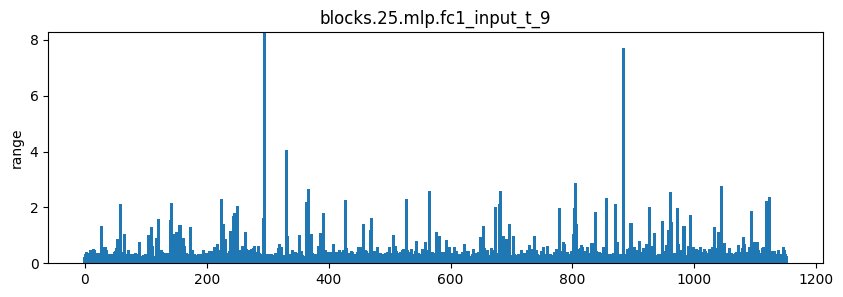

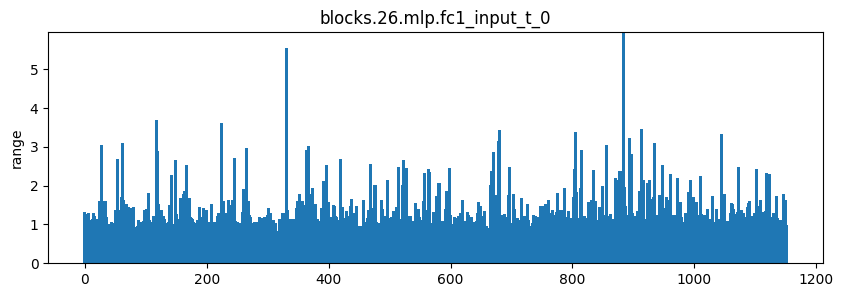

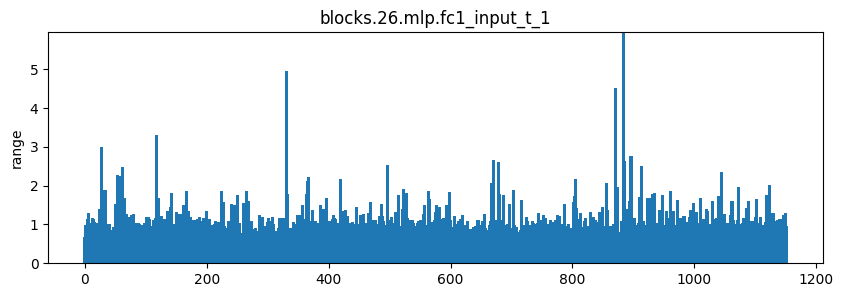

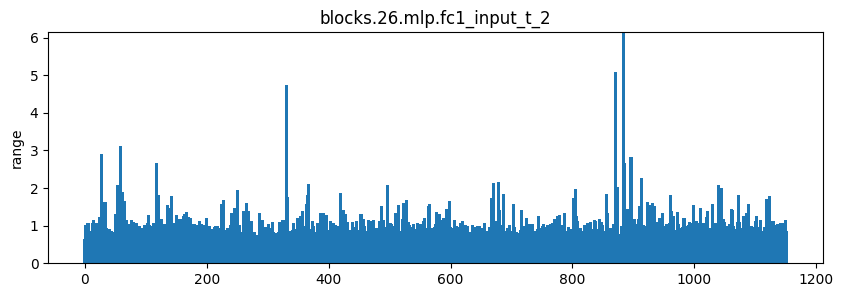

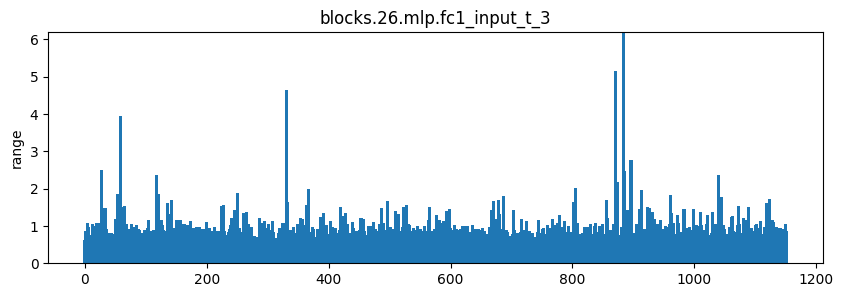

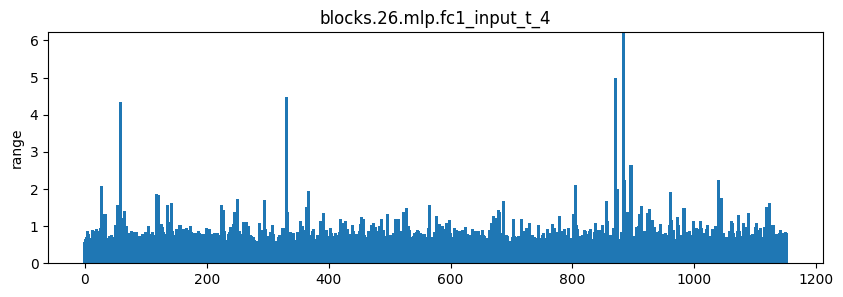

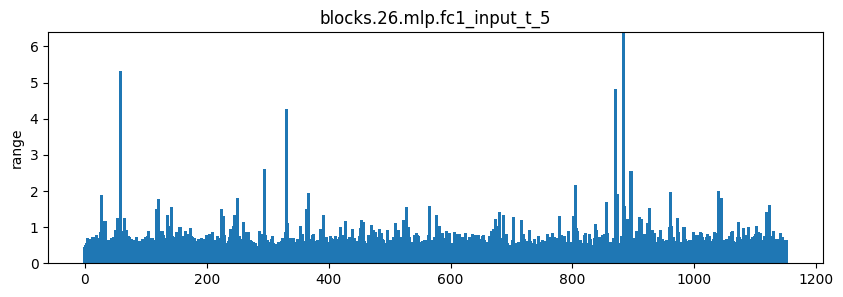

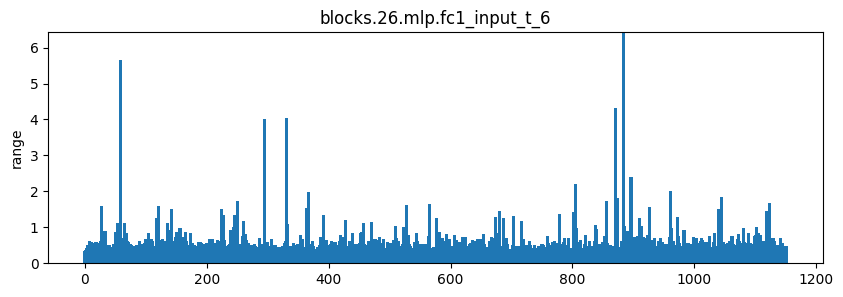

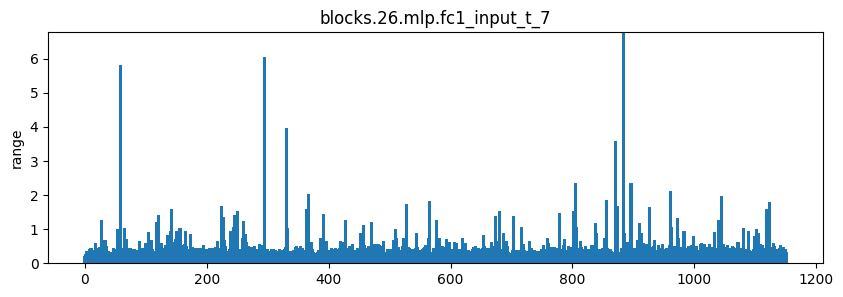

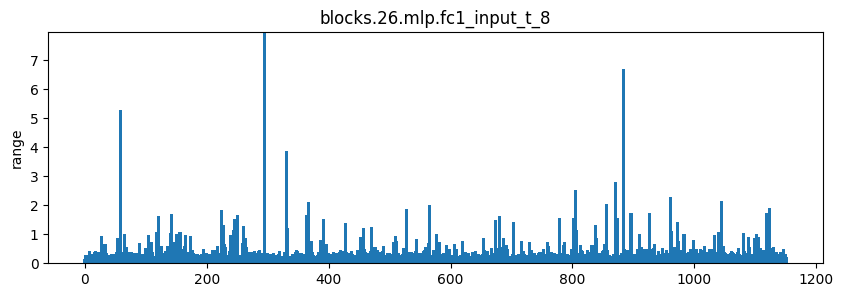

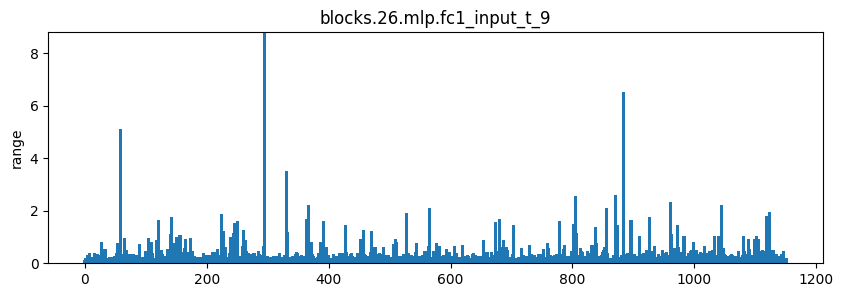

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

import plotly.graph_objects as go
import numpy as np
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def plot_activation_channel(input_data, split_dim=0, name=''):
    print(input_data.shape, input_data.shape[split_dim])
    input_data = input_data.cpu().detach()
    # print(input_data.reshape([-1, input_data.shape[split_dim]]).shape)
    max_values = torch.max(input_data.abs().reshape([-1, input_data.shape[split_dim]]),dim=0)[0]
    print(max_values.shape)
    xs = np.arange(len(max_values))

    fig = plt.figure(figsize=(10, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(xs, max_values,width=5)
    ax.set_xlabel("")
    ax.set_ylabel('range')
    ax.set_title(f'{name}')
    ax.set_ylim([0,max_values.max()])
    fig.show()
    plt.savefig(f'./timestep_variant/{name}.png')

for i_block in range(27):

    name = 'blocks.{}.mlp.fc1'.format(i_block) 
    module = get_module_by_name(model, name)
    module
    print(calib_data.keys())
    
    T, BS_with_cfg, C, D, W, H = calib_data['xs'].size()
    
    inputs = []
    outputs = []
    for i_t in range(0,100,10):
        selected_calib = {}
        for k in calib_data.keys():
            selected_calib[k] = calib_data[k][i_t,:2]
            print(selected_calib[k].shape, selected_calib[k].device)
    
        input_data, output_data = get_data(model, module, selected_calib)
        inputs.append(input_data[0])
        outputs.append(output_data[0])
    
    inputs = torch.stack(inputs,dim=0)
    outputs = torch.stack(outputs,dim=0)
    
    print(inputs.shape, outputs.shape)
    
    print('inputs:',inputs.shape)
    for _t in range(10):
        print(_t)
        plot_activation_channel(inputs[_t], split_dim=2, name=name+f'_input_t_{_t}')

In [76]:
name = 'blocks.27.mlp.fc2'
module = get_module_by_name(model, name)
module
print(calib_data.keys())

T, BS_with_cfg, C, D, W, H = calib_data['xs'].size()

inputs = []
outputs = []
for i_t in range(0,100,10):
    selected_calib = {}
    for k in calib_data.keys():
        selected_calib[k] = calib_data[k][i_t,:2]
        print(selected_calib[k].shape, selected_calib[k].device)

    input_data, output_data = get_data(model, module, selected_calib)
    inputs.append(input_data[0])
    outputs.append(output_data[0])

inputs = torch.stack(inputs,dim=0)
outputs = torch.stack(outputs,dim=0)

print(inputs.shape, outputs.shape)

dict_keys(['xs', 'ts', 'cond_emb', 'mask'])
torch.Size([2, 4, 16, 64, 64]) cuda:0
torch.Size([2]) cuda:0
torch.Size([2, 1, 120, 4096]) cuda:0
torch.Size([2, 120]) cuda:0
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
torch.Size([2, 4, 16, 64, 64]) cuda:0
torch.Size([2]) cuda:0
torch.Size([2, 1, 120, 4096]) cuda:0
torch.Size([2, 120]) cuda:0
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
torch.Size([2, 4, 16, 64, 64]) cuda:0
torch.Size([2]) cuda:0
torch.Size([2, 1, 120, 4096]) cuda:0
torch.Size([2, 120]) cuda:0
Getting the intermediate output at one inference...Input shape: 
xs:torch.Size([2, 4, 16, 64, 64])
ts:torch.Size([2])
cond_emb:torch.Size([2, 1, 120, 4096])
torch.Size([2, 4, 16, 64, 64]) cuda:0
torch.Size([2]) cuda:0
torch.Size([2, 1, 120, 4096]) cuda:0
torch.Siz

torch.Size([20, 4608])
11.37


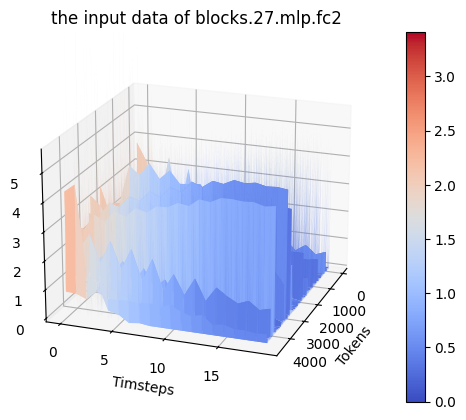

In [82]:
def plot_activation_3d(input_data, name, color_top, type='plotly'):
    inputs_np = np.abs(input_data.detach().cpu().numpy())

    if len(inputs_np.shape)==4:
        batch_size, in_channels = inputs_np.shape[0:2]
        x_data = batch_size
        y_data = in_channels
        inputs_np = inputs_np.mean(axis=(2, 3))
        inputs_np = inputs_np.reshape(batch_size, in_channels)
        x_label = "Batch Size"
    elif len(inputs_np.shape)==3:
        token_length = inputs_np.shape[1]
        in_channels = inputs_np.shape[2]
        x_data = token_length
        y_data = in_channels
        inputs_np = inputs_np.mean(axis=(0))  # along batch dim
        inputs_np = inputs_np.reshape(token_length, in_channels)
        x_label = "Tokens"
    else:
        batch_size = inputs_np.shape[0]
        in_channels = input_data.shape[1]
        x_data = batch_size
        y_data = in_channels
        inputs_np = inputs_np.reshape(batch_size, in_channels)
        x_label = "Batch Size"
        
    _x = np.arange(x_data)
    _y = np.arange(y_data)
    _X, _Y = np.meshgrid(_x, _y)

    _X = _X.T
    _Y = _Y.T

    if type == 'matplotlib':

        color_rescale = 0.3
        zlim_rescale = 0.5

        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        surf = ax.plot_surface(_X, _Y, inputs_np, cmap='coolwarm', vmin=color_rescale*np.min(inputs_np), vmax=color_rescale*color_top)
    
        ax.set_xlabel('Tokens')
        ax.set_ylabel('Timsteps')
        ax.set_zlabel('Absolute Activations')
    
        ax.set_zlim([0, np.max(np.abs(inputs_np))*zlim_rescale])
        # ax.set_zlim([-np.max(np.abs(inputs_np))*zlim_rescale, np.max(np.abs(inputs_np))*zlim_rescale])
        print(np.max(np.abs(inputs_np)))
        fig.colorbar(surf)
        ax.view_init(elev=20, azim=20)
        plt.title('the input data of '+name)
        plt.savefig(f'./distribution_plot/timestep_wise/{name}.pdf')
        plt.show()
    elif type == 'plotly':
        fig = go.Figure()
        colormap_span = 3
        surf = go.Surface(x=_X, y=_Y, z=inputs_np, colorscale='viridis', cmin=np.min(inputs_np), \
                  cmax=np.max(inputs_np),opacity=0.5)
        fig.add_trace(surf)
        
        # Set z-limits
        # fig.update_layout(scene=dict(zaxis=dict(range=[-np.max(np.abs(inputs_np)), np.max(np.abs(inputs_np))])),
        #                   width=800, height=800,xaxis_title=x_label,yaxis_title='input channels'  # Set the figure size
        #                  )
        fig.update_layout(scene=dict(zaxis=dict()),
                          width=800, height=800,xaxis_title=x_label,yaxis_title='input channels'  # Set the figure size
                         )
        # Add color bar
        fig.update_layout()
        
        # Show the plot
        iplot(fig)

inputs_for_3d = inputs[:,:,:,:].reshape([20,16384,4608]).max(dim=1)[0]
print(inputs_for_3d.shape)
plot_activation_3d(inputs_for_3d.permute([1,0]), name, inputs_for_3d.max(), type='matplotlib')
